## **Mount drive**

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
pip install --pre dgl-cu101

In [ ]:
cd '/content/drive/My Drive/IIITH/OPALNet'

/content/drive/My Drive/IIITH/OPALNet


## **Recreating the error**

In [ ]:
import dgl
from dgl.nn.pytorch import GraphConv
import torch
import torch as th
import pickle
import dgl.function as fn
from torch import nn
import torch.nn.functional as F

class LinearNEW(nn.Linear):
    
    def forward(self, input):
        print('new fwd')
        return F.linear(input.to(device), self.weight.to(device), self.bias.to(device))


class GraphConvNEW(GraphConv):

    def forward(self, graph, feat, weight=None):
        r"""Compute graph convolution.

        Notes
        -----
        * Input shape: :math:`(N, *, \text{in_feats})` where * means any number of additional
          dimensions, :math:`N` is the number of nodes.
        * Output shape: :math:`(N, *, \text{out_feats})` where all but the last dimension are
          the same shape as the input.
        * Weight shape: "math:`(\text{in_feats}, \text{out_feats})`.

        Parameters
        ----------
        graph : DGLGraph
            The graph.
        feat : torch.Tensor
            The input feature
        weight : torch.Tensor, optional
            Optional external weight tensor.

        Returns
        -------
        torch.Tensor
            The output feature
        """
        graph = graph.local_var()

        if self._norm == 'both':
            degs = graph.out_degrees().to(feat.device).float().clamp(min=1)
            norm = th.pow(degs, -0.5)
            shp = norm.shape + (1,) * (feat.dim() - 1)
            norm = th.reshape(norm, shp)
            feat = feat * norm

        if weight is not None:
            if self.weight is not None:
                raise DGLError('External weight is provided while at the same time the'
                               ' module has defined its own weight parameter. Please'
                               ' create the module with flag weight=False.')
        else:
            weight = self.weight
            weight = weight.to(device)

        if self._in_feats > self._out_feats:
            # mult W first to reduce the feature size for aggregation.
            if weight is not None:
                feat = th.matmul(feat, weight)
            graph.srcdata['h'] = feat
            graph.update_all(fn.copy_src(src='h', out='m'),
                             fn.sum(msg='m', out='h'))
            rst = graph.dstdata['h']
        else:
            # aggregate first then mult W
            graph.srcdata['h'] = feat
            graph.update_all(fn.copy_src(src='h', out='m'),
                             fn.sum(msg='m', out='h'))
            rst = graph.dstdata['h']
            if weight is not None:
                weight = weight.to(device)
                rst = th.matmul(rst, weight)

        if self._norm != 'none':
            degs = graph.in_degrees().to(feat.device).float().clamp(min=1)
            if self._norm == 'both':
                norm = th.pow(degs, -0.5)
            else:
                norm = 1.0 / degs
            shp = norm.shape + (1,) * (feat.dim() - 1)
            norm = th.reshape(norm, shp)
            rst = rst * norm

        if self.bias is not None:
            rst = rst + self.bias.to(device)

        if self._activation is not None:
            rst = self._activation(rst)

        return rst  


with open('/content/drive/My Drive/IIITH/OPALNet/augmented_dataset/X_train', 'rb') as fp:
            X_train = pickle.load(fp)
with open('/content/drive/My Drive/IIITH/OPALNet/augmented_dataset/adj_train', 'rb') as fp:
            adj_train = pickle.load(fp)

print(X_train.shape)

g = dgl.DGLGraph(adj_train[0])

use_cuda = torch.cuda.is_available()
device = torch.device("cuda:0" if use_cuda else "cpu")
embed = torch.nn.Embedding(24,5)


g = g.to(device) #soln1
#g = g.cuda() #soln2
#g.to(device) #soln3
#g.ndata['feat'].to(device) #soln4

inputs = X_train[0]
adj = adj_train[0]

inputs = torch.from_numpy(inputs)
inputs = inputs.type('torch.FloatTensor')
dev_inputs = inputs.to(device)

embed.weight = torch.nn.Parameter(inputs)
g.ndata['feat'] = embed.weight

g = g.to(device)
print(g)
#g.ndata['feat'] = g.ndata['feat'].to(device)
#g.ndata['feat'] = g.ndata['feat'].cuda()

adj = torch.from_numpy(adj)
adj = adj.type('torch.FloatTensor')
adj = adj.to(device)

conv1 = GraphConvNEW(5, 32)
conv2 = GraphConvNEW(32,16)
conv3 = torch.nn.Conv2d(in_channels=1,out_channels=1,kernel_size=1)
fc1  = LinearNEW(16,128)
dev_inputs = torch.mm(adj,dev_inputs)
batched_inputs = torch.reshape(inputs,[-1,1,24,5])
#inputs = inputs.to(device)
#inputs = inputs.cuda()
print(type(dev_inputs),dev_inputs.is_cuda)
h = conv1(g,dev_inputs)
h = conv2(g,h)
print(h.shape)
skip = conv3(batched_inputs[:,:,:,:4])
print(skip.shape)
op = fc1(h)
print(op.shape)

Using backend: pytorch


(80370, 24, 5)
DGLGraph(num_nodes=24, num_edges=40,
         ndata_schemes={'feat': Scheme(shape=(5,), dtype=torch.float32)}
         edata_schemes={})
<class 'torch.Tensor'> False
torch.Size([24, 16])
torch.Size([1, 1, 24, 4])
new fwd
torch.Size([24, 128])


## **params**

In [ ]:
parameters = {'parts':24,'class_size':10,'latent_size':64,'batch_size':32}
dir_path = '/content/drive/My Drive/IIITH/OPALNet/augmented_dataset/'

## **utils**


In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import pickle
import math
import sys
import cv2
import torch
import dgl

use_cuda = torch.cuda.is_available()
device = torch.device("cuda:0" if use_cuda else "cpu")

max_num_node = 24
canvas_size = 550

flip_bird = [1,3,2,4,5,6,8,7,11,12,9,10,13]
flip_cow = [1,3,2,5,4,6,8,7,9,10,13,14,11,12,17,18,15,16,19]
flip_cat = [1,3,2,5,4,6,7,8,11,12,9,10,15,16,13,14,17]
flip_dog = [1,3,2,5,4,6,7,8,11,12,9,10,15,16,13,14,17,18]
flip_horse = [1,3,2,5,4,6,8,7,9,10,13,14,11,12,17,18,15,16,19,21,20]
flip_person = [1,3,2,5,4,7,6,8,9,10,11,12,16,17,18,13,14,15,22,23,24,19,20,21]
flip_sheep = flip_cow

person_tree = {}
person_tree[0] = [1,2,3,4,7,8,9,10,11]
person_tree[1] = [0,2,3,5,7]
person_tree[2] = [0,1,4,6,7]
person_tree[3] = [0,1]
person_tree[4] = [0,2]
person_tree[5] = [1]
person_tree[6] = [2]
person_tree[7] = [0,1,2,8]
person_tree[8] = [0,7]
person_tree[9] = [0]
person_tree[10] = [0,11,13,16,19,22]
person_tree[11] = [0,10]
person_tree[12] = [13,14]
person_tree[13] = [10,12]
person_tree[14] = [12]
person_tree[15] = [16,17]
person_tree[16] = [10,15]
person_tree[17] = [15]
person_tree[18] = [19,20]
person_tree[19] = [18,10]
person_tree[20] = [18]
person_tree[21] = [22,23]
person_tree[22] = [21,10]
person_tree[23] = [21]

bird_tree = {}
bird_tree[0] = [1,2,3,4,5]
bird_tree[1] = [0,2,3]
bird_tree[2] = [0,1,3]
bird_tree[3] = [0,1,2]
bird_tree[4] = [0,5,6,7,8,10,12]
bird_tree[5] = [0,4]
bird_tree[6] = [7,4]
bird_tree[7] = [6,4]
bird_tree[8] = [4,9]
bird_tree[9] = [8]
bird_tree[10] = [11,4]
bird_tree[11] = [10]
bird_tree[12] = [4]

dog_tree = {}
dog_tree[0] = [1,2,3,4,5,6,7,17]
dog_tree[1] = [2,0,3]
dog_tree[2] = [0,1,4]
dog_tree[3] = [0,1]
dog_tree[4] = [0,2]
dog_tree[5] = [0,1,2]
dog_tree[6] = [0,8,10,12,14,16,7]
dog_tree[7] = [0,6]
dog_tree[8] = [9,6]
dog_tree[9] = [8]
dog_tree[10] = [6,11]
dog_tree[11] = [10]
dog_tree[12] = [13,6]
dog_tree[13] = [12]
dog_tree[14] = [6,15]
dog_tree[15] = [14]
dog_tree[16] = [6]
dog_tree[17] = [0]

cat_tree = {}
cat_tree[0] = [1,2,3,4,5,6,7]
cat_tree[1] = [2,0,3]
cat_tree[2] = [0,1,4]
cat_tree[3] = [0,1]
cat_tree[4] = [0,2]
cat_tree[5] = [0,1,2]
cat_tree[6] = [0,8,10,12,14,16,7]
cat_tree[7] = [0,6]
cat_tree[8] = [9,6]
cat_tree[9] = [8]
cat_tree[10] = [6,11]
cat_tree[11] = [10]
cat_tree[12] = [13,6]
cat_tree[13] = [12]
cat_tree[14] = [6,15]
cat_tree[15] = [14]
cat_tree[16] = [6]

horse_tree = {}
horse_tree[0] = [1,2,3,4,5,8,9]
horse_tree[1] = [2,0,3]
horse_tree[2] = [0,1,4]
horse_tree[3] = [0,1]
horse_tree[4] = [0,2]
horse_tree[5] = [0,1,2]
horse_tree[6] = [11] #lfho
horse_tree[7] = [13] #rfho
horse_tree[8] = [0,10,12,14,16,18]
horse_tree[9] = [0,8]
horse_tree[10] = [8,11,12]
horse_tree[11] = [10,6]
horse_tree[12] = [10,8,13]
horse_tree[13] = [7]
horse_tree[14] = [8,15,16]
horse_tree[15] = [14,19]
horse_tree[16]= [14,17]
horse_tree[17]= [16,20]
horse_tree[18]= [8]
horse_tree[19] = [15]
horse_tree[20] = [17]

cow_tree = {}
cow_tree[0] = [1,2,3,4,5,6,7,8,9]
cow_tree[1] = [2,0,3,5]
cow_tree[2] = [0,1,4,5]
cow_tree[3] = [0,1,6]
cow_tree[4] = [0,2,7]
cow_tree[5] = [0,1,2]
cow_tree[6] = [0,3] #lfho
cow_tree[7] = [0,4,13] #rfho
cow_tree[8] = [0,9,10,12,14,16,18]
cow_tree[9] = [0,8]
cow_tree[10] = [8,11,12]
cow_tree[11] = [10,6]
cow_tree[12] = [10,8,13]
cow_tree[13] = [7,12]
cow_tree[14] = [8,15,16]
cow_tree[15] = [14]
cow_tree[16]= [8,14,17]
cow_tree[17]= [16]
cow_tree[18]= [8]

motorbike_tree = {}
motorbike_tree[0] = [14,1,2]
motorbike_tree[1] = [14,0]
motorbike_tree[2] = [14,0]
motorbike_tree[3] = [14]
motorbike_tree[4] = [14]
motorbike_tree[5] = [14]
motorbike_tree[6] = [14]
motorbike_tree[7] = [14]
motorbike_tree[8] = [14]
motorbike_tree[9] = [14]
motorbike_tree[10]= [14]
motorbike_tree[11]= [14]
motorbike_tree[12]= [14]
motorbike_tree[13]= [14]
motorbike_tree[14]= [0,1,2,3,4,5,6,7,8,9,10,11,12,13]

bicycle_tree = {}
bicycle_tree[0] = [15,1,3]
bicycle_tree[1] = [15,0,2,4]
bicycle_tree[2] = [15,1]
bicycle_tree[3] = [15,0]
bicycle_tree[4] = [15,1]
bicycle_tree[5] = [15]
bicycle_tree[6] = [15]
bicycle_tree[7] = [15]
bicycle_tree[8] = [15]
bicycle_tree[9] = [15]
bicycle_tree[10]= [15]
bicycle_tree[11]= [15]
bicycle_tree[12]= [15]
bicycle_tree[13]= [15]
bicycle_tree[14]= [15]
bicycle_tree[15]= [0,1,2,3,4,5,6,7,8,9,10,11,12,13,14]

aeroplane_tree = {}
aeroplane_tree[0] = [1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22]
aeroplane_tree[1] = [0]
aeroplane_tree[2] = [0,3]
aeroplane_tree[3] = [0,2]
aeroplane_tree[4] = [0]
aeroplane_tree[5] = [0]
aeroplane_tree[6] = [0]
aeroplane_tree[7] = [0]
aeroplane_tree[8] = [0]
aeroplane_tree[9] = [0]
aeroplane_tree[10]= [0]
aeroplane_tree[11]= [0]
aeroplane_tree[12]= [0]
aeroplane_tree[13]= [0]
aeroplane_tree[14]= [0]
aeroplane_tree[15]= [0]
aeroplane_tree[16]= [0]
aeroplane_tree[17]= [0]
aeroplane_tree[18]= [0]
aeroplane_tree[19]= [0]
aeroplane_tree[20]= [0]
aeroplane_tree[21]= [0]
aeroplane_tree[22]= [0]

tree = { 'aeroplane':aeroplane_tree, 'motorbike':motorbike_tree,'bicycle':bicycle_tree, 'person':person_tree, 'cow':cow_tree, 'dog':dog_tree, 'cat':cat_tree, 'sheep':cow_tree, 'bird':bird_tree, 'horse':horse_tree }

object_names = ['cow','sheep','bird','person','cat','dog','horse','aeroplane','motorbike','bicycle']

class_dic = {'cow':0,'sheep':1,'bird':2,'person':3,'cat':4,'dog':5,'horse':6,'aeroplane':7,'motorbike':8,'bicycle':9,'car':10}

def get_pos(bbx):
    temp_pos = []
    for i in bbx:
        if i.tolist()!=[0,0,0,0]:
            temp_pos.append([1])
        elif i.tolist()==[0,0,0,0]:
            temp_pos.append([0])

    return np.asarray(temp_pos)

#colors = [(229,184,135), (0,0,255), (0,255,0),(255,0,0),(0,255,255),(255,255,0),(255,0,255),(130,0,75),(0,128,128),(128,128,0),(128,128,128),(0,0,0),(30,105,210),(30,105//2,210//2),(180,105,255),(180//2,105//2,255),(100,100,30),(0,100//2,20),(128,0,128),(30,105,210),(255//2,105,255),(180//2,105,255//2),(50,100,0), (229//2,184,135//2),(229,184,135), (0,0,255), (0,255,0),(255,0,0),(0,255,255),(255,255,0),(255,0,255),(130,0,75),(0,128,128),(128,128,0),(128,128,128),(0,0,0),(30,105,210),(30,105//2,210//2),(180,105,255),(180//2,105//2,255),(100,100,30),(0,100//2,20),(128,0,128),(30,105,210),(255//2,105,255),(180//2,105,255//2),(50,100,0), (229//2,184,135//2)]
colors = [(1, 0, 0),
          (0.737, 0.561, 0.561),
          (0.255, 0.412, 0.882),
          (0.545, 0.271, 0.0745),
          (0.98, 0.502, 0.447),
          (0.98, 0.643, 0.376),
          (0.18, 0.545, 0.341),
          (0.502, 0, 0.502),
          (0.627, 0.322, 0.176),
          (0.753, 0.753, 0.753),
          (0.529, 0.808, 0.922),
          (0.416, 0.353, 0.804),
          (0.439, 0.502, 0.565),
          (0.784, 0.302, 0.565),
          (0.867, 0.627, 0.867),
          (0, 1, 0.498),
          (0.275, 0.51, 0.706),
          (0.824, 0.706, 0.549),
          (0, 0.502, 0.502),
          (0.847, 0.749, 0.847),
          (1, 0.388, 0.278),
          (0.251, 0.878, 0.816),
          (0.933, 0.51, 0.933),
          (0.961, 0.871, 0.702)]
colors = (np.asarray(colors)*255)


def arrangement(a, b, object_name):
    if object_name=='cow' or object_name=='sheep':
        p = [ 10,11,18,13,12,14,16,15,17,9,0,7,3,4,5,6,1,2,8 ]
    elif object_name=='bird':
        p = [ 10,11,12,9,0,7,3,4,5,6,1,2,8 ]
    elif object_name=='person':
        p = [ 10,11,19,18,20,22,21,23,13,12,14,16,15,17,9,0,7,3,4,5,6,1,2,8 ]
    elif object_name=='cat':
        p = [ 10,11,13,12,14,16,15,9,0,7,3,4,5,6,1,2,8]
    elif object_name=='dog':
        p = [ 10,11,13,12,14,16,15,17,9,0,7,3,4,5,6,1,2,8]
    elif object_name=='horse':
        p = [ 10,11,19,18,20,13,12,14,16,15,17,9,0,7,3,4,5,6,1,2,8 ]
    elif object_name=='aeroplane':
        p = [ 10,11,19,18,20,22,21,13,12,14,16,15,17,9,0,7,3,4,5,6,1,2,8 ]
    elif object_name=='car':
        p = [ 10,11,19,18,20,22,21,23,24,25,26,27,28,13,12,14,16,15,17,9,0,7,3,4,5,6,1,2,8 ]
    elif object_name=='motorbike':
        p = [ 10,11,13,12,14,9,0,7,3,4,5,6,1,2,8 ]
    elif object_name=='bicycle':
        p = [ 10,11,13,12,14,15,9,0,7,3,4,5,6,1,2,8 ]
    else:
        print("error")
    return a[p], b[p]

def rearrange(lbl, bbx, mask, object_name):
    if object_name=='cow' or object_name=='sheep':
        p = np.asarray([1,3,2,5,4,6,8,7,9,10,13,14,11,12,17,18,15,16,19])-1
    elif object_name=='bird':
        p = np.asarray([1,3,2,4,5,6,8,7,11,12,9,10,13])-1
    elif object_name=='person':
        p = np.asarray([1,3,2,5,4,7,6,8,9,10,11,12,16,17,18,13,14,15,22,23,24,19,20,21])-1
    elif object_name=='cat':
        p = np.asarray([1,3,2,5,4,6,7,8,11,12,9,10,15,16,13,14,17])-1
    elif object_name=='dog':
        p = np.asarray([1,3,2,5,4,6,7,8,11,12,9,10,15,16,13,14,17,18])-1
    elif object_name=='horse':
        p = np.asarray([1,3,2,5,4,6,8,7,9,10,13,14,11,12,17,18,15,16,19,21,20])-1
    elif object_name=='aeroplane':
        p = np.asarray([1,3,2,5,4,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23])-1
    elif object_name=='car':
        p = np.asarray([1,3,2,4,5,7,6,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29])-1
    elif object_name=='motorbike':
        p = np.asarray([1,3,2,4,5,7,6,8,9,10,11,12,13,14,15])-1
    elif object_name=='bicycle':
        p = np.asarray([1,3,2,4,5,7,6,8,9,10,11,12,13,14,15,16])-1
    else:
        print("error")
    return lbl[p], bbx[p], mask[p]

def pad_along_axis(array, target_length, axis=0):
    pad_size = target_length - array.shape[axis]
    axis_nb = len(array.shape)
    if pad_size < 0:
        return array

    npad = [(0, 0) for x in range(axis_nb)]
    npad[axis] = (0, pad_size)

    b = np.pad(array, pad_width=npad, mode='constant', constant_values=0)

    return b

def bounder(img):
    result = np.where(img<0.5)
    listOfCoordinates = list(zip(result[0], result[1]))
    for cord in listOfCoordinates:
        img[cord] = 0
    result1 = np.where(img>=0.5)
    listOfCoordinates1 = list(zip(result1[0], result1[1]))
    for cord in listOfCoordinates1:
        img[cord] = 1
    return img

def add_images(canvas,img, ii):
    result = np.where(img!=0)
    listOfCoordinates = list(zip(result[0], result[1]))
    for cord in listOfCoordinates:
        canvas[cord] = ii
    return canvas

label_to_color = {0:(0,0,0),
                    1:(0.941, 0.973, 1),
                    2:(0.98, 0.922, 0.843),
                    3:(0, 1, 1),
                    4:(0.498, 1, 0.831),
                    5:(0.941, 1, 1),
                    6:(0.961, 0.961, 0.863),
                    7:(1, 0.894, 0.769),
                    8:(0.251, 0.878, 0.816),
                    9:(1, 0.388, 0.278),
                    10:(0, 0, 1),
                    11:(0.541, 0.169, 0.886),
                    12:(0.647, 0.165, 0.165),
                    13:(0.871, 0.722, 0.529),
                    14:(0.373, 0.62, 0.627),
                    15:(0.498, 1, 0),
                    16:(0.824, 0.412, 0.118),
                    17:(1, 0.498, 0.314),
                    18:(0.392, 0.584, 0.929),
                    19:(0.275, 0.51, 0.706),
                    20:(0.863, 0.0784, 0.235),
                    21:(0, 1, 1),
                    22:(0, 0, 0.545),
                    23:(0.824, 0.706, 0.549),
                    24:(0.251, 0.878, 0.816)}

def label_2_image(img):
    rgb_img = np.zeros((img.shape[0],img.shape[1], 3))
    for key in label_to_color.keys():
        rgb_img[img == key] = label_to_color[key]
    return rgb_img

def make_mask(box,mask):
    b_in = np.copy(box)
    mx = np.copy(mask)
    max_parts = len(box)
    xmax = max(box[:,2])
    ymax = max(box[:,3])
    canvas = np.zeros((int(ymax),  int(xmax)), np.float32)
    b_in, mx = arrangement(b_in, mx,object_name)
    for i in range(max_parts):
        x_min, y_min, x_max, y_max = b_in[i]
        if x_max-x_min > 0 and y_max-y_min>0:
            x, y = canvas[ int(y_min):int(y_max), int(x_min):int(x_max) ].shape
            canvas[ int(y_min):int(y_max), int(x_min):int(x_max) ] = add_images(canvas[ int(y_min):int(y_max), int(x_min):int(x_max)  ],cv2.resize(bounder(np.squeeze(mx[i]))*(i+1), (y,x)), i+1)
    plt.imshow(label_2_image(canvas))
    plt.show()
    return label_2_image(canvas)

def plot_image_bbx(bbx,image):
    canvas = np.copy(image)
    i = 0
    for coord in bbx:
        x_minp, y_minp,x_maxp , y_maxp= coord
        if [x_minp, y_minp,x_maxp , y_maxp]!=[0,0,0,0]:
            cv2.rectangle(canvas, ((x_minp), (y_minp)), ((x_maxp) , (y_maxp) ), colors[i], 4)
        i = i+1
    plt.imshow(canvas)
    plt.show()
    return canvas

def flip_mask(mask):
    mx = np.copy(mask)
    for i in range(len(mx)):
        mx[i] = mx[i][:,::-1]
    return mx

def flip_bbx(label, bbx, img):
    bx = np.copy(bbx)
    x_min = min(bbx[:,0])
    y_min = min(bbx[:,1])
    x_max = max(bbx[:,2])
    y_max = max(bbx[:,3])
    img_center = np.asarray( [((x_max+x_min)/2),  ((y_max+y_min)/2)] )
    img_center = np.hstack( (img_center, img_center) )
    bx[:,[0,2]] += 2*(img_center[[0,2]] - bx[:,[0,2]])
    box_w = abs(bx[:,0] - bx[:,2])
    bx[:,0] -= box_w
    bx[:,2] += box_w
    for i in range(len(label)):
        if sum(label[i])==0:
            bx[i][0] = 0
            bx[i][1] = 0
            bx[i][2] = 0
            bx[i][3] = 0
    return bx

def flip_data_instance(label, box, mask, image,object_name):
    bx = np.copy(flip_bbx(label,box,image))
    mx = np.copy(flip_mask(mask))
    ix = np.copy(image[:,::-1])
    lx = np.copy(label)
    lx, bx, mx = rearrange(lx, bx, mx,object_name)
    return lx,bx,mx,ix
    
def cordinates(img):
    y_min = 0
    y_max = 0
    x_min = 0
    x_max = 0

    for i in img:
        if np.count_nonzero(i) is not 0:
            break
        y_min+=1

    for i in img.T:
        if np.count_nonzero(i) is not 0:
            break
        x_min+=1

    for i in img[::-1]:
        if np.count_nonzero(i) is not 0:
            break
        y_max+=1
    y_max = img.shape[0] - y_max - 1

    for i in img.T[::-1]:
        if np.count_nonzero(i) is not 0:
            break
        x_max+=1
    x_max = img.shape[1] - x_max - 1

    return x_min, y_min, x_max, y_max

def rotate_im(image, angle):
    # grab the dimensions of the image and then determine the
    # centre
    (h, w) = image.shape[:2]
    (cX, cY) = (w // 2, h // 2)

    # grab the rotation matrix (applying the negative of the
    # angle to rotate clockwise), then grab the sine and cosine
    # (i.e., the rotation components of the matrix)
    M = cv2.getRotationMatrix2D((cX, cY), angle, 1.0)
    cos = np.abs(M[0, 0])
    sin = np.abs(M[0, 1])

    # compute the new bounding dimensions of the image
    nW = int((h * sin) + (w * cos))
    nH = int((h * cos) + (w * sin))

    # adjust the rotation matrix to take into account translation
    M[0, 2] += (nW / 2) - cX
    M[1, 2] += (nH / 2) - cY

    # perform the actual rotation and return the image
    image = cv2.warpAffine(image, M, (nW, nH))

#    image = cv2.resize(image, (w,h))
    return image

def get_corners(bboxes):

    width = (bboxes[:,2] - bboxes[:,0]).reshape(-1,1)
    height = (bboxes[:,3] - bboxes[:,1]).reshape(-1,1)

    x1 = bboxes[:,0].reshape(-1,1)
    y1 = bboxes[:,1].reshape(-1,1)

    x2 = x1 + width
    y2 = y1

    x3 = x1
    y3 = y1 + height

    x4 = bboxes[:,2].reshape(-1,1)
    y4 = bboxes[:,3].reshape(-1,1)

    corners = np.hstack((x1,y1,x2,y2,x3,y3,x4,y4))

    return corners

def clip_box(bbox, clip_box, alpha):
    ar_ = (bbox_area(bbox))
    x_min = np.maximum(bbox[:,0], clip_box[0]).reshape(-1,1)
    y_min = np.maximum(bbox[:,1], clip_box[1]).reshape(-1,1)
    x_max = np.minimum(bbox[:,2], clip_box[2]).reshape(-1,1)
    y_max = np.minimum(bbox[:,3], clip_box[3]).reshape(-1,1)

    bbox = np.hstack((x_min, y_min, x_max, y_max, bbox[:,4:]))

    delta_area = ((ar_ - bbox_area(bbox))/ar_)

    mask = (delta_area < (1 - alpha)).astype(int)

    bbox = bbox[mask == 1,:]


    return bbox

def rotate_box(corners,angle,  cx, cy, h, w):

    corners = corners.reshape(-1,2)
    corners = np.hstack((corners, np.ones((corners.shape[0],1), dtype = type(corners[0][0]))))

    M = cv2.getRotationMatrix2D((cx, cy), angle, 1.0)


    cos = np.abs(M[0, 0])
    sin = np.abs(M[0, 1])

    nW = int((h * sin) + (w * cos))
    nH = int((h * cos) + (w * sin))
    # adjust the rotation matrix to take into account translation
    M[0, 2] += (nW / 2) - cx
    M[1, 2] += (nH / 2) - cy
    # Prepare the vector to be transformed
    calculated = np.dot(M,corners.T).T

    calculated = calculated.reshape(-1,8)

    return calculated

def get_enclosing_box(corners):
    x_ = corners[:,[0,2,4,6]]
    y_ = corners[:,[1,3,5,7]]

    xmin = np.min(x_,1).reshape(-1,1)
    ymin = np.min(y_,1).reshape(-1,1)
    xmax = np.max(x_,1).reshape(-1,1)
    ymax = np.max(y_,1).reshape(-1,1)

    final = np.hstack((xmin, ymin, xmax, ymax,corners[:,8:]))

    return final

def bbox_area(bbox):
    return (bbox[:,2] - bbox[:,0])*(bbox[:,3] - bbox[:,1])

def rtt(angle, label, img, bboxes):

    w,h = img.shape[1], img.shape[0]
    cx, cy = w//2, h//2

    img = rotate_im(img, angle)

    corners = get_corners(bboxes)

    corners = np.hstack((corners, bboxes[:,4:]))


    corners[:,:8] = rotate_box(corners[:,:8], angle, cx, cy, h, w)

    new_bbox = get_enclosing_box(corners)


    scale_factor_x = img.shape[1] / w

    scale_factor_y = img.shape[0] / h

    img = cv2.resize(img, (w,h))

    new_bbox[:,:4] = np.true_divide(new_bbox[:,:4], [scale_factor_x, scale_factor_y, scale_factor_x, scale_factor_y])

    for i in range(len(label)):
        if sum(label[i])==0:
            new_bbox[i][0] = 0
            new_bbox[i][1] = 0
            new_bbox[i][2] = 0
            new_bbox[i][3] = 0

    return img, new_bbox
def render_mask(box,mask,angle):
    mx = np.copy(mask)
    b_in = np.copy(box)
    max_parts = len(box)
    xmax = max(box[:,2])
    ymax = max(box[:,3])
    temp_mx_list = []
    temp_bx_list = []
    for i in range(max_parts):
        canvas = np.zeros((int(ymax),  int(xmax)), np.float32)
        x_min, y_min, x_max, y_max = b_in[i]
        if x_max-x_min > 0 and y_max-y_min>0:

            x, y = canvas[ int(y_min):int(y_max), int(x_min):int(x_max) ].shape
            canvas[ int(y_min):int(y_max), int(x_min):int(x_max) ] = add_images(canvas[ int(y_min):int(y_max), int(x_min):int(x_max)  ],cv2.resize(bounder(np.squeeze(mx[i]))*(i+1), (y,x)), i+1)
            canvas = rotate_im(canvas,angle)
            x_min, y_min, x_max, y_max = cordinates(canvas)
            #canvas = canvas[int(y_min):int(y_max), int(x_min):int(x_max)]
            #resized_cropped = np.expand_dims(cv2.resize(canvas, (64, 64)), axis = 3)
        temp_bx_list.append([x_min, y_min, x_max, y_max])
        #temp_mx_list.append(resized_cropped)
        #plt.imshow(canvas)
        #plt.show()
    return np.asarray(temp_bx_list,dtype="float32")
def scale(bbx, scaling_factor):

    height = max(bbx[:,3])
    width = max(bbx[:,2])

    pos = get_pos(bbx)

    fold_a = np.copy(bbx)
    fold_b = np.copy(bbx)
    fold_c = np.copy(bbx)
    fold_d = np.copy(bbx)

    scale_height = scaling_factor
    scale_width = scaling_factor

    fold_a[:,0] = (fold_a[:,0]-scale_width)
    fold_b[:,1] = (fold_b[:,1]-scale_height)
    fold_c[:,2] = (fold_c[:,2]+scale_width)
    fold_d[:,3] = (fold_d[:,3]+scale_height)

    return fold_a*pos,fold_b*pos,fold_c*pos,fold_d*pos

def centre_object(bbx,canvas_size):

    pos = get_pos(bbx)
    bx = np.copy(bbx)

    h,w = canvas_size

    h_o = max(bbx[:,3])
    w_o = max(bbx[:,2])

    h_shift = int(h/2 - h_o/2)
    w_shift = int(w/2 - w_o/2)

    bx[:,0] = (bx[:,0]+w_shift)
    bx[:,1] = (bx[:,1]+h_shift)
    bx[:,2] = (bx[:,2]+w_shift)
    bx[:,3] = (bx[:,3]+h_shift)

    return bx*pos

def append_labels(box): # appends part presence information
                        # along with the bbox submatrix
  all_box = []
  for bbx in box:
    pos = get_pos(bbx)
    bbx = (((bbx/canvas_size)))*pos #scaling bbox coords btw 0 and 1

    #generating part presence vector and appending in front of bbox coords
    temp = []
    for bx in bbx:
      if bx.tolist()!=[0,0,0,0]:
        temp.append([1]+bx.tolist())
      else:
        temp.append([0]+bx.tolist())
    all_box.append(temp)
  return np.asarray(all_box)

def plot_bbx(bbx):
    canvas = np.ones((canvas_size,canvas_size,3), np.uint8) * 255
    for i, coord in enumerate(bbx):
        x_minp, y_minp,x_maxp , y_maxp= coord
        if [x_minp, y_minp,x_maxp , y_maxp]!=[0,0,0,0]:
            cv2.rectangle(canvas, (int(x_minp), int(y_minp)), (int(x_maxp) , int(y_maxp) ), colors[i], 6)
    return canvas

def transform_bbx(bbx1):

    eps = 0.00001
    bbx = np.copy(bbx1)
    bxx = np.copy(bbx)

    bbx[:,0] = np.exp(bbx[:,0])
    bbx[:,1] = np.exp(bbx[:,1])
    bbx[:,2] = np.exp(bbx[:,2])
    bbx[:,3] = np.exp(bbx[:,3])

    bxx[:,0] = bbx[:,0]
    bxx[:,1] = bbx[:,1]
    bxx[:,2] = bbx[:,0] + (bbx[:,3])
    bxx[:,3] = bbx[:,1] + (bbx[:,2])

    return

def frange_cycle_linear(n_iter, start=0.0, stop=1.0,  n_cycle=4, ratio=0.5):
    L = np.ones(n_iter) * stop
    period = n_iter/n_cycle
    step = (stop-start)/(period*ratio) # linear schedule

    for c in range(n_cycle):
        v, i = start, 0
        while v <= stop and (int(i+c*period) < n_iter):
            L[int(i+c*period)] = v
            v += step
            i += 1
    return L

def compute_ciou(target,  output):

    x1g, y1g, x2g, y2g = target[:,:,0], target[:,:,1], target[:,:,2], target[:,:,3]
    x1, y1, x2, y2 = output[:,:,0], output[:,:,1], output[:,:,2], output[:,:,3]
    
    x1g = x1g.to(device)
    y1g = y1g.to(device)
    x2g = x2g.to(device)
    y2g = y2g.to(device)
    
    w_pred = x2 - x1
    h_pred = y2 - y1
    w_gt = x2g - x1g
    h_gt = y2g - y1g

    x_center = (x2 + x1) / 2
    y_center = (y2 + y1) / 2
    x_center_g = (x1g + x2g) / 2
    y_center_g = (y1g + y2g) / 2

    xc1 = torch.min(x1,x1g)
    yc1 = torch.min(y1,y1g)
    xc2 = torch.min(x2,x2g)
    yc2 = torch.min(y2,y2g)

    #iou
    xA = torch.max(x1g, x1)
    yA = torch.max(y1g, y1)
    xB = torch.min(x2g, x2)
    yB = torch.min(y2g, y2)

    zero = torch.zeros(xA.shape).to(device)

    interArea = torch.max(zero, (xB - xA + 1)) * torch.max(zero, yB - yA + 1)
    boxAArea = (x2g - x1g +1) * (y2g - y1g +1)
    boxBArea = (x2 - x1 +1) * (y2 - y1 +1)
    iouk = interArea / (boxAArea + boxBArea - interArea)
    ciouk = -torch.log(iouk) #+ u

    return torch.mean(ciouk)

def box_loss(tru_box, gen_box):
    
    mseloss2 = torch.nn.MSELoss()
    sum_r = mseloss2(gen_box,tru_box.to(device)).type('torch.FloatTensor')
    return sum_r
    
def add_self_loop(g):
    
    new_g = dgl.DGLGraph()
    new_g.add_nodes(g.number_of_nodes())
    src, dst = g.all_edges(order="eid")
    src = src.numpy()
    dst = dst.numpy()
    non_self_edges_idx = src != dst
    nodes = np.arange(g.number_of_nodes())
    new_g.add_edges(src[non_self_edges_idx], dst[non_self_edges_idx])
    new_g.add_edges(nodes, nodes)
    return new_g
    


Using backend: pytorch


## **GCN**

In [ ]:
import torch
import torch as th
import dgl.function as fn
import torch.nn as nn
from dgl.nn.pytorch import GraphConv
from dgl import DGLGraph
import dgl
import numpy as np
#import json
#from params import *
#from utils import *



# CUDA for PyTorch
use_cuda = torch.cuda.is_available()
device = torch.device("cuda:0" if use_cuda else "cpu")

class GCN(nn.Module):
    def __init__(self, in_feats, hidden_size, num_classes):
        super(GCN, self).__init__()
        self.conv1 = GraphConv(in_feats, hidden_size)
        self.conv2 = GraphConv(hidden_size, num_classes)
        self.conv3 = torch.nn.Conv2d(in_channels=1,out_channels=1,kernel_size=1)
        self.linear = nn.Linear(parameters['parts']*4,2*parameters['latent_size'])

    def forward(self, g, inputs,adj):
    
        dev_inputs = inputs.to(device)
    
        #pass through the 2 gcn layers
        dev_inputs = torch.mm(adj,dev_inputs)
        batched_inputs = torch.reshape(inputs.to(device),[-1,1,parameters['parts'],5])
        #inputs = inputs.to(device)
        g = g.to(device)
        h = self.conv1(g, dev_inputs)
        #h = self.conv1(inputs,g)
        h = torch.relu(h)
        h = torch.mm(adj,h)
        h = self.conv2(g, h)
        #h = self.conv2(h,g)
        h = torch.relu(h)

        #skip connection
        skip = self.conv3(batched_inputs[:,:,:,:4])
        #print('skip.shape: ',skip.shape)
        skip = torch.reshape(skip,(-1,4*parameters['parts']))
        #skip = torch.flatten(skip)
        skip = self.linear(skip)

        return h,skip

def add_features(G,parts,X):
    #feature matrix
    embed = nn.Embedding(parts, 5)  # p nodes with embedding dim equal to 5
    embed.weight = torch.nn.Parameter(torch.from_numpy(X))
    G.ndata['feat'] = embed.weight.to(device)
    return embed

# modifying the forward function by inheriting GraphConv class

class GraphConvNEW(GraphConv):

    def forward(self, graph, feat, weight=None):
        r"""Compute graph convolution.

        Notes
        -----
        * Input shape: :math:`(N, *, \text{in_feats})` where * means any number of additional
          dimensions, :math:`N` is the number of nodes.
        * Output shape: :math:`(N, *, \text{out_feats})` where all but the last dimension are
          the same shape as the input.
        * Weight shape: "math:`(\text{in_feats}, \text{out_feats})`.

        Parameters
        ----------
        graph : DGLGraph
            The graph.
        feat : torch.Tensor
            The input feature
        weight : torch.Tensor, optional
            Optional external weight tensor.

        Returns
        -------
        torch.Tensor
            The output feature
        """
        graph = graph.local_var()

        if self._norm == 'both':
            degs = graph.out_degrees().to(feat.device).float().clamp(min=1)
            norm = th.pow(degs, -0.5)
            shp = norm.shape + (1,) * (feat.dim() - 1)
            norm = th.reshape(norm, shp)
            feat = feat * norm

        if weight is not None:
            if self.weight is not None:
                raise DGLError('External weight is provided while at the same time the'
                               ' module has defined its own weight parameter. Please'
                               ' create the module with flag weight=False.')
        else:
            weight = self.weight
            weight = weight.to(device)

        if self._in_feats > self._out_feats:
            # mult W first to reduce the feature size for aggregation.
            if weight is not None:
                feat = th.matmul(feat, weight)
            graph.srcdata['h'] = feat
            graph.update_all(fn.copy_src(src='h', out='m'),
                             fn.sum(msg='m', out='h'))
            rst = graph.dstdata['h']
        else:
            # aggregate first then mult W
            graph.srcdata['h'] = feat
            graph.update_all(fn.copy_src(src='h', out='m'),
                             fn.sum(msg='m', out='h'))
            rst = graph.dstdata['h']
            if weight is not None:
                weight = weight.to(device)
                rst = th.matmul(rst, weight)

        if self._norm != 'none':
            degs = graph.in_degrees().to(feat.device).float().clamp(min=1)
            if self._norm == 'both':
                norm = th.pow(degs, -0.5)
            else:
                norm = 1.0 / degs
            shp = norm.shape + (1,) * (feat.dim() - 1)
            norm = th.reshape(norm, shp)
            rst = rst * norm

        if self.bias is not None:
            rst = rst + self.bias.to(device)

        if self._activation is not None:
            rst = self._activation(rst)

        return rst  


## **data_utils**

In [ ]:
#from utils import *
#from gcn import add_features
from torch.utils.data import Dataset, DataLoader
import pickle
import numpy as np
import dgl
import torch
from dgl import DGLGraph
from torchvision import transforms, utils
#import json
#from params import *



# CUDA for PyTorch
use_cuda = torch.cuda.is_available()
device = torch.device("cuda:0" if use_cuda else "cpu")


def data_augmentation(dir_path): # augments data and saves it
    #uses 75% as training, 10% for val and 15% for test sets respectively
    class_v = {}
    X_train = {}
    adj_train = {}
    for object_name in object_names:

        with open(dir_path+object_name+'_images', 'rb') as f:
          o_images = pickle.load(f)
          print(len(o_images))
        with open(dir_path+object_name+'_part_separated_labels', 'rb') as f:
          o_labels = pickle.load(f)
          print(len(o_labels))
        with open(dir_path+object_name+'_part_separated_masks', 'rb') as f:
          o_masks = pickle.load(f)
          print(len(o_masks))
        with open(dir_path+object_name+'_part_separated_bbx', 'rb') as f:
          o_bbx = pickle.load(f)
          print(len(o_bbx))

        train_set_limit = int(len(o_bbx)*(75/100))
        validation_set_limit = int(len(o_bbx)*(10/100))
        test_set_limit = int(len(o_bbx)*(15/100))

        print(object_name,train_set_limit,validation_set_limit,test_set_limit)

        label = o_labels[0:train_set_limit]
        box = o_bbx[0:train_set_limit]
        mask = o_masks[0:train_set_limit]
        image = o_images[0:train_set_limit]

        label_val = o_labels[train_set_limit:train_set_limit+validation_set_limit]
        box_val = o_bbx[train_set_limit:train_set_limit+validation_set_limit]
        mask_val = o_masks[train_set_limit:train_set_limit+validation_set_limit]
        image_val = o_images[train_set_limit:train_set_limit+validation_set_limit]

        label_test = o_labels[train_set_limit+validation_set_limit::]
        box_test = o_bbx[train_set_limit+validation_set_limit::]
        mask_test = o_masks[train_set_limit+validation_set_limit::]
        image_test = o_images[train_set_limit+validation_set_limit::]

        max_parts = len(label[0])

        #data augmentation starts ---------------------------------------------

        flipped_label = []
        flipped_box = []
        flipped_mask = []
        flipped_image = []

        label = label_test
        box = box_test
        mask = mask_test
        image = image_test

        print('At the beginning: ',len(box))

        angle = 3

        for l,b,m,i in zip(label,  box, mask, image):
            ll, bb, mm, ii = flip_data_instance(l,b,m,i,object_name)
            flipped_label.append(ll)
            flipped_box.append(bb)
            flipped_mask.append(mm)
            #flipped_image.append(ii)

        flipped_label = np.asarray(flipped_label)
        flipped_box =   np.asarray(flipped_box )
        flipped_mask =  np.asarray(flipped_mask)
        flipped_image = np.asarray(flipped_image)


        label = np.concatenate((label, flipped_label), axis = 0)
        box = np.concatenate((box, flipped_box), axis = 0)
        mask = np.concatenate((mask, flipped_mask), axis = 0)
        image = np.concatenate((image, flipped_image), axis = 0)

        print('After concatenating flipped ones: ',len(box))

        rt_box = []
        for bx, mx in zip(box, mask):
          bbxx1 = render_mask(bx,mx,angle)
          bbxx2 = render_mask(bx,mx,-angle)
          rt_box.append(bbxx1)
          rt_box.append(bbxx2)

        rt_box = np.asarray(rt_box)
        box = box = np.concatenate((box, rt_box), axis = 0)

        print('After concatenating rt: ', len(box))

        centre_box = []
        for bx in box:
          centre_box.append(centre_object(bx, (canvas_size,canvas_size)))

        centre_box = np.asarray(centre_box)
        box = centre_box

        scale_box = []
        for bx in box:
          a,b,c,d = scale(bx, 0.01)
          scale_box.append(a)
          scale_box.append(b)
          scale_box.append(c)
          scale_box.append(d)

        scale_box = np.asarray(scale_box)
        box = np.concatenate((box, scale_box), axis = 0)

        print('After concatenating scaled boxes: ',len(box))
        box = append_labels(box)
        box = pad_along_axis(box, 24, axis=1) #pads extra 0 rows at bottom
                                                # to get uniform size

        numparts = 24

        #data augmentation ends ---------------------------------------------

        final_input = []

        #generating the adjacency matrix

        for i,x in enumerate(box):
          l = numparts
          temp = np.zeros((l,l), dtype=np.float32)
          for j in range(l):
            temp[j][j] = 1
            if x[j][0] == 1:
              for y in tree[object_name][j]:
                if x[y][0] == 1:
                  temp[j][y] = 1
                  temp[y][j] = 1
          final_input.append(temp)
        adj = np.asarray(final_input)

        class_v[object_name] = (np.asarray([np.eye(10)[class_dic[object_name]]]*len(box)))
        X_train[object_name] = (box)
        adj_train[object_name] = (adj)
        print('len for ',object_name,len(X_train[object_name]))


    cclass_v = np.concatenate((
    class_v['cow'],
    class_v['person'],
    class_v['cat'],
    class_v['dog'],
    class_v['horse'],
    class_v['sheep'],
    class_v['bird'],
    class_v['aeroplane'],
    class_v['motorbike'],
    class_v['bicycle']), axis = 0)


    cadj_train = np.concatenate((
    adj_train['cow'],
    adj_train['person'],
    adj_train['cat'],
    adj_train['dog'],
    adj_train['horse'],
    adj_train['sheep'],
    adj_train['bird'],
    adj_train['aeroplane'],
    adj_train['motorbike'],
    adj_train['bicycle']), axis = 0)


    cX_train = np.concatenate((
    X_train['cow'],
    X_train['person'],
    X_train['cat'],
    X_train['dog'],
    X_train['horse'],
    X_train['sheep'],
    X_train['bird'],
    X_train['aeroplane'],
    X_train['motorbike'],
    X_train['bicycle']), axis = 0)


    X_train = cX_train
    class_v = cclass_v
    adj_train = cadj_train

    with open(dir_path+'X_test', 'wb') as fp:
        pickle.dump(X_train, fp)

    with open(dir_path+'class_v_test', 'wb') as fp:
        pickle.dump(class_v, fp)

    with open(dir_path+'adj_test', 'wb') as fp:
        pickle.dump(adj_train, fp)


def collate(samples):
    X,_,adj,y,pp = map(np.asarray,zip(*samples))
    X = np.reshape(X,[-1,5])
    #print('In collate: X.shape',X.shape)
    pp = np.reshape(pp,[-1,parameters['parts']])
    adj = np.reshape(adj,[-1,parameters['parts'],parameters['parts']])
    _,A,_,_,_ = map(list,zip(*samples))
    A = dgl.batch(A)
    A.to(device)
    #X,A,y,pp = samples[0]

    return X,A,adj,y,pp


class GraphDataset_train(Dataset):

  def __init__(self,dir_path):

        #load train, val or test set from disk

        with open(dir_path+'X_train', 'rb') as fp:
            self.X_train = pickle.load(fp)
        with open(dir_path+'class_v', 'rb') as fp:
            self.class_v_train = pickle.load(fp)
        with open(dir_path+'adj_train', 'rb') as fp:
            self.adj_train = pickle.load(fp)




  def __len__(self):
        return len(self.X_train)

  def __getitem__(self, index):
        'Generates one sample of data'
        # Select sample

        # Load data and get label
        self.X = self.X_train[index]
        self.A = dgl.DGLGraph(self.adj_train[index])
        self.A = add_self_loop(self.A)
        #self.A = self.A.to(device)
        #self.embed = add_features(self.A,parameters['parts'],self.X)
        self.pp = get_pos(self.X)
        self.y = self.class_v_train[index]

        return self.X,self.A,self.adj_train[index],self.y,self.pp

class GraphDataset_val(Dataset):

  def __init__(self,dir_path):

        #load train, val or test set from disk

        with open(dir_path+'X_val', 'rb') as fp:
            self.X_val = pickle.load(fp)
        with open(dir_path+'class_v_val', 'rb') as fp:
            self.class_v_val = pickle.load(fp)
        with open(dir_path+'adj_val', 'rb') as fp:
            self.adj_val = pickle.load(fp)




  def __len__(self):
        return len(self.X_val)

  def __getitem__(self, index):
        'Generates one sample of data'
        # Select sample

        # Load data and get label
        self.X = self.X_val[index]
        self.A = dgl.DGLGraph(self.adj_val[index])
        self.A = add_self_loop(self.A)
        #self.embed = add_features(self.A,parameters['parts'],self.X)
        self.pp = get_pos(self.X)
        self.y = self.class_v_val[index]

        return self.X,self.A,self.adj_val[index],self.y,self.pp

class GraphDataset_test(Dataset):

  def __init__(self,dir_path):

        #load train, val or test set from disk


        with open(dir_path+'X_test', 'rb') as fp:
            self.X_test = pickle.load(fp)
        with open(dir_path+'class_v_test', 'rb') as fp:
            self.class_v_test = pickle.load(fp)
        with open(dir_path+'adj_test', 'rb') as fp:
            self.adj_test = pickle.load(fp)




  def __len__(self):
        return len(self.X_test)

  def __getitem__(self, index):
        'Generates one sample of data'
        # Select sample

        # Load data and get label
        self.X = self.X_test[index]
        self.A = dgl.DGLGraph(self.adj_test[index])
        self.A = add_self_loop(self.A)
        #self.embed = add_features(self.A,parameters['parts'],self.X)
        self.pp = get_pos(self.X)
        self.y = self.class_v_test[index]

        return self.X,self.A,self.adj_test[index],self.y,self.pp


## **CVAE**

In [ ]:


import torch
import torch.utils.data
from torch import nn, optim
from torch.nn import functional as F
from torchvision import datasets, transforms
from torchvision.utils import save_image
#import json
#from params import *

use_cuda = torch.cuda.is_available()
device = torch.device("cuda:0" if use_cuda else "cpu")

#Modifying Linear forward pass by inheriting class
class LinearNEW(nn.Linear):
    
    def forward(self, input):
        #print('new fwd')
        return F.linear(input.to(device), self.weight.to(device), self.bias.to(device))


class CVAE(nn.Module):
    def __init__(self, feature_size, latent_size, class_size):
        super(CVAE, self).__init__()
        self.feature_size = feature_size
        self.class_size = class_size

        # encode
        self.fc1  = nn.Linear(parameters['parts']*16,128)
        self.fc2  = nn.Linear(128,128)
        self.fc3  = nn.Linear(feature_size + class_size, 128)
        self.fc41 = nn.Linear(128, latent_size)
        self.fc42 = nn.Linear(128, latent_size)

        # decode
        self.fc5 = nn.Linear(parameters['latent_size']+parameters['parts']+parameters['class_size'], 128)
        self.fc6 = nn.Linear(128, 128)
        self.fc7 = nn.Linear(128, 128)
        self.fc81 = nn.Linear(128,4*parameters['parts']) #bbox sub-matrix
        self.fc82 = nn.Linear(128,1*parameters['parts']) #part presence vec
        self.fc83 = nn.Linear(128,parameters['parts']*parameters['parts']) #adj matrix
        self.fc84 = nn.Linear(128,class_size)

        self.sigmoid = nn.Sigmoid()
        self.relu = nn.ReLU()
        self.softmax = nn.Softmax()

    def encode(self,inputs,skip,c,pp): # Q(z|x, c)
        '''
        x: feature_size
        c: class_size
        '''
        inputs = inputs.to(device)
        h1 = self.relu(self.fc1(inputs))
        h1 = h1 + skip.to(device)  # skip connection
        h2 = self.relu(self.fc2(h1)) #float32
        c = c.to(device)
        h2 = torch.cat((c,h2),-1)
        h3 = self.relu(self.fc3(h2))
        z_mu = self.relu(self.fc41(h3))
        z_var = self.relu(self.fc42(h3))
        #print('mu var',z_mu,z_var)
        return z_mu, z_var

    def reparameterize(self, mu, logvar):
        std = torch.exp(0.5*logvar)
        eps = torch.randn_like(std)
        return mu + eps*std

    def decode(self, z, cpp): # P(x|z, c)
        '''
        z: latent_size
        c: class_size
        '''
        cpp = cpp.to(device)
        z = torch.cat((cpp,z),-1)
        h5 = self.relu(self.fc5(z))
        h6 = self.relu(self.fc6(h5))
        h7 = self.relu(self.fc7(h6))
        bbox = self.sigmoid(self.fc81(h7))
        part_vec = self.sigmoid(self.fc82(h7))
        A = self.sigmoid(self.fc83(h7))
        class_ = self.softmax(self.fc84(h7))

        return bbox,part_vec,A,class_

    def forward(self, inputs, skip, c, pp):
        c = c.type('torch.FloatTensor')
        pp = pp.type('torch.FloatTensor')
        mu, logvar = self.encode(inputs, skip, c,pp)
        z = self.reparameterize(mu, logvar)
        #print('z',z)
        cpp = torch.cat((c,pp),-1)
        bbox, part_vec, A, class_ = self.decode(z, cpp)
        return bbox, part_vec, A, class_, mu, logvar, z, cpp


## **New**

In [ ]:
import torch
import torch.utils.data
from torch import nn, optim
from torch.nn import functional as F
from torchvision import datasets, transforms
from torchvision.utils import save_image
import torch as th
import dgl.function as fn
import torch.nn as nn
from dgl.nn.pytorch import GraphConv
from dgl import DGLGraph
import dgl
import numpy as np
#import json
#from params import *

use_cuda = torch.cuda.is_available()
device = torch.device("cuda:0" if use_cuda else "cpu")

#Modifying Linear forward pass by inheriting class
class LinearNEW(nn.Linear):
    
    def forward(self, input):
        #print('new fwd')
        return F.linear(input.to(device), self.weight.to(device), self.bias.to(device))


class CVAE(nn.Module):
    def __init__(self, in_feats, hidden_size, num_classes, feature_size, latent_size, class_size):
        super(CVAE, self).__init__()

        self.feature_size = feature_size
        self.class_size = class_size

        # encode
        self.conv1 = GraphConv(in_feats, hidden_size)
        self.conv2 = GraphConv(hidden_size, num_classes)
        self.conv3 = torch.nn.Conv2d(in_channels=1,out_channels=1,kernel_size=1)
        self.linear = nn.Linear(parameters['parts']*4,2*parameters['latent_size'])
        self.fc1  = nn.Linear(parameters['parts']*16,128)
        self.fc2  = nn.Linear(128,128)
        self.fc3  = nn.Linear(feature_size + class_size, 128)
        self.fc41 = nn.Linear(128, latent_size)
        self.fc42 = nn.Linear(128, latent_size)

        # decode
        self.fc5 = nn.Linear(parameters['latent_size']+parameters['parts']+parameters['class_size'], 128)
        self.fc6 = nn.Linear(128, 128)
        self.fc7 = nn.Linear(128, 128)
        self.fc81 = nn.Linear(128,4*parameters['parts']) #bbox sub-matrix
        self.fc82 = nn.Linear(128,1*parameters['parts']) #part presence vec
        self.fc83 = nn.Linear(128,parameters['parts']*parameters['parts']) #adj matrix
        self.fc84 = nn.Linear(128,class_size)

        self.sigmoid = nn.Sigmoid()
        self.relu = nn.ReLU()
        self.softmax = nn.Softmax()

    def encode(self, g, inputs, adj, c, pp): # Q(z|x, c)
        '''
        x: feature_size
        c: class_size
        '''

        dev_inputs = inputs.to(device)
    
        #pass through the 2 gcn layers
        dev_inputs = torch.mm(adj,dev_inputs)
        batched_inputs = torch.reshape(inputs.to(device),[-1,1,parameters['parts'],5])
        #inputs = inputs.to(device)
        g = g.to(device)
        h = self.conv1(g, dev_inputs)
        #h = self.conv1(inputs,g)
        h = torch.relu(h)
        h = torch.mm(adj,h)
        h = self.conv2(g, h)
        #h = self.conv2(h,g)
        h = torch.relu(h)
        h = torch.reshape(h,(-1,parameters['parts']*16))

        #skip connection
        skip = self.conv3(batched_inputs[:,:,:,:4])
        #print('skip.shape: ',skip.shape)
        skip = torch.reshape(skip,(-1,4*parameters['parts']))
        #skip = torch.flatten(skip)
        skip = self.linear(skip)

        h = h.to(device)
        h1 = self.relu(self.fc1(h))
        h1 = h1 + skip.to(device)  # skip connection
        h2 = self.relu(self.fc2(h1)) #float32
        c = c.to(device)
        h2 = torch.cat((c,h2),-1)
        h3 = self.relu(self.fc3(h2))
        z_mu = self.relu(self.fc41(h3))
        z_var = self.relu(self.fc42(h3))
        #print('mu var',z_mu,z_var)
        return z_mu, z_var

    def reparameterize(self, mu, logvar):
        std = torch.exp(0.5*logvar)
        eps = torch.randn_like(std)
        return mu + eps*std

    def decode(self, z, cpp): # P(x|z, c)
        '''
        z: latent_size
        c: class_size
        '''
        cpp = cpp.to(device)
        z = torch.cat((cpp,z),-1)
        h5 = self.relu(self.fc5(z))
        h6 = self.relu(self.fc6(h5))
        h7 = self.relu(self.fc7(h6))
        bbox = self.sigmoid(self.fc81(h7))
        part_vec = self.sigmoid(self.fc82(h7))
        A = self.sigmoid(self.fc83(h7))
        class_ = self.softmax(self.fc84(h7))

        return bbox,part_vec,A,class_

    def forward(self, g, inputs, adj, c, pp):
        c = c.type('torch.FloatTensor')
        pp = pp.type('torch.FloatTensor')
        mu, logvar = self.encode(g, inputs, adj, c, pp)
        z = self.reparameterize(mu, logvar)
        #print('z',z)
        cpp = torch.cat((c,pp),-1)
        bbox, part_vec, A, class_ = self.decode(z, cpp)
        return bbox, part_vec, A, class_, mu, logvar, z, cpp


## **Wandb**

In [ ]:
!pip install --upgrade wandb
!wandb login

Requirement already up-to-date: wandb in /usr/local/lib/python3.6/dist-packages (0.9.1)
wandb: You can find your API key in your browser here: https://app.wandb.ai/authorize
wandb: Paste an API key from your profile and hit enter: 26fd22ecbe5d0d2e53f656dbee7cedad16503a06
wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc
Successfully logged in to Weights & Biases!


## **New main**

In [ ]:
import torch
import torch.nn as nn
import numpy as np
import argparse, time
import networkx as nx
import torch.nn.functional as F
from dgl.data import register_data_args, load_data
from dgl.nn.pytorch import GraphConv
from dgl import DGLGraph
from IPython.display import clear_output
import matplotlib.pyplot as plt
import pdb
import wandb

%matplotlib inline

def main(args):

    if args.resume:
        wandb.init(project="boxvae2")
    else:
        wandb.init(project="boxvae2",resume=True)


    # CUDA for PyTorch
    use_cuda = torch.cuda.is_available()
    device = torch.device("cuda:0" if use_cuda else "cpu")

    #augment dataset
    #data_augmentation('/home/sridhar/IIITH/Dataset/data/bin_data/')

    #open log file
    f = open(args.ls_path+'log.txt','a+')

    #create dataset
    train_dataset = GraphDataset_train(dir_path)
    val_dataset = GraphDataset_val(dir_path)
    #test_dataset = GraphDataset_test(dir_path)

    train_dataloader = torch.utils.data.DataLoader(train_dataset, batch_size=parameters['batch_size'],shuffle=True,num_workers=0,collate_fn=collate)
    val_dataloader = torch.utils.data.DataLoader(val_dataset,batch_size=parameters['batch_size'],shuffle=True,num_workers=0,collate_fn=collate)

    #Initialize CVAE
    cvae = CVAE(5, 32, 16,2*parameters['latent_size'],parameters['latent_size'],parameters['class_size'])
    cvae = cvae.to(device)

    #Initialize optimizer
    optimizer = torch.optim.Adam(cvae.parameters(),lr=0.0001)

    #if resuming from checkpoint, load the model and optimizer from checkpoint file
    #set epoch start from file and start of frange cycle icoef
    if args.resume == 1:
        checkpoint = torch.load(args.ls_path+args.checkpoint_name)
        cvae.load_state_dict(checkpoint['CVAE_state_dict'])
        optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
        epoch_start = checkpoint['epoch']
        icoef = checkpoint['icoef']
        print('Loading model from checkpoint')
    else:
        epoch_start = 1
        icoef = 0

    #frange_cycle coefficient list
    klw = frange_cycle_linear(10000)


    #init lists to store loss/epoch history for visualization
    train_loss = []
    val_loss = []


    if args.wandb:
    
        #wandb.watch(gmodel)
        wandb.watch(cvae)

    for e in range(epoch_start,args.n_epochs+1):

        #sum of training and val losses
        r_loss = 0
        r_loss_val = 0
        iter = 0
        for X,G,ADJ,y,pp in train_dataloader:

            print('Train iter '+str(iter))
            iter += 1
            #get adjacency matrix of graph A
            adj = dgl.DGLGraph.adjacency_matrix(G)
            adj = adj.to(device)

            add_features(G,parameters['parts'],X)

            X = torch.from_numpy(X)
            #X = X.to(device)

            batch_size = X.shape[0] // parameters['parts']
            #print('Batch size: ',batch_size)

            y = torch.from_numpy(y)
            y = y.type('torch.LongTensor')

            #converting one-hot class vec to class indices
            y_new = torch.zeros(batch_size)
            for i in range(batch_size):
                y_new[i] = torch.argmax(y[i,:],axis=0)
            y_new = y_new.type('torch.LongTensor')
            y_new = y_new.to(device)

            pp = torch.from_numpy(pp)
            pp = pp.type('torch.FloatTensor')
            pp = pp.to(device)

            ADJ = torch.from_numpy(ADJ)
            ADJ = ADJ.to(device)

            #get inputs
            inputs = X.type('torch.FloatTensor')

            
            #VAE forward pass
            bbox,part_vec,A,class_,mu, logvar, z, cpp = cvae(G,inputs,adj,y,pp)
            bbox = torch.reshape(bbox,(-1,parameters['parts'],4))
            A = torch.reshape(A,(-1,parameters['parts'],parameters['parts']))
            A = A.to(device)

            #Compute training loss
            X = X.to(device)
            X = torch.reshape(X,(-1,parameters['parts'],5))
            X = X.type('torch.FloatTensor')
            bbox_loss = compute_ciou(X[:,:,1:],bbox) + box_loss(X[:,:,1:],bbox)
            kl_loss = torch.mean(mu**2 + torch.exp(logvar)**2 - 2*logvar - 1)
            bce_loss = torch.nn.BCELoss().to(device)
            categoricalCE_loss = torch.nn.CrossEntropyLoss().to(device)
            adj_loss = torch.mean(bce_loss(A,ADJ))
            class_ = class_.to(device)
            cls_loss = torch.mean(categoricalCE_loss(class_,y_new))
            part_vec = part_vec.to(device)
            pp_loss = torch.mean(bce_loss(part_vec,pp))
            reconstruction_loss = (bbox_loss.to(device) + cls_loss.to(device) + adj_loss.to(device) + pp_loss.to(device))*24*5 + klw[icoef]*kl_loss.to(device)
            r_loss = r_loss + reconstruction_loss
    
            reconstruction_loss.to(device)
            #print('Reconstruction Loss: ', type(reconstruction_loss))
            
            #pdb.set_trace()
    
            #clear previous gradients
            optimizer.zero_grad()

            #Backpropagation
            reconstruction_loss.backward()

            optimizer.step()
            
            

        r_loss = r_loss/2512 #avg train loss per epoch
        train_loss.append(r_loss)
        
        v_iter = 0
        
        with torch.no_grad():
            for X_val,G_val,ADJ_val,y_val,pp_val in val_dataloader:
                
                print("Val iter ",v_iter)
                v_iter += 1
                
                #get adjacency matrix of graph A
                adj_val = dgl.DGLGraph.adjacency_matrix(G_val)
                adj_val = adj_val.to(device)

                add_features(G_val,parameters['parts'],X_val)

                X_val = torch.from_numpy(X_val)
                #X_val = X_val.to(device)

                batch_size_val = X_val.shape[0] // parameters['parts']

                y_val = y_val.astype(float)
                y_val = torch.from_numpy(y_val)
                y_val = y_val.type('torch.LongTensor')

                #converting one-hot class vec to class indices
                y_new_val = torch.zeros(batch_size_val)
                for i in range(batch_size_val):
                    y_new_val[i] = torch.argmax(y_val[i,:],axis=0)
                y_new_val = y_new_val.type('torch.LongTensor')
                y_new_val = y_new_val.to(device)

                pp_val = torch.from_numpy(pp_val)
                pp_val = pp_val.type('torch.FloatTensor')
                pp_val = pp_val.to(device)

                ADJ_val = torch.from_numpy(ADJ_val)
                ADJ_val = ADJ_val.to(device)

                #get inputs
                inputs_val = X_val.type('torch.FloatTensor')
                

                #GCN forward pass
                
                #VAE forward pass
                bbox_val,part_vec_val,A_val,class__val,mu_val, logvar_val, z_val, cpp_val = cvae(G_val,inputs_val,adj_val,y_val,pp_val)
                bbox_val = torch.reshape(bbox_val,(-1,parameters['parts'],4))
                A_val = torch.reshape(A_val,(-1,parameters['parts'],parameters['parts']))
                A_val = A_val.to(device)

                #Compute val loss
                X_val = torch.reshape(X_val,(-1,parameters['parts'],5))
                X_val = X_val.type('torch.FloatTensor')
                bbox_loss_val = compute_ciou(X_val[:,:,1:],bbox_val) + box_loss(X_val[:,:,1:],bbox_val)
                kl_loss_val = torch.mean(mu_val**2 + torch.exp(logvar_val)**2 - 2*logvar_val - 1)
                bce_loss_val = torch.nn.BCELoss()
                categoricalCE_loss_val = torch.nn.CrossEntropyLoss()
                adj_loss_val = torch.mean(bce_loss(A_val,ADJ_val))
                class__val = class__val.to(device)
                cls_loss_val = torch.mean(categoricalCE_loss(class__val,y_new_val))
                part_vec_val = part_vec_val.to(device)
                pp_loss_val = torch.mean(bce_loss(part_vec_val,pp_val))
                reconstruction_loss_val = (bbox_loss_val + cls_loss_val + adj_loss_val + pp_loss_val)*24*5 + klw[icoef]*kl_loss_val
                r_loss_val = r_loss_val + reconstruction_loss_val
                #break

        r_loss_val = r_loss_val/332
        val_loss.append(r_loss_val)

        clear_output()

        #print train, val loss after every epoch
        print('Epoch ',str(e))
        print('Training loss:',r_loss,'bbox_loss:',bbox_loss,'cls_loss:',cls_loss,'adj_loss:',adj_loss,'pp_loss:',pp_loss,'kl_loss:',kl_loss)
        print('Validation loss:',r_loss_val,'bbox_loss_val:',bbox_loss_val,'cls_loss_val:',cls_loss_val,'adj_loss_val:',adj_loss_val,'pp_loss_val:',pp_loss_val,'kl_loss_val:',kl_loss_val)
        print('KL coeff:',klw[icoef])
        plt.plot(np.asarray(train_loss))
        plt.plot(np.asarray(val_loss))

        if args.wandb:

            wandb.log({'Training loss:':r_loss.item(),'bbox_loss:':bbox_loss.item(),
                    'cls_loss:':cls_loss.item(),'adj_loss:':adj_loss.item(),
                    'pp_loss:':pp_loss.item(),'kl_loss:':kl_loss.item(),
                    'Validation loss:':r_loss_val.item(),'bbox_loss_val:':bbox_loss_val.item(),
                    'cls_loss_val:':cls_loss_val.item(),'adj_loss_val:':adj_loss_val.item(),
                    'pp_loss_val:':pp_loss_val.item(),'kl_loss_val:':kl_loss_val.item(),
                    'kl_coeff:':klw[icoef]
                    })



        #write loss info into log file
        f.write('Epoch '+str(e)+'\n')
        f.write('Training loss: '+str(r_loss.item())+'bbox_loss: '+str(bbox_loss.item())+'cls_loss: '+str(cls_loss.item())+'adj_loss: '+str(adj_loss.item())+'pp_loss: '+str(pp_loss.item())+'kl_loss: '+str(kl_loss.item()*klw[icoef])+'\n')
        f.write('Validation loss: '+str(r_loss_val.item())+'bbox_loss_val: '+str(bbox_loss_val.item())+'cls_loss_val: '+str(cls_loss_val.item())+'adj_loss_val: '+str(adj_loss_val.item())+'pp_loss_val: '+str(pp_loss_val.item())+'kl_loss_val: '+str(kl_loss_val.item()*klw[icoef])+'\n')
        f.write('KL coeff: '+str(klw[icoef])+'\n')
        f.write('-----------------------------'+'\n')


        #freeze klw schedule if loss diff above threshold
        if kl_loss>0.5 and abs(bbox_loss - bbox_loss_val) < 0.2:
            icoef = icoef + 1

            

        #save model and optimizer every x epochs - checkpoint
        if e % args.save_every == 0:
            print('Saving checkpoint')
            torch.save({
            'epoch': e+1,
            'icoef': icoef,
            'CVAE_state_dict': cvae.state_dict(),
            'optimizer_state_dict': optimizer.state_dict()
            }, args.ls_path+'model_'+str(e)+'.pth')


#if __name__ == '__main__':
parser = argparse.ArgumentParser(description='BoxVAE')
register_data_args(parser)
parser.add_argument("--n-epochs", type=int, default=2,
        help="number of training epochs")
parser.add_argument("--save-every", type=int, default=2)
parser.add_argument("--ls-path", type=str, default='/content/drive/My Drive/IIITH/OPALNet/checkpoints')
parser.add_argument("--checkpoint-name", type=str)
parser.add_argument("--resume",type=int,default=0,
        help="Resuming training from a checkpoint")
parser.add_argument("--wandb",type=int,default=1)
args = parser.parse_args(args=['--ls-path','/content/drive/My Drive/IIITH/OPALNet/checkpoints/','--save-every','10','--n-epochs','200','--checkpoint-name','model_40.pth','--resume','1','--wandb','1'])


main(args)


Epoch  84
Training loss: tensor(182.1786, grad_fn=<DivBackward0>) bbox_loss: tensor(0.0610, grad_fn=<AddBackward0>) cls_loss: tensor(1.4612, grad_fn=<MeanBackward0>) adj_loss: tensor(0.0001, grad_fn=<MeanBackward0>) pp_loss: tensor(0., grad_fn=<MeanBackward0>) kl_loss: tensor(17.4848, grad_fn=<MeanBackward0>)
Validation loss: tensor(185.1409) bbox_loss_val: tensor(0.1044) cls_loss_val: tensor(1.4612) adj_loss_val: tensor(0.0036) pp_loss_val: tensor(0.) kl_loss_val: tensor(18.0800)
KL coeff: 0.06640000000000004
Train iter 0
Train iter 1


/usr/local/lib/python3.6/dist-packages/dgl/graph.py:3641: UserWarning: Currently adjacency_matrix() returns a matrix with destination as rows by default.  In 0.5 the result will have source as rows (i.e. transpose=True)
  "Currently adjacency_matrix() returns a matrix with destination as rows"
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:118: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


Train iter 2
Train iter 3
Train iter 4
Train iter 5
Train iter 6
Train iter 7
Train iter 8
Train iter 9
Train iter 10
Train iter 11
Train iter 12
Train iter 13
Train iter 14
Train iter 15
Train iter 16
Train iter 17
Train iter 18
Train iter 19
Train iter 20
Train iter 21
Train iter 22
Train iter 23
Train iter 24
Train iter 25
Train iter 26
Train iter 27
Train iter 28
Train iter 29
Train iter 30
Train iter 31
Train iter 32
Train iter 33
Train iter 34
Train iter 35
Train iter 36
Train iter 37
Train iter 38
Train iter 39
Train iter 40
Train iter 41
Train iter 42
Train iter 43
Train iter 44
Train iter 45
Train iter 46
Train iter 47
Train iter 48
Train iter 49
Train iter 50
Train iter 51
Train iter 52
Train iter 53
Train iter 54
Train iter 55
Train iter 56
Train iter 57
Train iter 58
Train iter 59
Train iter 60
Train iter 61
Train iter 62
Train iter 63
Train iter 64
Train iter 65
Train iter 66
Train iter 67
Train iter 68
Train iter 69
Train iter 70
Train iter 71
Train iter 72
Train iter 73


## **main**

Epoch  200
Training loss: tensor(193.2512, grad_fn=<DivBackward0>) bbox_loss: tensor(0.2135, grad_fn=<AddBackward0>) cls_loss: tensor(1.5167, grad_fn=<MeanBackward0>) adj_loss: tensor(0.0205, grad_fn=<MeanBackward0>) pp_loss: tensor(0., grad_fn=<MeanBackward0>) kl_loss: tensor(9.5781, grad_fn=<MeanBackward0>)
Validation loss: tensor(196.1465) bbox_loss_val: tensor(0.1594) cls_loss_val: tensor(1.4612) adj_loss_val: tensor(0.0109) pp_loss_val: tensor(0.) kl_loss_val: tensor(8.8440)
KL coeff: 0.15919999999999948
Saving checkpoint


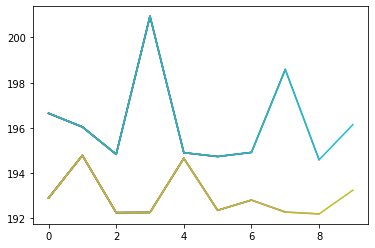

In [ ]:
import torch
import torch.nn as nn
import numpy as np
import argparse, time
import networkx as nx
import torch.nn.functional as F
from dgl.data import register_data_args, load_data
from dgl.nn.pytorch import GraphConv
from dgl import DGLGraph
#from gcn import *
#from cvae_box import *
#from data_utils import *
#from params import *
from IPython.display import clear_output
import matplotlib.pyplot as plt
import pdb
import wandb

%matplotlib inline

def main(args):

    if args.resume:
        wandb.init(project="boxvae")
    else:
        wandb.inir(project="boxvae",resume=True)


    # CUDA for PyTorch
    use_cuda = torch.cuda.is_available()
    device = torch.device("cuda:0" if use_cuda else "cpu")

    #augment dataset
    #data_augmentation('/home/sridhar/IIITH/Dataset/data/bin_data/')

    #open log file
    f = open(args.ls_path+'log.txt','a+')

    #create dataset
    train_dataset = GraphDataset_train(dir_path)
    val_dataset = GraphDataset_val(dir_path)
    #test_dataset = GraphDataset_test(dir_path)

    train_dataloader = torch.utils.data.DataLoader(train_dataset, batch_size=parameters['batch_size'],shuffle=True,num_workers=0,collate_fn=collate)
    val_dataloader = torch.utils.data.DataLoader(val_dataset,batch_size=parameters['batch_size'],shuffle=True,num_workers=0,collate_fn=collate)

    # Construct GCN
    gmodel = GCN(5, 32, 16)
    gmodel = gmodel.to(device)

    #Initialize CVAE
    cvae = CVAE(2*parameters['latent_size'],parameters['latent_size'],parameters['class_size'])
    cvae = cvae.to(device)

    #Initialize optimizer
    optimizer = torch.optim.Adam(list(gmodel.parameters())+list(cvae.parameters()),lr=0.0025)

    #if resuming from checkpoint, load the model and optimizer from checkpoint file
    #set epoch start from file and start of frange cycle icoef
    if args.resume == 1:
        checkpoint = torch.load(args.ls_path+args.checkpoint_name)
        gmodel.load_state_dict(checkpoint['GCN_state_dict'])
        cvae.load_state_dict(checkpoint['CVAE_state_dict'])
        optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
        epoch_start = checkpoint['epoch']
        icoef = checkpoint['icoef']
        print('Loading model from checkpoint')
    else:
        epoch_start = 1
        icoef = 0

    #frange_cycle coefficient list
    klw = frange_cycle_linear(10000)


    #init lists to store loss/epoch history for visualization
    train_loss = []
    val_loss = []


    if args.wandb:
    
        wandb.watch(gmodel)
        wandb.watch(cvae)

    for e in range(epoch_start,args.n_epochs+1):

        #sum of training and val losses
        r_loss = 0
        r_loss_val = 0
        iter = 0
        for X,G,ADJ,y,pp in train_dataloader:

            print('Train iter '+str(iter))
            iter += 1
            #get adjacency matrix of graph A
            adj = dgl.DGLGraph.adjacency_matrix(G)
            adj = adj.to(device)

            add_features(G,parameters['parts'],X)

            X = torch.from_numpy(X)
            #X = X.to(device)

            batch_size = X.shape[0] // parameters['parts']
            #print('Batch size: ',batch_size)

            y = torch.from_numpy(y)
            y = y.type('torch.LongTensor')

            #converting one-hot class vec to class indices
            y_new = torch.zeros(batch_size)
            for i in range(batch_size):
                y_new[i] = torch.argmax(y[i,:],axis=0)
            y_new = y_new.type('torch.LongTensor')
            y_new = y_new.to(device)

            pp = torch.from_numpy(pp)
            pp = pp.type('torch.FloatTensor')
            pp = pp.to(device)

            ADJ = torch.from_numpy(ADJ)
            ADJ = ADJ.to(device)

            #get inputs
            inputs = X.type('torch.FloatTensor')

            #GCN forward pass
            h, skip = gmodel(G,inputs,adj)
            h = torch.reshape(h,(-1,parameters['parts']*16))

            #VAE forward pass
            bbox,part_vec,A,class_,mu, logvar, z, cpp = cvae(h,skip,y,pp)
            bbox = torch.reshape(bbox,(-1,parameters['parts'],4))
            A = torch.reshape(A,(-1,parameters['parts'],parameters['parts']))
            A = A.to(device)

            #Compute training loss
            X = X.to(device)
            X = torch.reshape(X,(-1,parameters['parts'],5))
            X = X.type('torch.FloatTensor')
            bbox_loss = compute_ciou(X[:,:,1:],bbox) + box_loss(X[:,:,1:],bbox)
            kl_loss = torch.mean(mu**2 + torch.exp(logvar)**2 - 2*logvar - 1)
            bce_loss = torch.nn.BCELoss().to(device)
            categoricalCE_loss = torch.nn.CrossEntropyLoss().to(device)
            adj_loss = torch.mean(bce_loss(A,ADJ))
            class_ = class_.to(device)
            cls_loss = torch.mean(categoricalCE_loss(class_,y_new))
            part_vec = part_vec.to(device)
            pp_loss = torch.mean(bce_loss(part_vec,pp))
            reconstruction_loss = (bbox_loss.to(device) + cls_loss.to(device) + adj_loss.to(device) + pp_loss.to(device))*24*5 + klw[icoef]*kl_loss.to(device)
            r_loss = r_loss + reconstruction_loss
    
            reconstruction_loss.to(device)
            #print('Reconstruction Loss: ', type(reconstruction_loss))
            
            #pdb.set_trace()
    
            #clear previous gradients
            optimizer.zero_grad()

            #Backpropagation
            reconstruction_loss.backward()

            optimizer.step()
            
            

        r_loss = r_loss/2512 #avg train loss per epoch
        train_loss.append(r_loss)
        
        v_iter = 0
        
        with torch.no_grad():
            for X_val,G_val,ADJ_val,y_val,pp_val in val_dataloader:
                
                print("Val iter ",v_iter)
                v_iter += 1
                
                #get adjacency matrix of graph A
                adj_val = dgl.DGLGraph.adjacency_matrix(G_val)
                adj_val = adj_val.to(device)

                add_features(G_val,parameters['parts'],X_val)

                X_val = torch.from_numpy(X_val)
                #X_val = X_val.to(device)

                batch_size_val = X_val.shape[0] // parameters['parts']

                y_val = y_val.astype(float)
                y_val = torch.from_numpy(y_val)
                y_val = y_val.type('torch.LongTensor')

                #converting one-hot class vec to class indices
                y_new_val = torch.zeros(batch_size_val)
                for i in range(batch_size_val):
                    y_new_val[i] = torch.argmax(y_val[i,:],axis=0)
                y_new_val = y_new_val.type('torch.LongTensor')
                y_new_val = y_new_val.to(device)

                pp_val = torch.from_numpy(pp_val)
                pp_val = pp_val.type('torch.FloatTensor')
                pp_val = pp_val.to(device)

                ADJ_val = torch.from_numpy(ADJ_val)
                ADJ_val = ADJ_val.to(device)

                #get inputs
                inputs_val = X_val.type('torch.FloatTensor')
                

                #GCN forward pass
                h_val, skip_val = gmodel(G_val,inputs_val,adj_val)
                h_val = torch.reshape(h_val,(-1,parameters['parts']*16))

                #VAE forward pass
                bbox_val,part_vec_val,A_val,class__val,mu_val, logvar_val, z_val, cpp_val = cvae(h_val,skip_val,y_val,pp_val)
                bbox_val = torch.reshape(bbox_val,(-1,parameters['parts'],4))
                A_val = torch.reshape(A_val,(-1,parameters['parts'],parameters['parts']))
                A_val = A_val.to(device)

                #Compute val loss
                X_val = torch.reshape(X_val,(-1,parameters['parts'],5))
                X_val = X_val.type('torch.FloatTensor')
                bbox_loss_val = compute_ciou(X_val[:,:,1:],bbox_val) + box_loss(X_val[:,:,1:],bbox_val)
                kl_loss_val = torch.mean(mu_val**2 + torch.exp(logvar_val)**2 - 2*logvar_val - 1)
                bce_loss_val = torch.nn.BCELoss()
                categoricalCE_loss_val = torch.nn.CrossEntropyLoss()
                adj_loss_val = torch.mean(bce_loss(A_val,ADJ_val))
                class__val = class__val.to(device)
                cls_loss_val = torch.mean(categoricalCE_loss(class__val,y_new_val))
                part_vec_val = part_vec_val.to(device)
                pp_loss_val = torch.mean(bce_loss(part_vec_val,pp_val))
                reconstruction_loss_val = (bbox_loss_val + cls_loss_val + adj_loss_val + pp_loss_val)*24*5 + klw[icoef]*kl_loss_val
                r_loss_val = r_loss_val + reconstruction_loss_val
                #break

        r_loss_val = r_loss_val/332
        val_loss.append(r_loss_val)

        clear_output()

        #print train, val loss after every epoch
        print('Epoch ',str(e))
        print('Training loss:',r_loss,'bbox_loss:',bbox_loss,'cls_loss:',cls_loss,'adj_loss:',adj_loss,'pp_loss:',pp_loss,'kl_loss:',kl_loss)
        print('Validation loss:',r_loss_val,'bbox_loss_val:',bbox_loss_val,'cls_loss_val:',cls_loss_val,'adj_loss_val:',adj_loss_val,'pp_loss_val:',pp_loss_val,'kl_loss_val:',kl_loss_val)
        print('KL coeff:',klw[icoef])
        plt.plot(np.asarray(train_loss))
        plt.plot(np.asarray(val_loss))

        if args.wandb:

            wandb.log({'Training loss:':r_loss.item(),'bbox_loss:':bbox_loss.item(),
                    'cls_loss:':cls_loss.item(),'adj_loss:':adj_loss.item(),
                    'pp_loss:':pp_loss.item(),'kl_loss:':kl_loss.item(),
                    'Validation loss:':r_loss_val.item(),'bbox_loss_val:':bbox_loss_val.item(),
                    'cls_loss_val:':cls_loss_val.item(),'adj_loss_val:':adj_loss_val.item(),
                    'pp_loss_val:':pp_loss_val.item(),'kl_loss_val:':kl_loss_val.item(),
                    'kl_coeff:':klw[icoef]
                    })



        #write loss info into log file
        f.write('Epoch '+str(e)+'\n')
        f.write('Training loss: '+str(r_loss.item())+'bbox_loss: '+str(bbox_loss.item())+'cls_loss: '+str(cls_loss.item())+'adj_loss: '+str(adj_loss.item())+'pp_loss: '+str(pp_loss.item())+'kl_loss: '+str(kl_loss.item()*klw[icoef])+'\n')
        f.write('Validation loss: '+str(r_loss_val.item())+'bbox_loss_val: '+str(bbox_loss_val.item())+'cls_loss_val: '+str(cls_loss_val.item())+'adj_loss_val: '+str(adj_loss_val.item())+'pp_loss_val: '+str(pp_loss_val.item())+'kl_loss_val: '+str(kl_loss_val.item()*klw[icoef])+'\n')
        f.write('KL coeff: '+str(klw[icoef])+'\n')
        f.write('-----------------------------'+'\n')


        #freeze klw schedule if loss diff above threshold
        if kl_loss>0.5 and abs(bbox_loss - bbox_loss_val) < 0.2:
            icoef = icoef + 1

            

        #save model and optimizer every x epochs - checkpoint
        if e % args.save_every == 0:
            print('Saving checkpoint')
            torch.save({
            'epoch': e+1,
            'icoef': icoef,
            'GCN_state_dict': gmodel.state_dict(),
            'CVAE_state_dict': cvae.state_dict(),
            'optimizer_state_dict': optimizer.state_dict()
            }, args.ls_path+'model_'+str(e)+'.pth')


#if __name__ == '__main__':
parser = argparse.ArgumentParser(description='BoxVAE')
register_data_args(parser)
parser.add_argument("--n-epochs", type=int, default=2,
        help="number of training epochs")
parser.add_argument("--save-every", type=int, default=2)
parser.add_argument("--ls-path", type=str, default='/content/drive/My Drive/IIITH/OPALNet/checkpoints')
parser.add_argument("--checkpoint-name", type=str)
parser.add_argument("--resume",type=int,default=0,
        help="Resuming training from a checkpoint")
parser.add_argument("--wandb",type=int,default=1)
args = parser.parse_args(args=['--ls-path','/content/drive/My Drive/IIITH/OPALNet/checkpoints/','--save-every','10','--n-epochs','200','--checkpoint-name','model_190.pth','--resume','1','--wandb','1'])


main(args)


## **Visualizing bbox**

In [ ]:
class_v = {}
X_train = {}
adj_train = {}
canvas_size = 50

class_dic = {'cow':0,'sheep':1,'bird':2,'person':3,'cat':4,'dog':5,'horse':6,'aeroplane':7,'motorbike':8,'bicycle':9,'car':10}

for object_name in object_names:
    with open('/content/drive/My Drive/IIITH/OPALNet/raw_dataset/'+object_name+'_part_separated_bbx', 'rb') as f:
      o_bbx = pickle.load(f)

    train_set_limit = int(len(o_bbx)*(75/100))
    validation_set_limit = int(len(o_bbx)*(10/100))
    test_set_limit = int(len(o_bbx)*(15/100))

    #label = o_labels[0:train_set_limit]
    #box = o_bbx[0:train_set_limit]
    #mask = o_masks[0:train_set_limit]
    #image = o_images[0:train_set_limit]
    
    #label = o_labels[train_set_limit:train_set_limit+validation_set_limit]
    #box = o_bbx[train_set_limit:train_set_limit+validation_set_limit]
    #mask = o_masks[train_set_limit:train_set_limit+validation_set_limit]
    #image = o_images[train_set_limit:train_set_limit+validation_set_limit]

    #label = o_labels[train_set_limit+validation_set_limit::]
    box = o_bbx[train_set_limit+validation_set_limit::]
    #mask = o_masks[train_set_limit+validation_set_limit::]
    #image = o_images[train_set_limit+validation_set_limit::]

    max_parts = 24

    """flipped_label = []
    flipped_box = []
    flipped_mask = []
    flipped_image = []

    angle = 3

    for l,b,m,i in zip(label,  box, mask, image):
        ll, bb, mm, ii = flip_data_instance(l,b,m,i)
        flipped_label.append(ll)
        flipped_box.append(bb)
        flipped_mask.append(mm)
        flipped_image.append(ii)

    flipped_label = np.asarray(flipped_label)
    flipped_box =   np.asarray(flipped_box )
    flipped_mask =  np.asarray(flipped_mask)
    flipped_image = np.asarray(flipped_image)

    label = np.concatenate((label, flipped_label), axis = 0)
    box = np.concatenate((box, flipped_box), axis = 0)
    mask = np.concatenate((mask, flipped_mask), axis = 0)
    image = np.concatenate((image, flipped_image), axis = 0)

    rt_box = []
    for bx, mx in zip(box, mask):
      bbxx1 = render_mask(bx,mx,angle)
      bbxx2 = render_mask(bx,mx,-angle)
      rt_box.append(bbxx1)
      rt_box.append(bbxx2)

    rt_box = np.asarray(rt_box)
    box = box = np.concatenate((box, rt_box), axis = 0)"""

    centre_box = []
    for bx in box:
      centre_box.append(centre_object(bx, (canvas_size,canvas_size)))

    centre_box = np.asarray(centre_box)
    box = centre_box

    """scale_box = []
    for bx in box:
      a,b,c,d = scale(bx, 0.01)
      scale_box.append(a)
      scale_box.append(b)
      scale_box.append(c)
      scale_box.append(d)

    scale_box = np.asarray(scale_box)
    box = np.concatenate((box, scale_box), axis = 0)"""

    box = append_labels(box)
    box = pad_along_axis(box, 24, axis=1)
    
    numparts = 24

    final_input = []

    for i,x in enumerate(box):
      l = numparts
      temp = np.zeros((l,l), dtype=np.float32)
      for j in range(l):
        temp[j][j] = 1
        if x[j][0] == 1:
          for y in tree[object_name][j]:
            if x[y][0] == 1:
              temp[j][y] = 1
              temp[y][j] = 1
      final_input.append(temp)
    adj = np.asarray(final_input)


    class_v[object_name] = (np.asarray([np.eye(10)[class_dic[object_name]]]*len(box)))
    X_train[object_name] = (box)
    adj_train[object_name] = (adj)

In [ ]:
def arrangement(a, object_name):
    if object_name=='cow' or object_name=='sheep':
        p = [20,22,21,23,10,11,19,18,13,12,14,16,15,17,8,9,0,7,3,4,5,6,1,2]
    elif object_name=='bird':
        p = [ 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23,  4, 12,  8,  9, 10, 11,5,  6,  7,  0,  1,  2,  3 ]
    elif object_name=='person':
        p = [ 10,11,19,22,18,21,20,23,13,16,12,15,14,17,9,0,7,8,5,6,1,2,3,4 ]
    elif object_name=='cat':
        p = [ 17,18,19,20,21,22,23,6, 7, 16, 8, 9, 10, 11, 12, 13, 14, 15, 0, 1, 2, 3, 4, 5]
    elif object_name=='dog':
        p = [ 18,19,20,21,22,23,6, 7, 16, 8, 9, 10, 11, 12, 13, 14, 15, 0, 17,1, 2, 3, 4, 5]
    elif object_name=='horse':
        p = [ 22,21,23,10,11,18,13,12,14,16,15,17,8,9,0,7,3,4,5,6,19,20,1,2]
    elif object_name=='aeroplane':
        p = [ 0,20,22,21,23,10,11,19,18,13,12,14,16,15,17,8,9,7,3,4,5,6,1,2]
    elif object_name=='motorbike':
        p = [ 15,20,22,21,23,10,11,19,18,13,12,14,16,17,8,9,0,7,3,4,5,6,1,2 ]
    elif object_name=='bicycle':
        p = [22,21,23,10,11,18,13,12,14,16,15,17,8,9,0,7,3,4,5,6,19,20,1,2 ]
    else:
      print("error")
    return a[p]

## **Sample and generate bbox layout**

X_in.shape (32, 24, 5)
clvec.shape torch.Size([32, 10])
pp.shape torch.Size([32, 24])
bbox.shape (32, 96)
pos.shape (24,)
pos.shape (24,)


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:82: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


pos.shape (24,)
pos.shape (24,)
pos.shape (24,)
pos.shape (24,)
pos.shape (24,)
pos.shape (24,)
pos.shape (24,)
pos.shape (24,)
pos.shape (24,)
pos.shape (24,)
pos.shape (24,)
pos.shape (24,)
pos.shape (24,)
pos.shape (24,)
pos.shape (24,)
pos.shape (24,)
pos.shape (24,)
pos.shape (24,)
pos.shape (24,)
pos.shape (24,)


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:76: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


pos.shape (24,)
pos.shape (24,)
pos.shape (24,)
pos.shape (24,)
pos.shape (24,)
pos.shape (24,)
pos.shape (24,)
pos.shape (24,)
pos.shape (24,)
pos.shape (24,)
X_in.shape (32, 24, 5)
clvec.shape torch.Size([32, 10])
pp.shape torch.Size([32, 24])
bbox.shape (32, 96)
pos.shape (24,)
pos.shape (24,)
pos.shape (24,)
pos.shape (24,)
pos.shape (24,)
pos.shape (24,)
pos.shape (24,)
pos.shape (24,)
pos.shape (24,)
pos.shape (24,)
pos.shape (24,)
pos.shape (24,)
pos.shape (24,)
pos.shape (24,)
pos.shape (24,)
pos.shape (24,)
pos.shape (24,)
pos.shape (24,)
pos.shape (24,)
pos.shape (24,)
pos.shape (24,)
pos.shape (24,)
pos.shape (24,)
pos.shape (24,)
pos.shape (24,)
pos.shape (24,)
pos.shape (24,)
pos.shape (24,)
pos.shape (24,)
pos.shape (24,)
pos.shape (24,)
pos.shape (24,)
X_in.shape (32, 24, 5)
clvec.shape torch.Size([32, 10])
pp.shape torch.Size([32, 24])
bbox.shape (32, 96)
pos.shape (24,)
pos.shape (24,)
pos.shape (24,)
pos.shape (24,)
pos.shape (24,)
pos.shape (24,)
pos.shape (24,)
pos.

RuntimeError: ignored

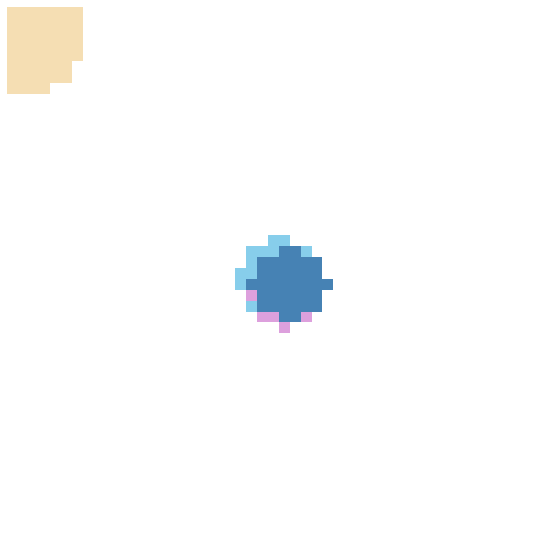

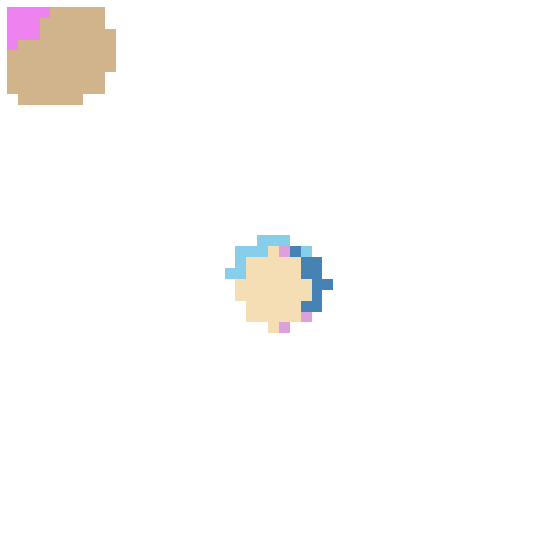

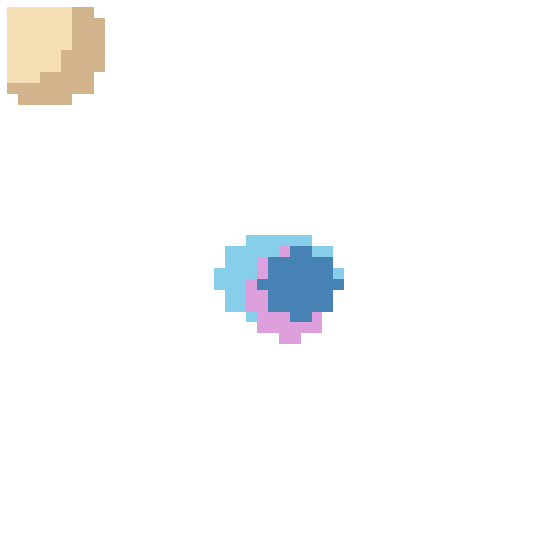

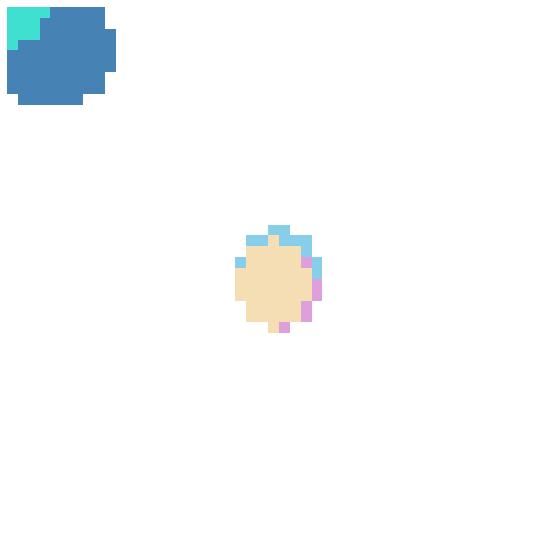

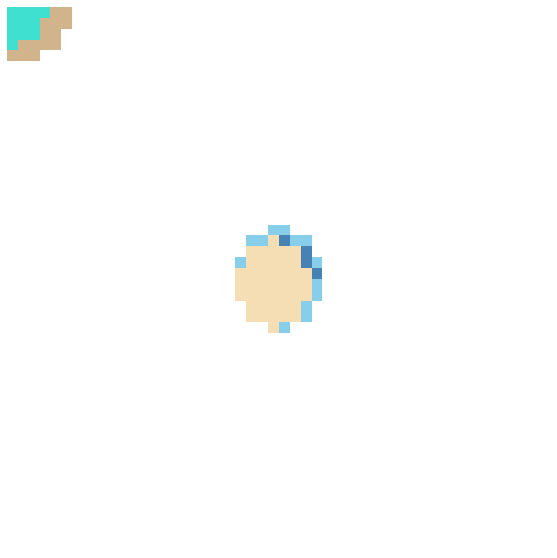

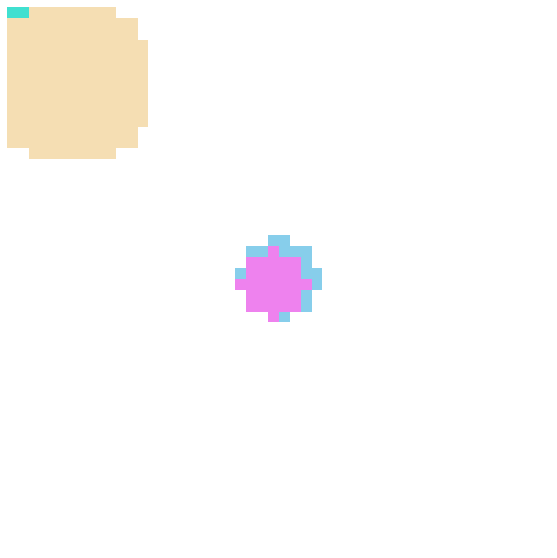

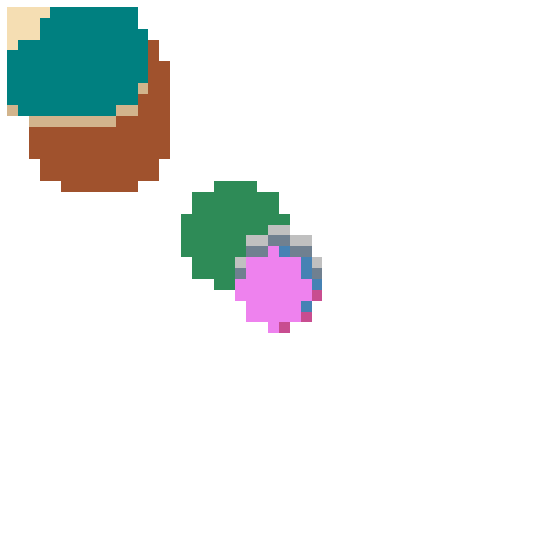

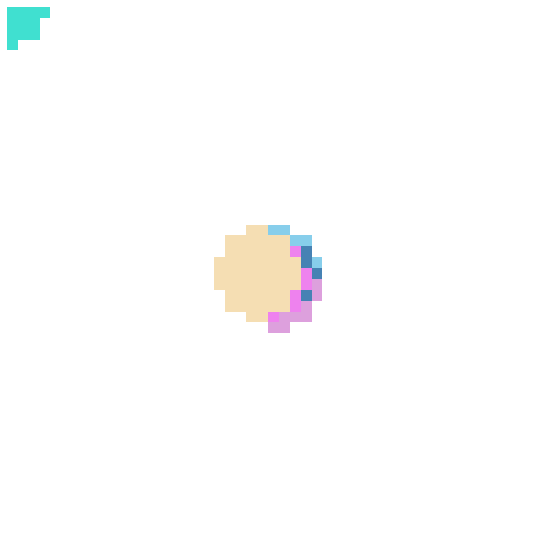

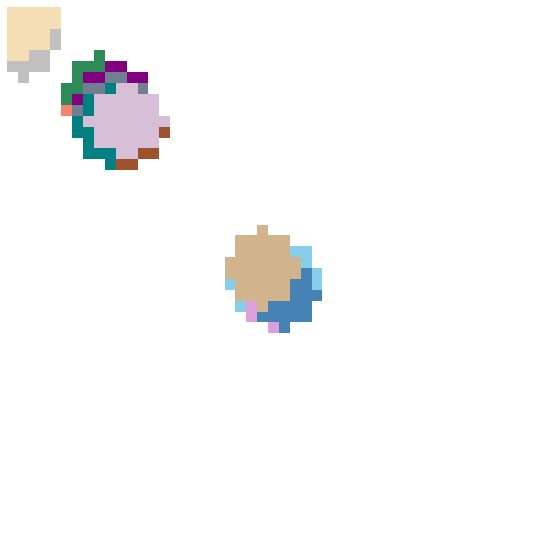

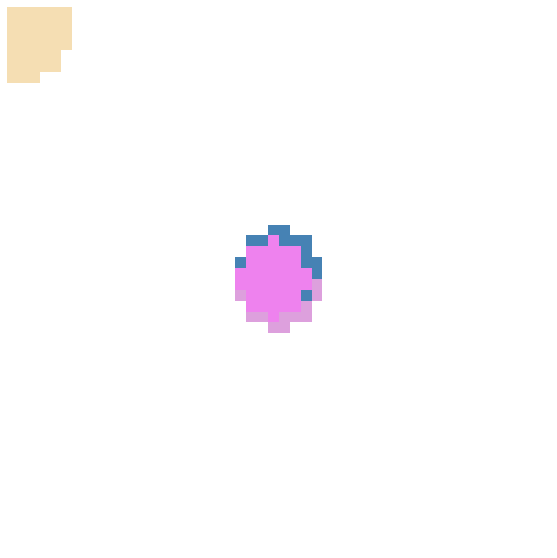

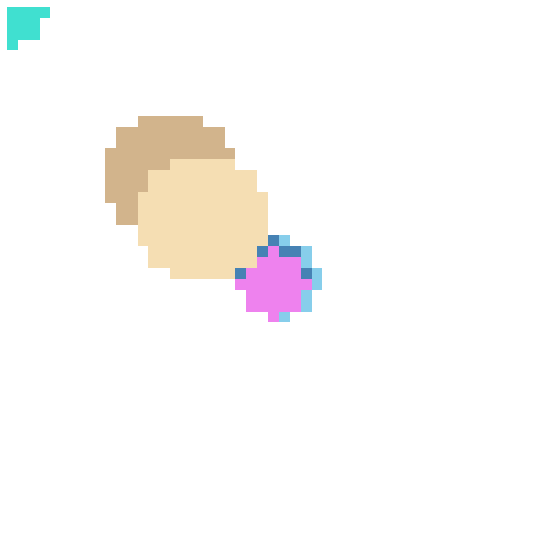

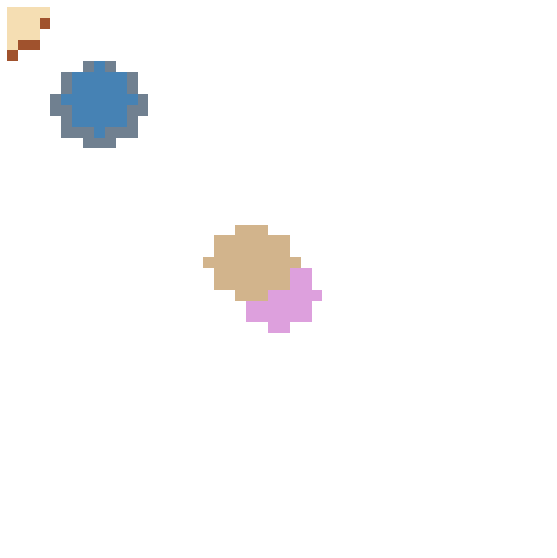

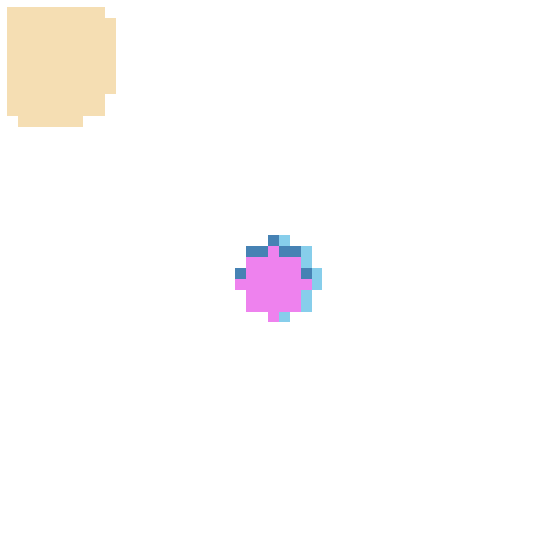

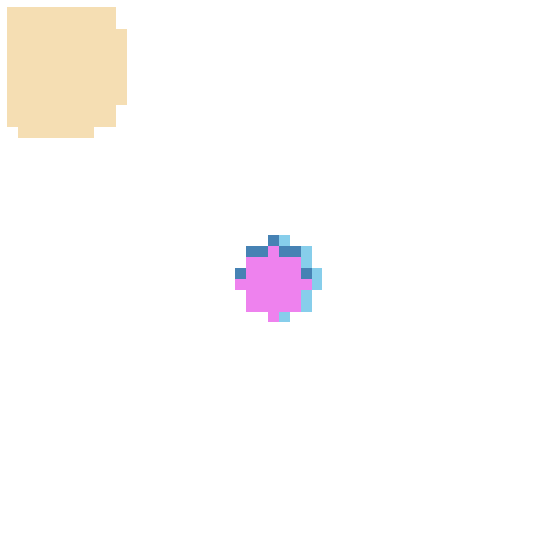

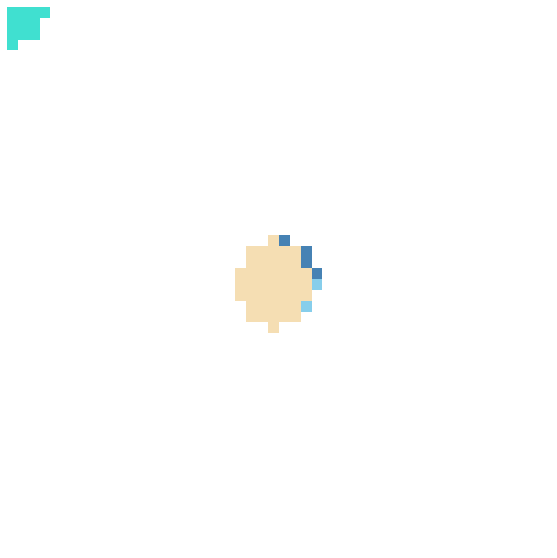

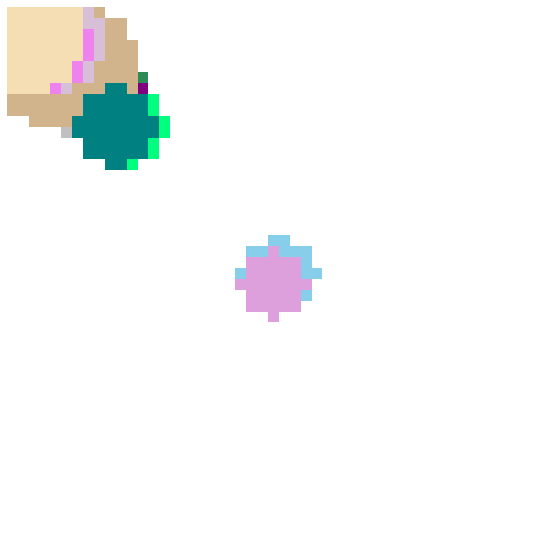

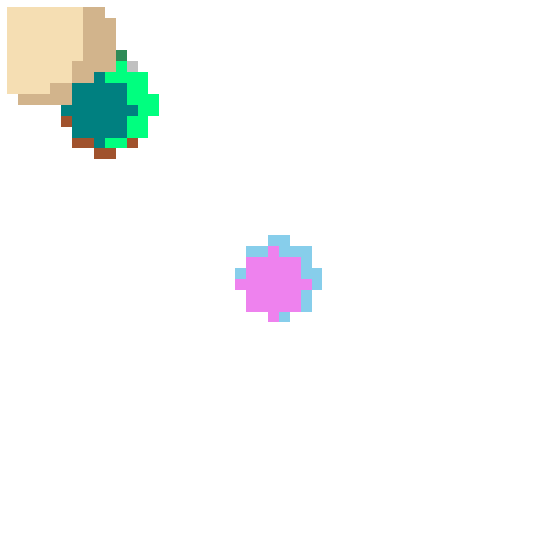

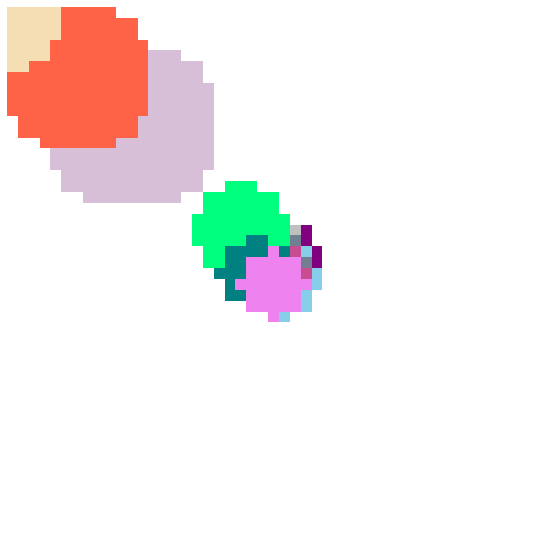

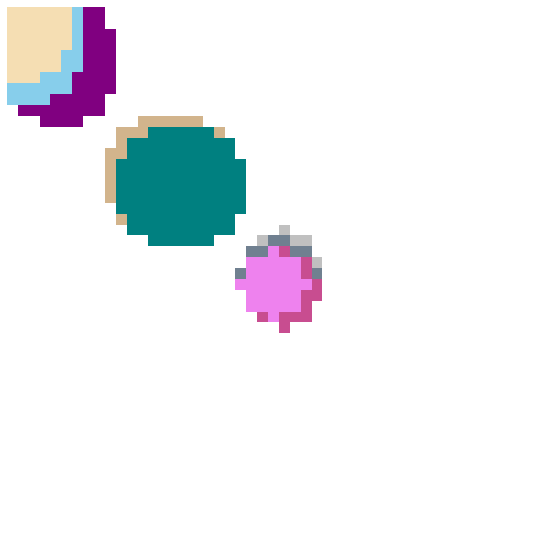

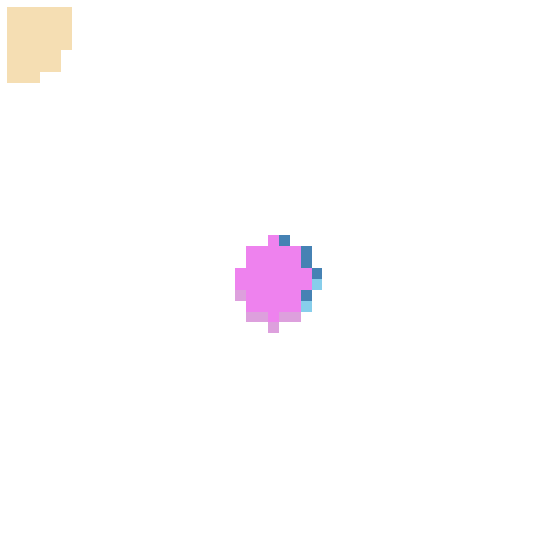

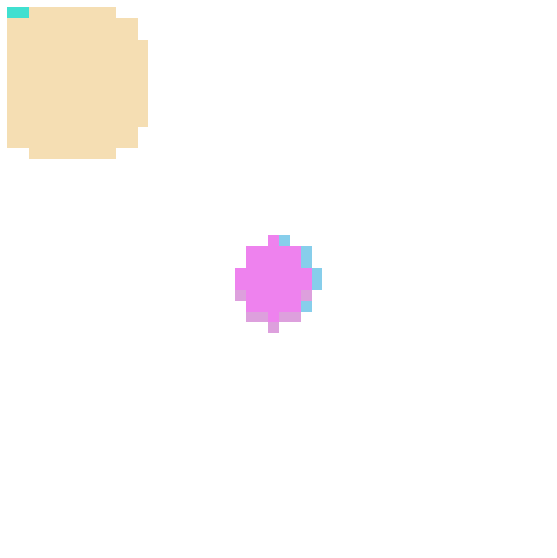

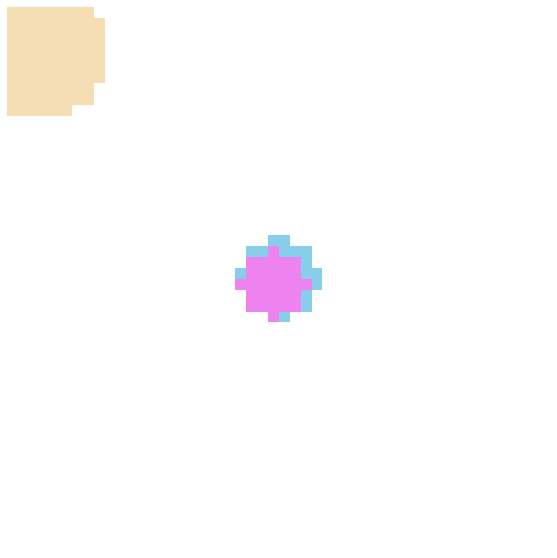

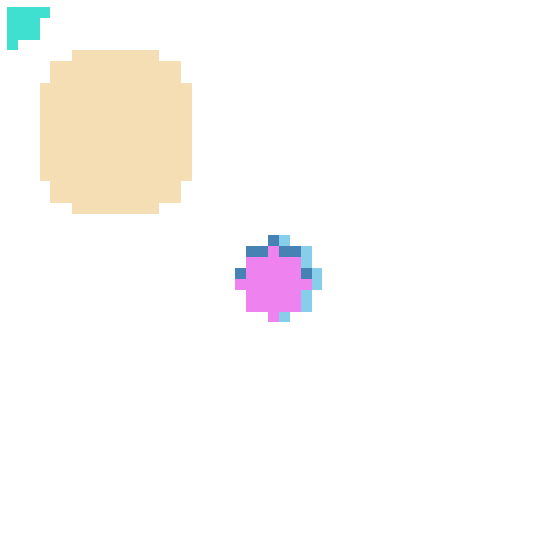

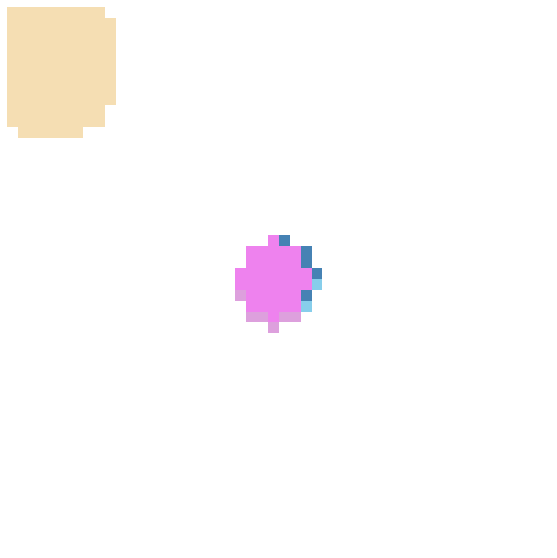

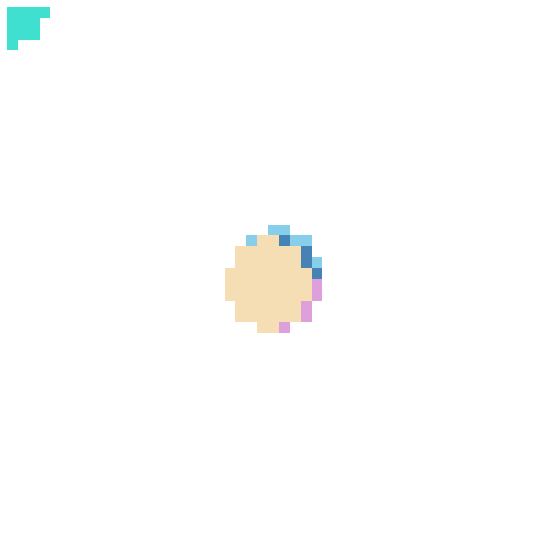

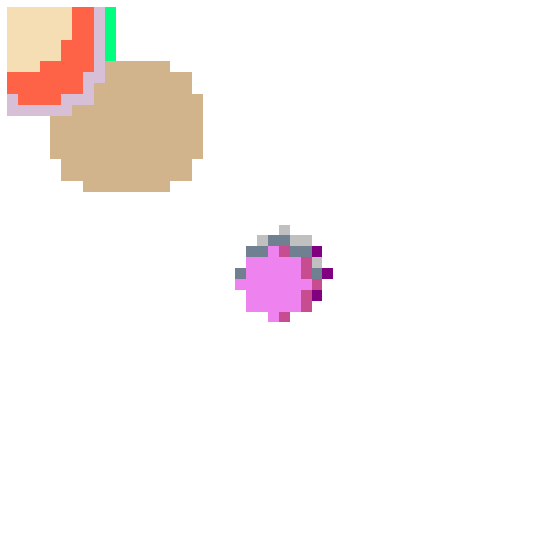

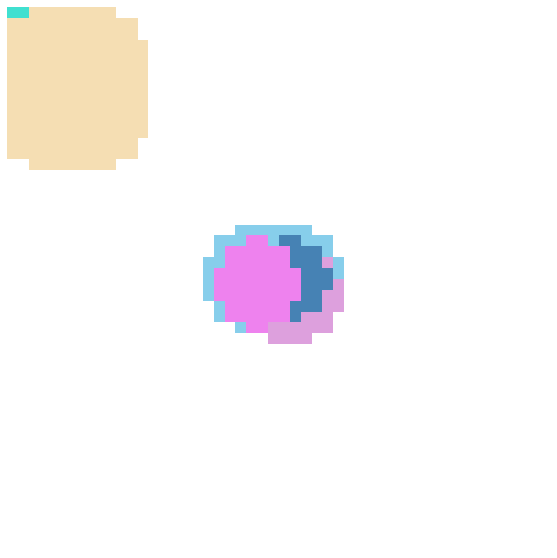

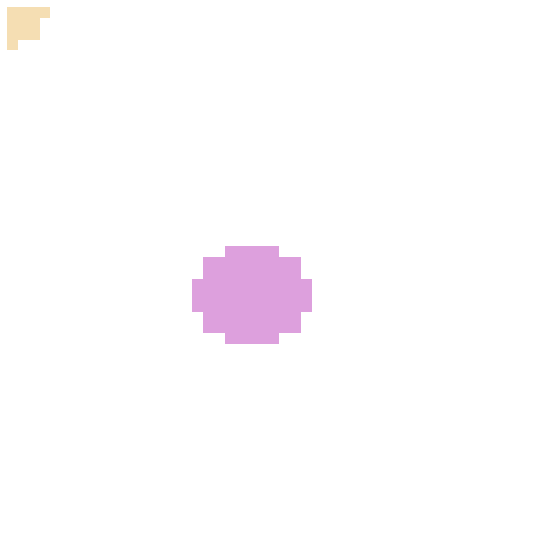

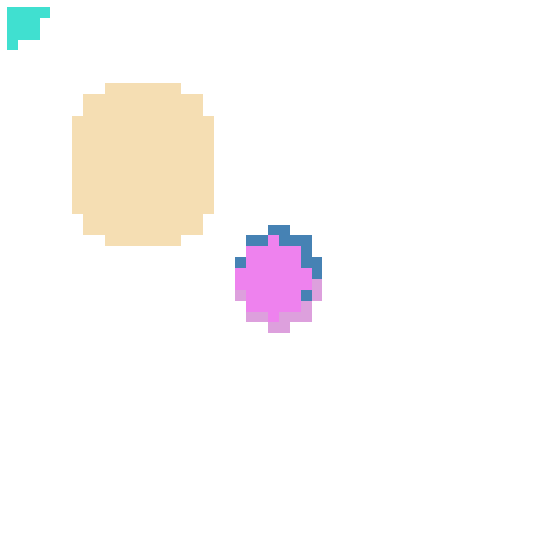

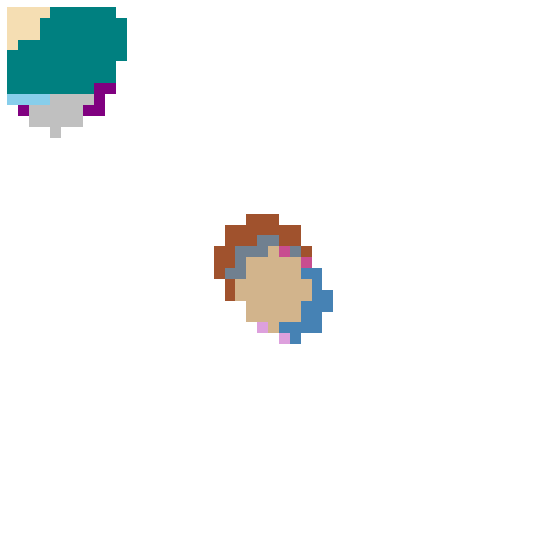

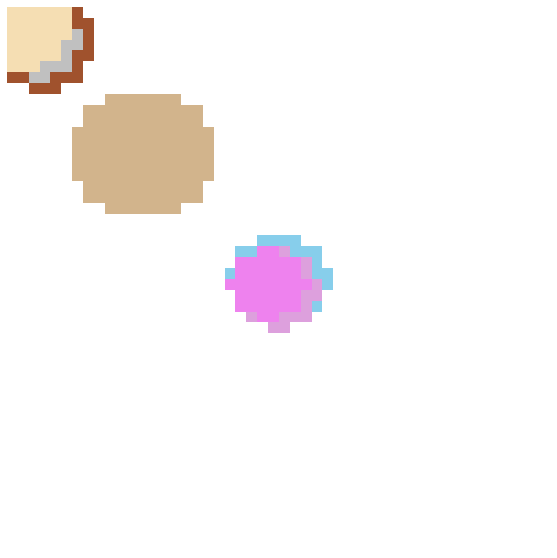

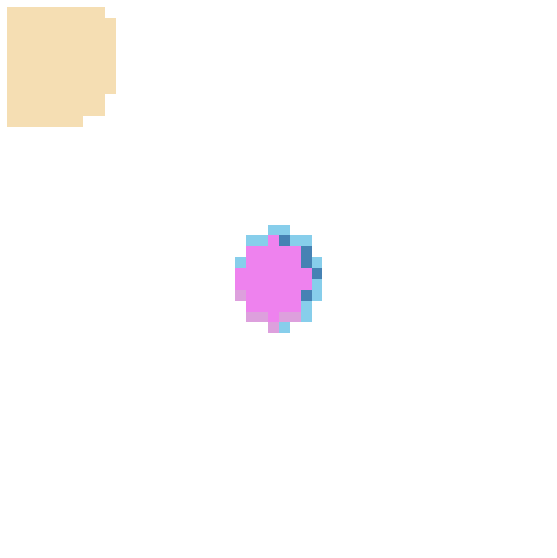

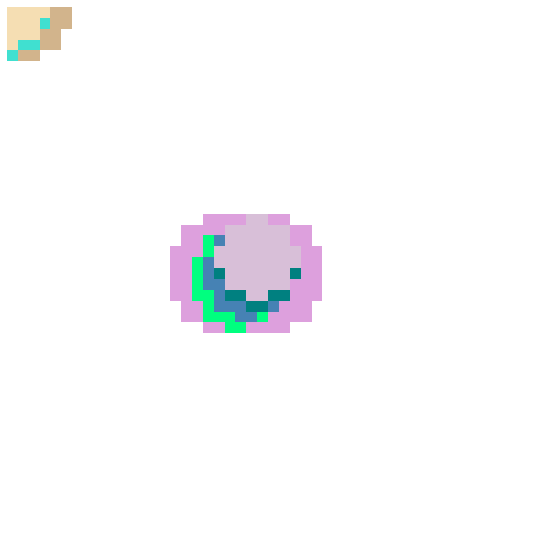

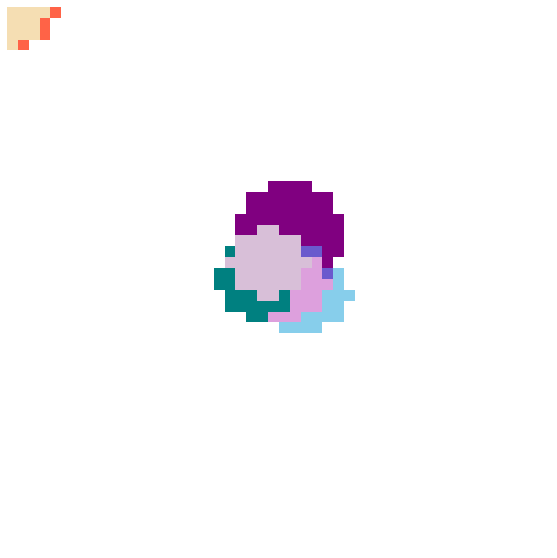

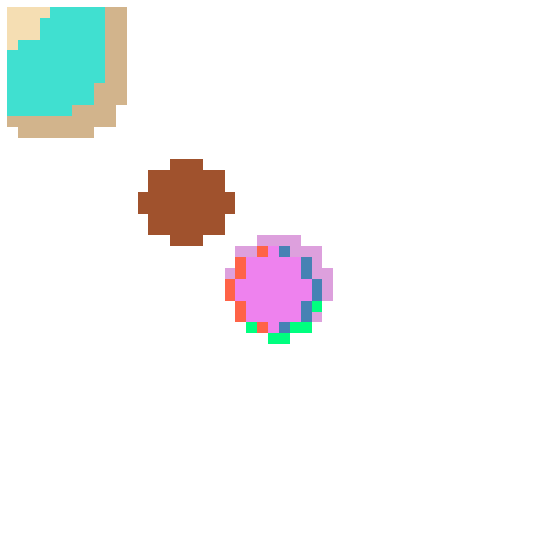

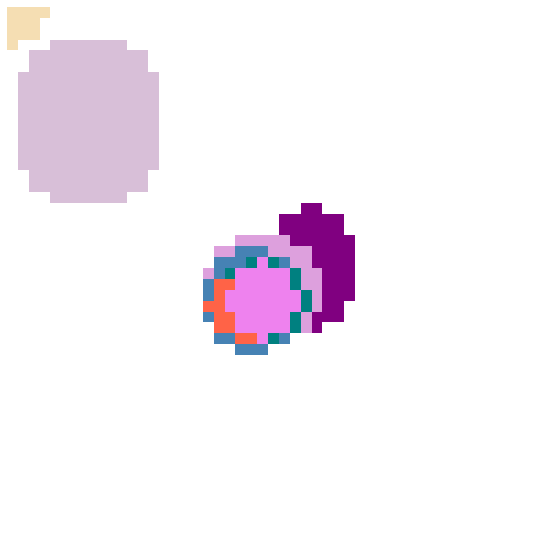

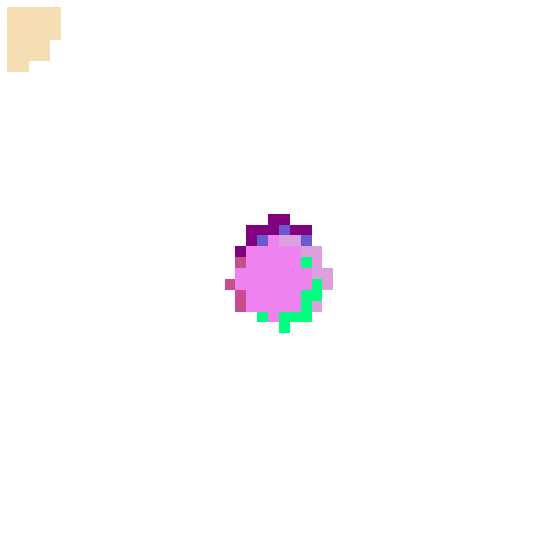

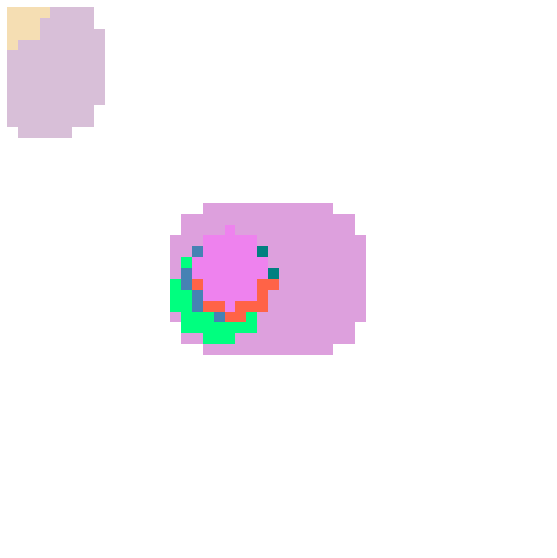

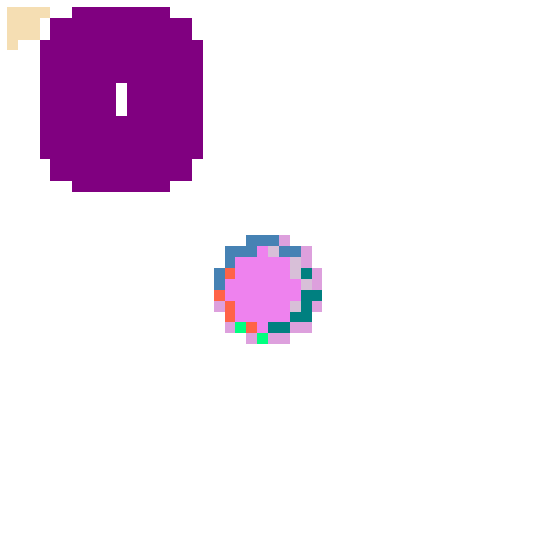

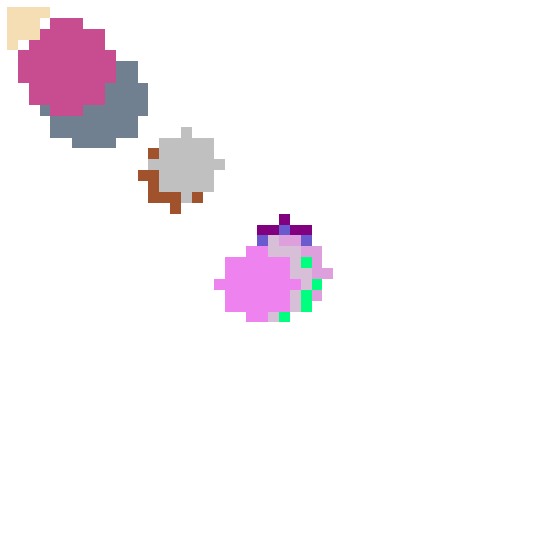

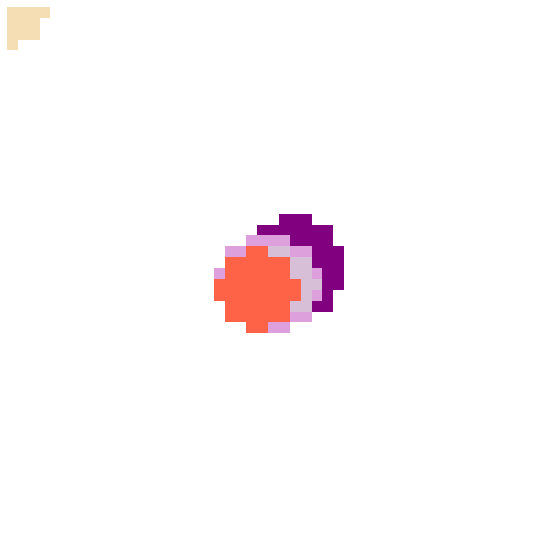

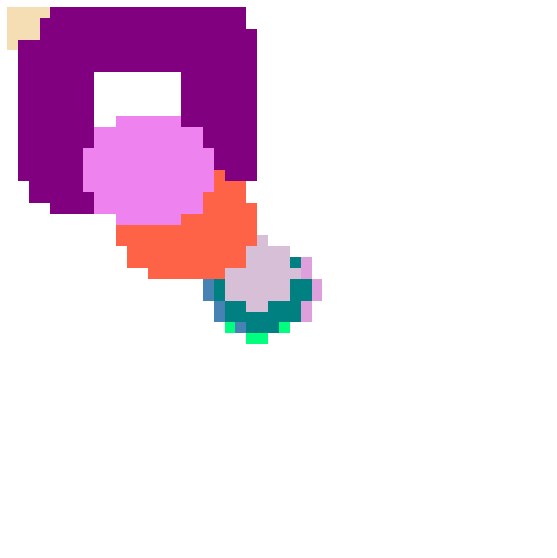

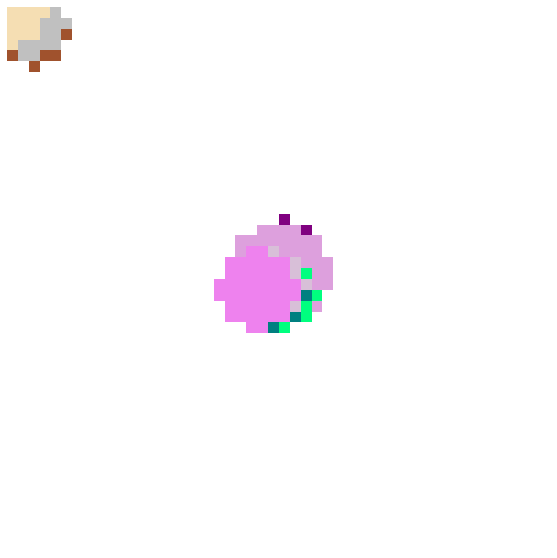

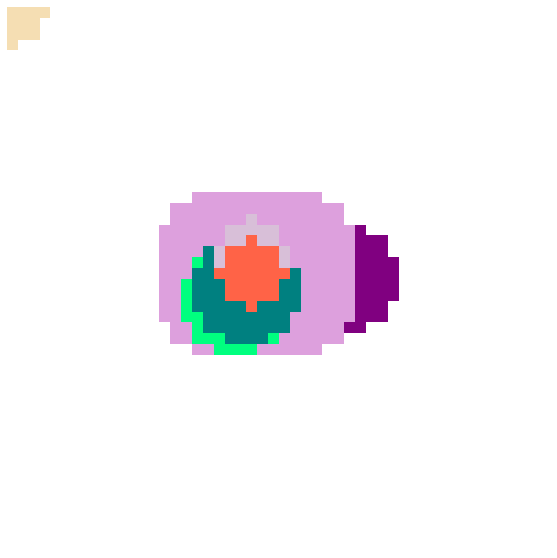

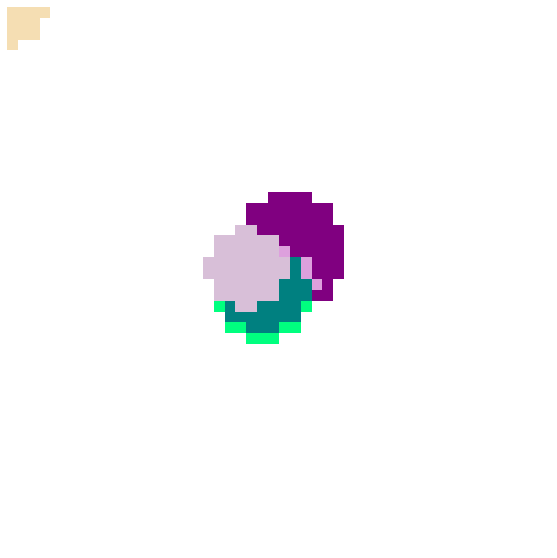

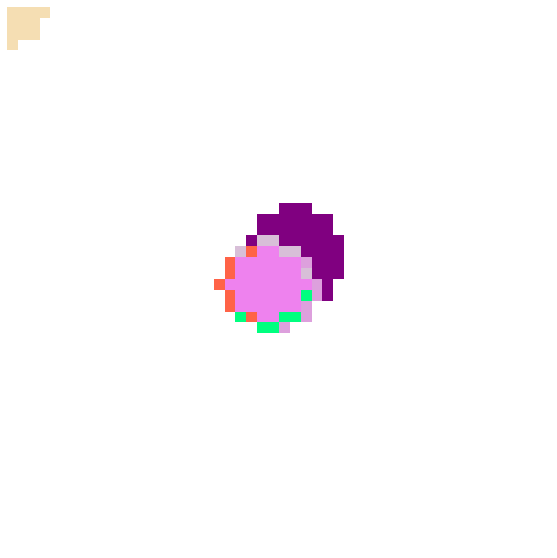

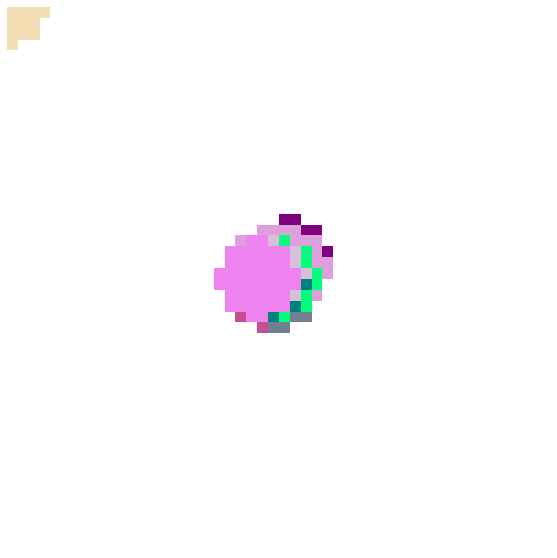

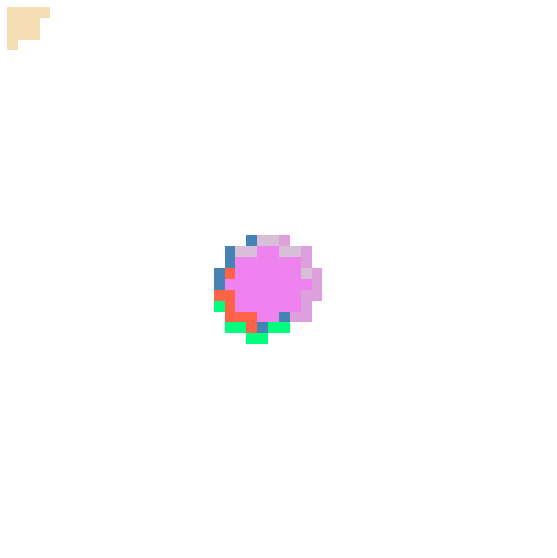

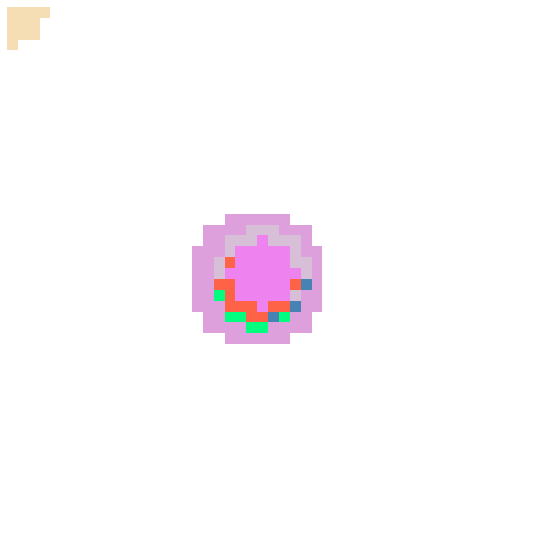

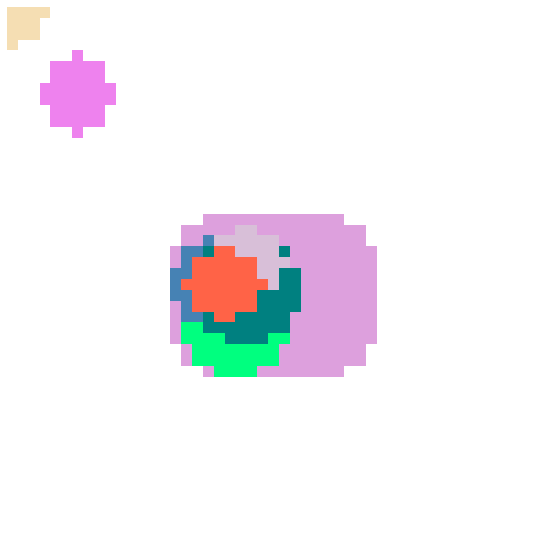

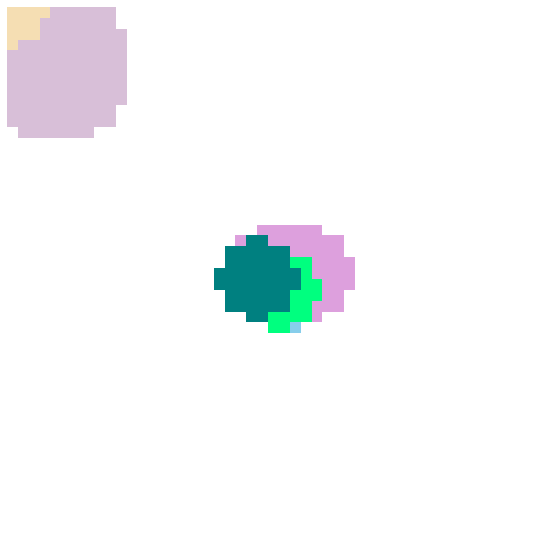

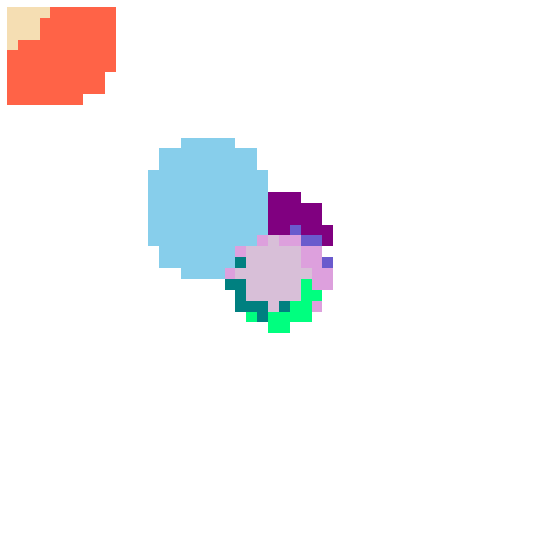

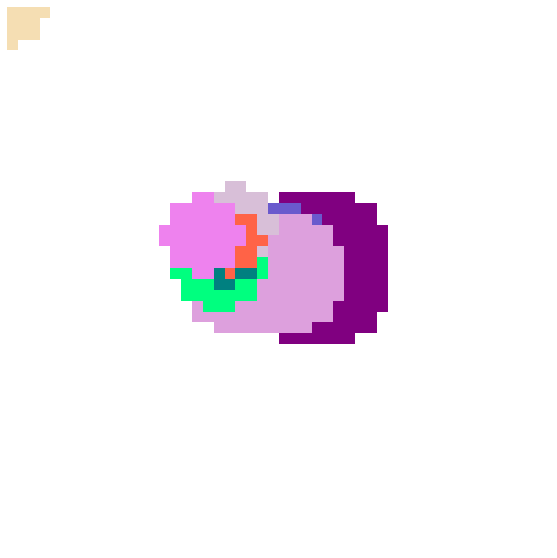

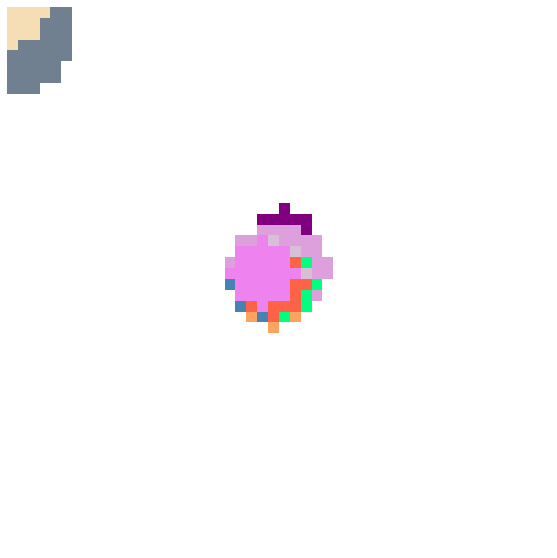

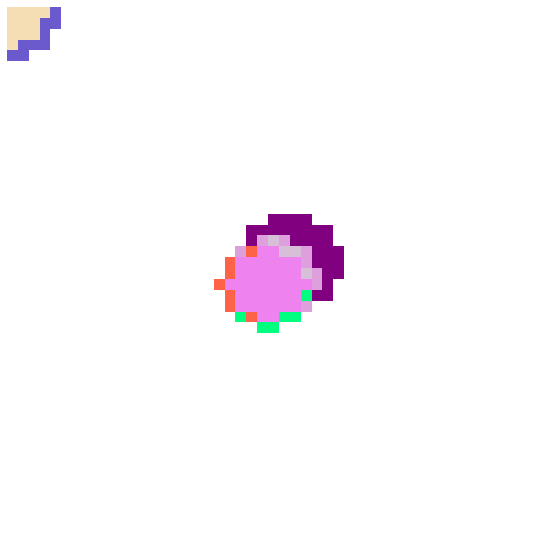

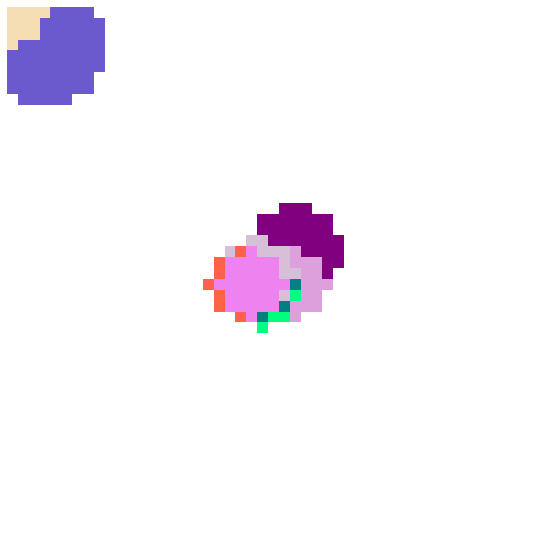

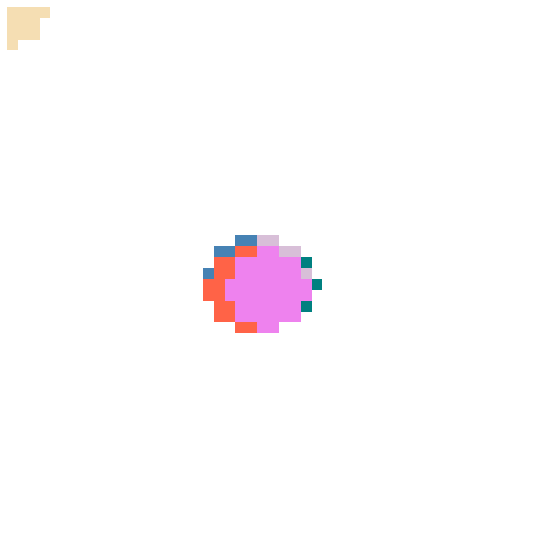

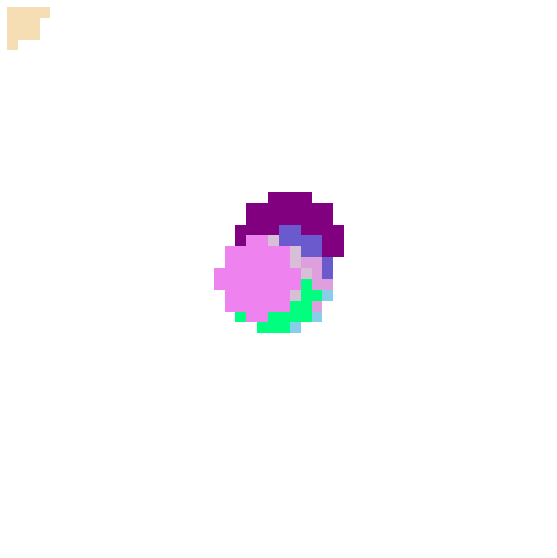

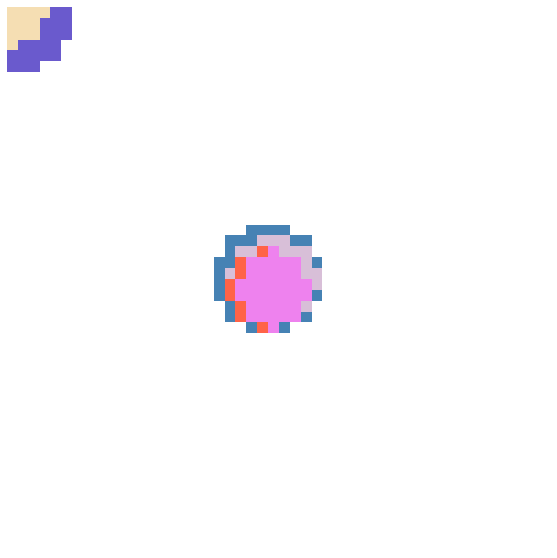

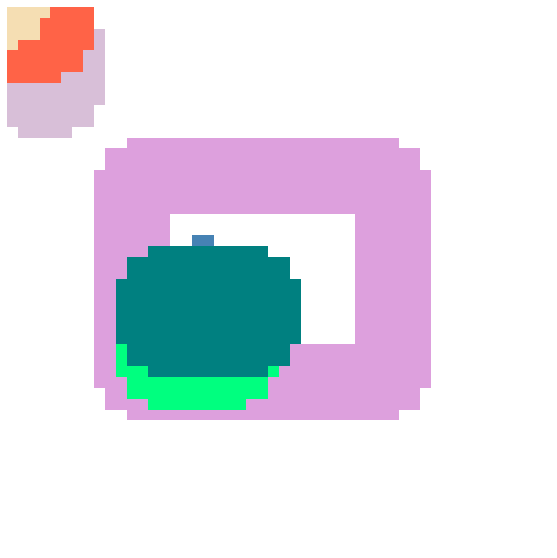

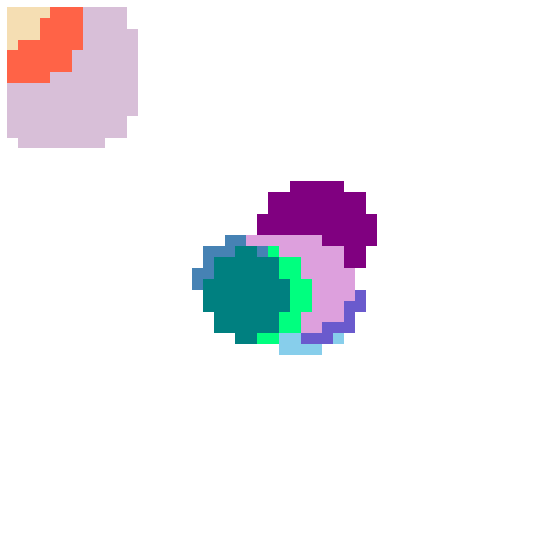

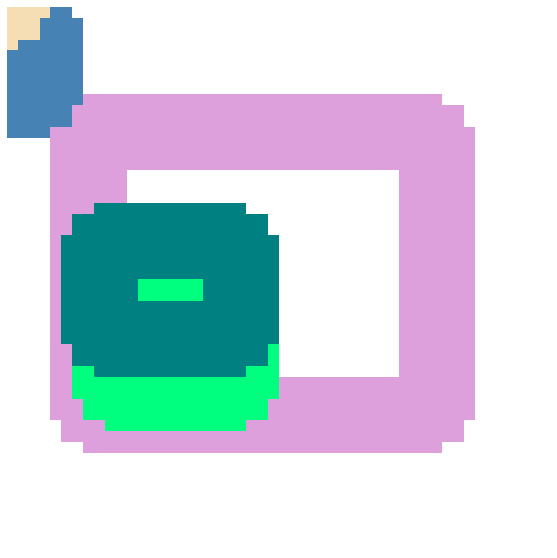

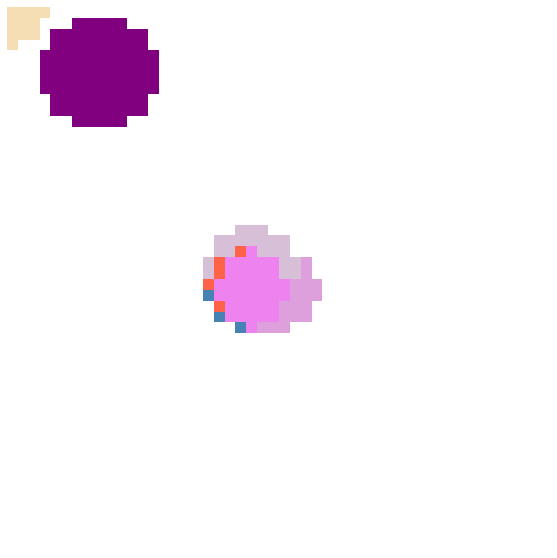

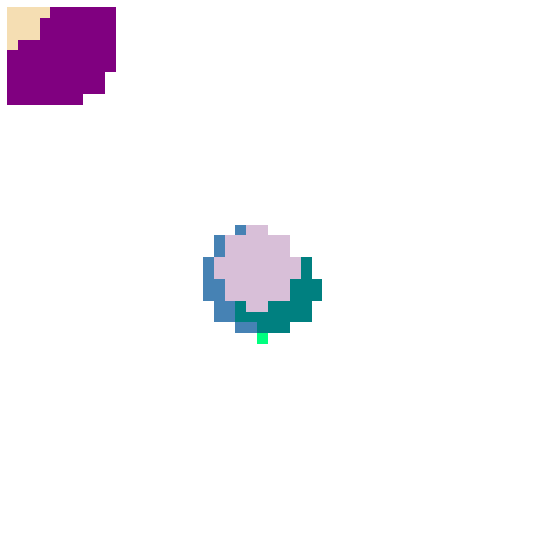

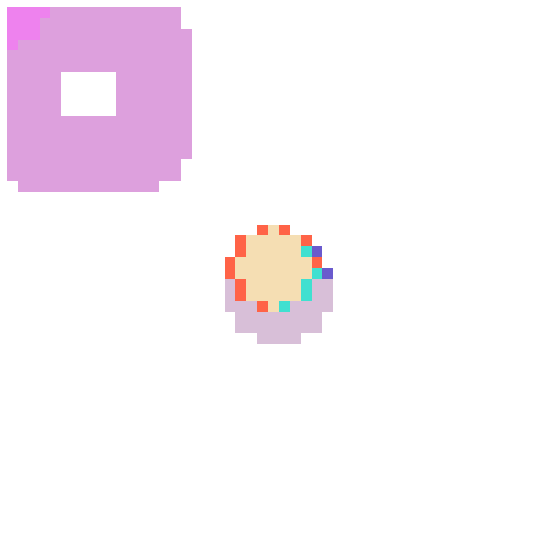

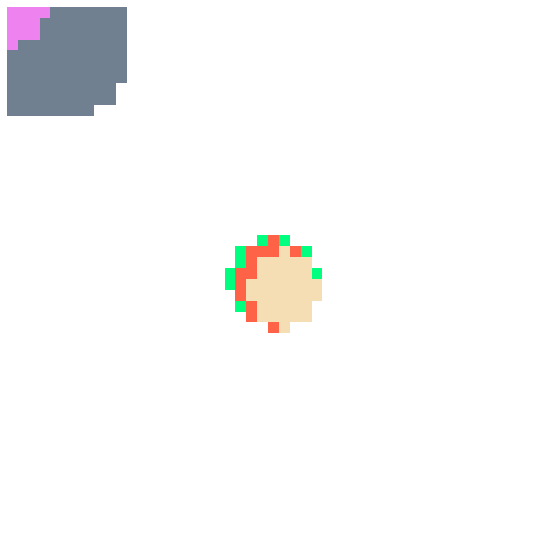

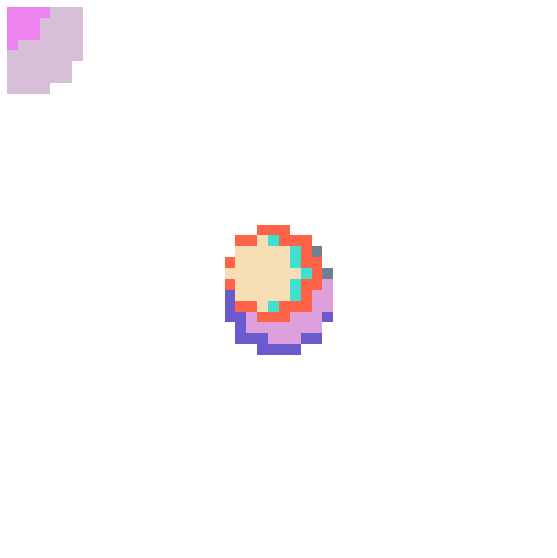

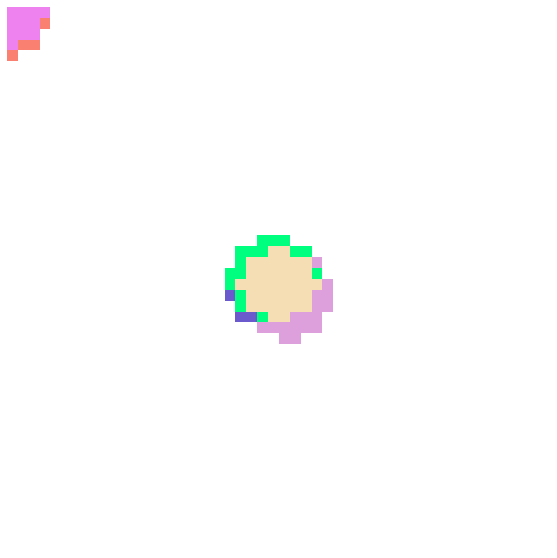

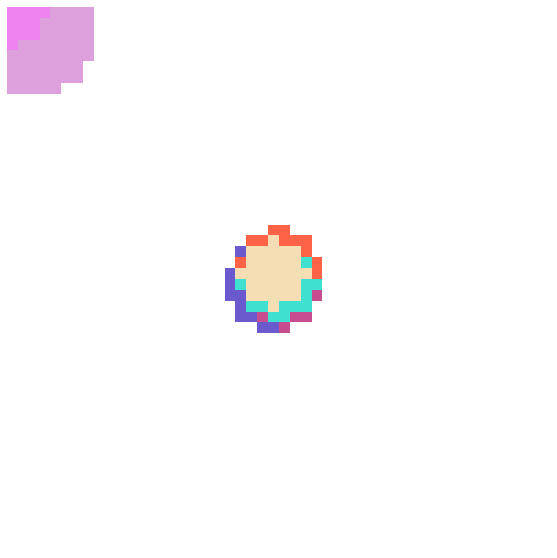

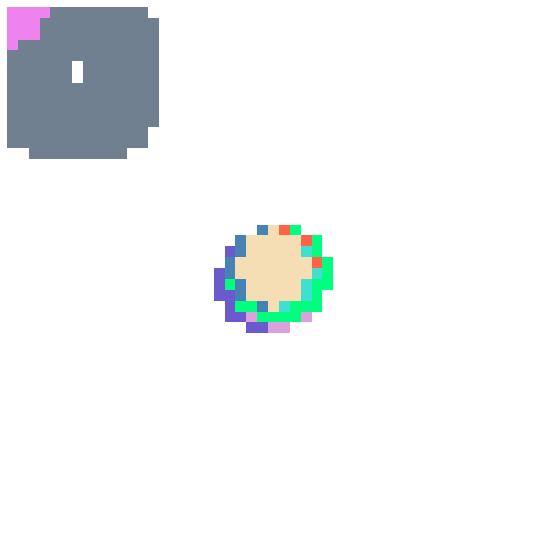

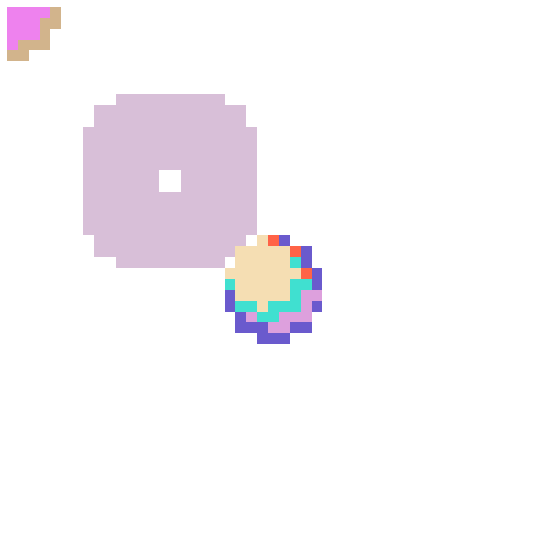

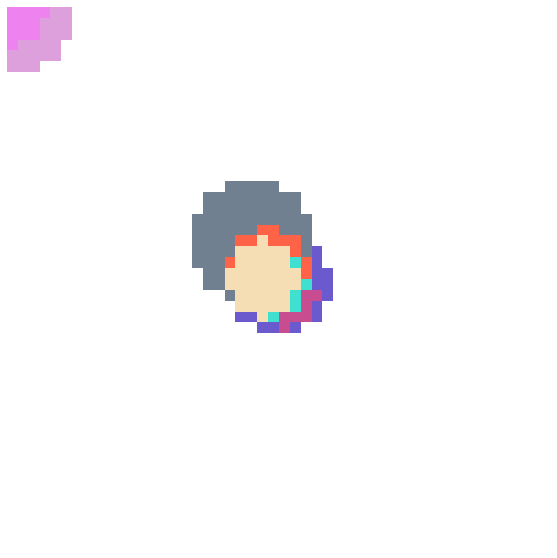

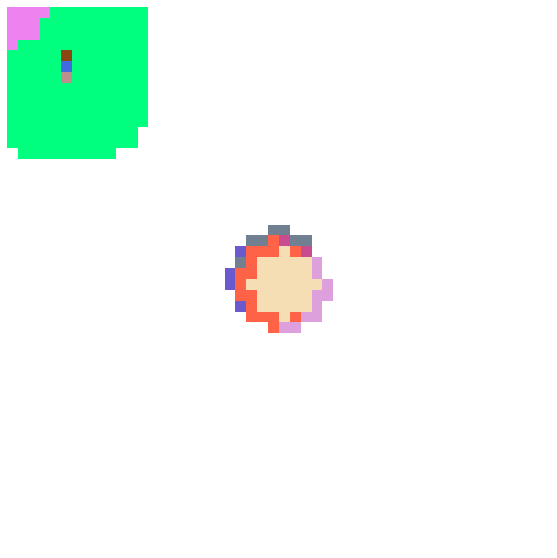

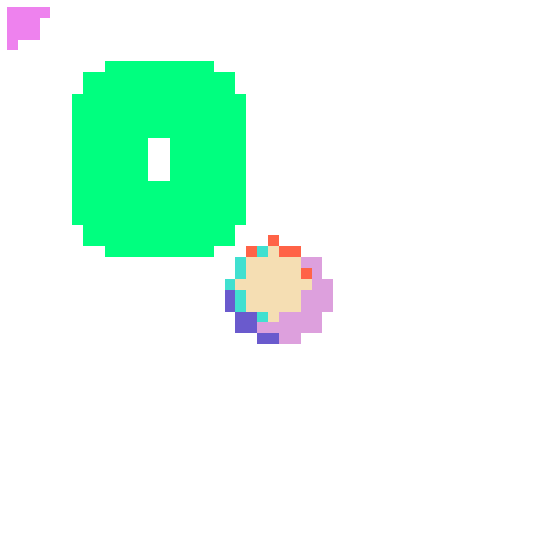

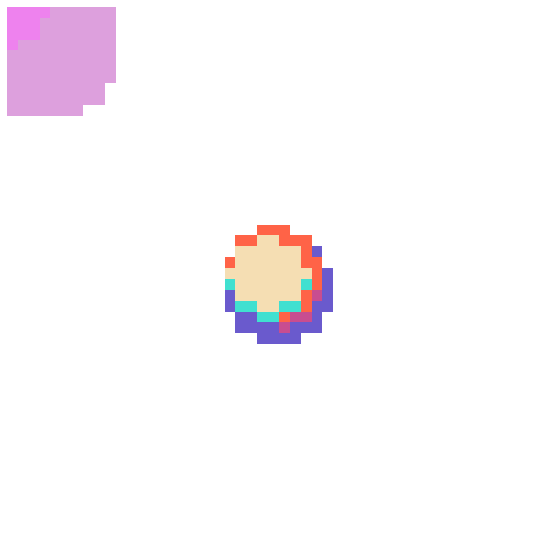

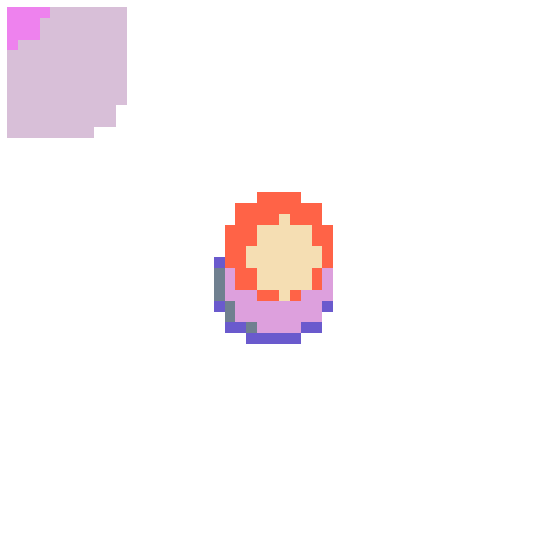

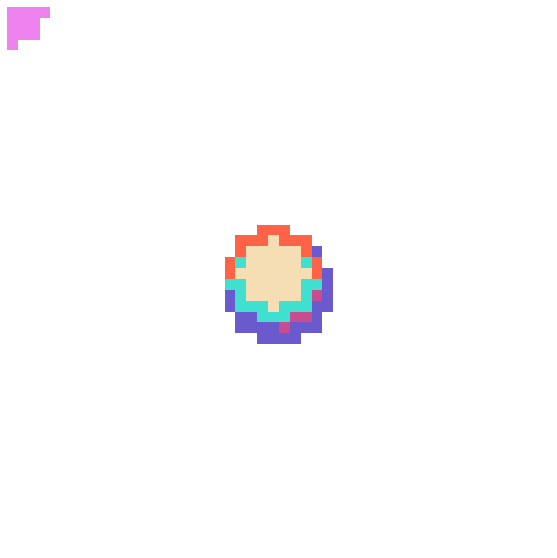

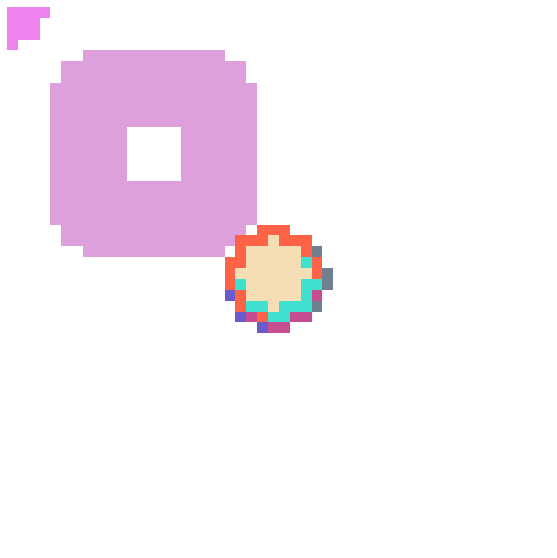

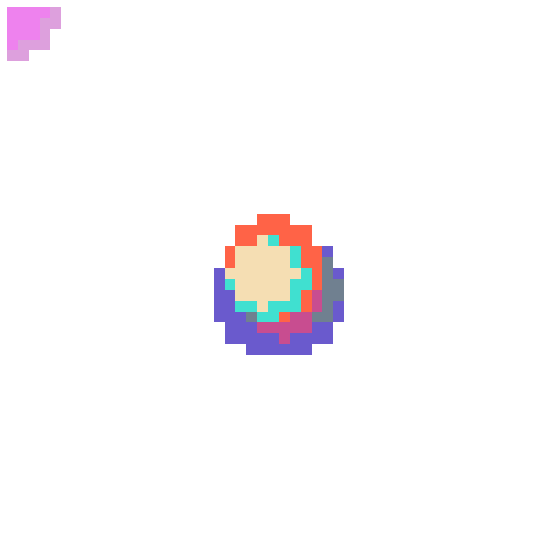

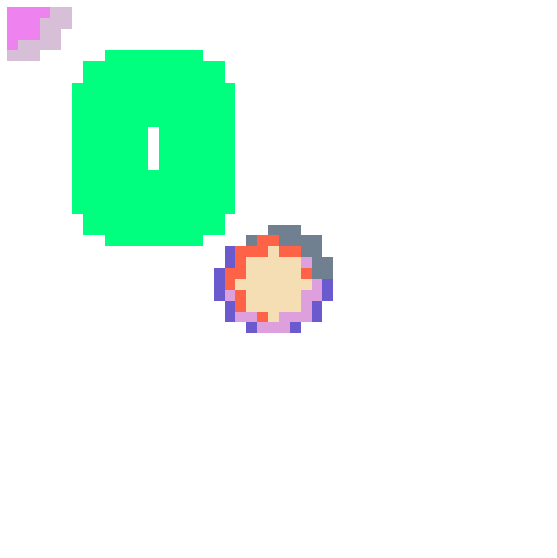

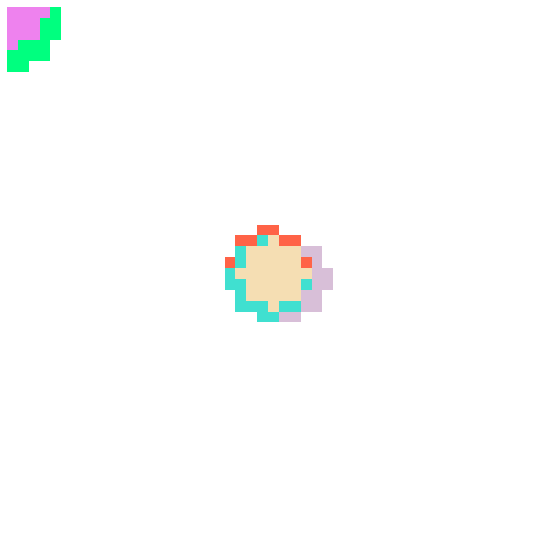

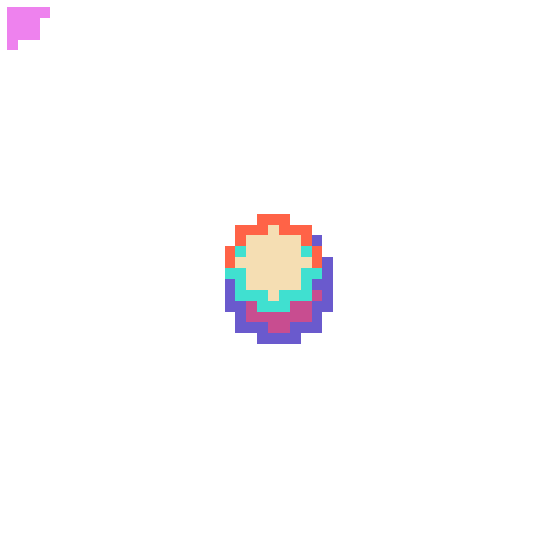

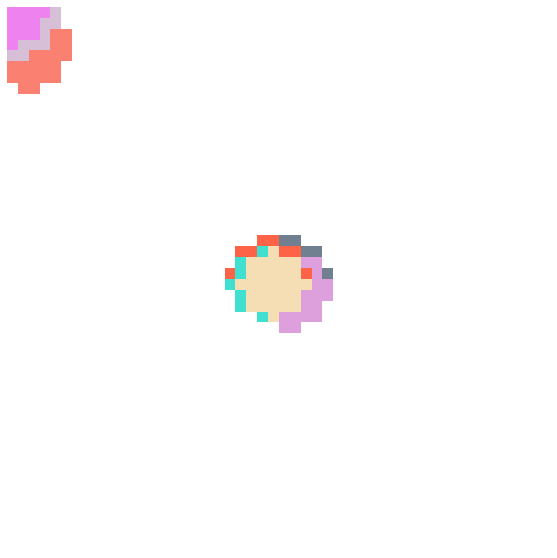

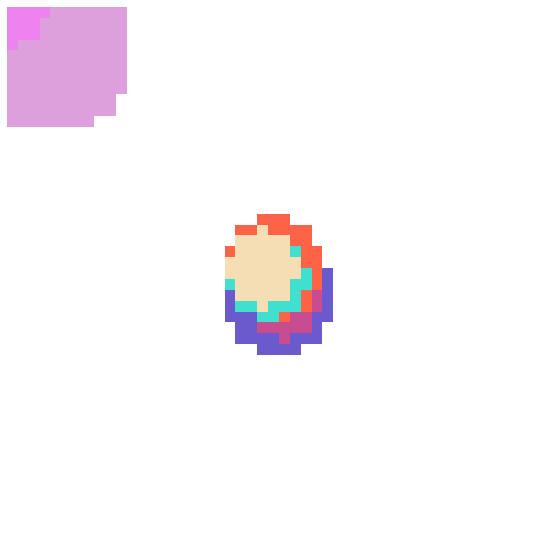

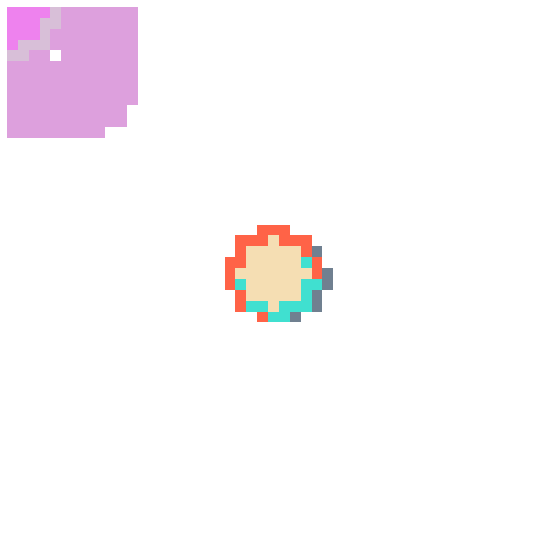

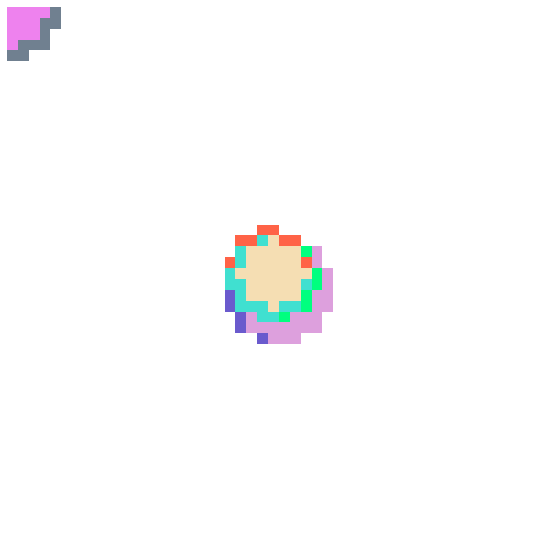

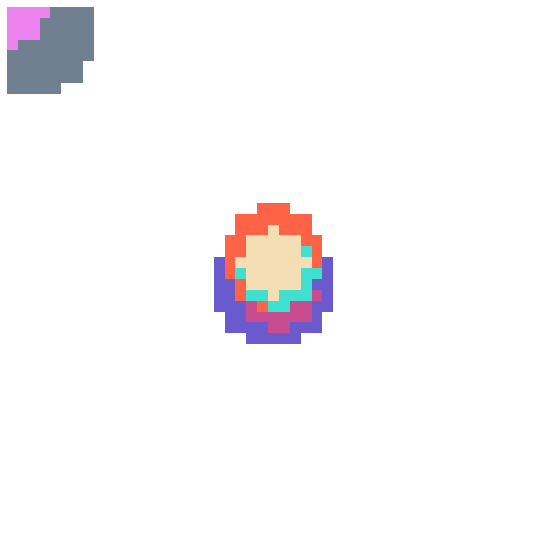

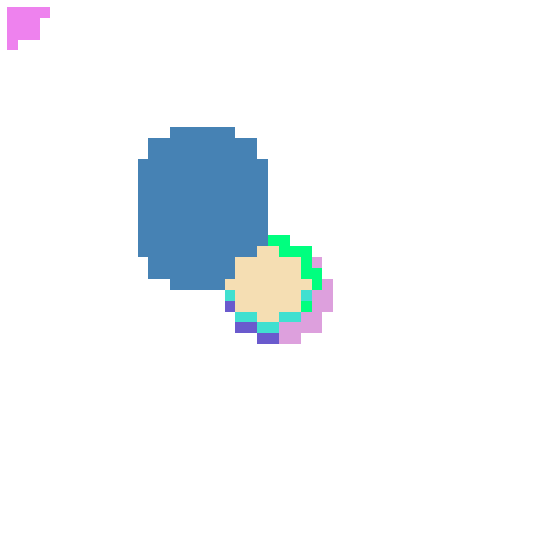

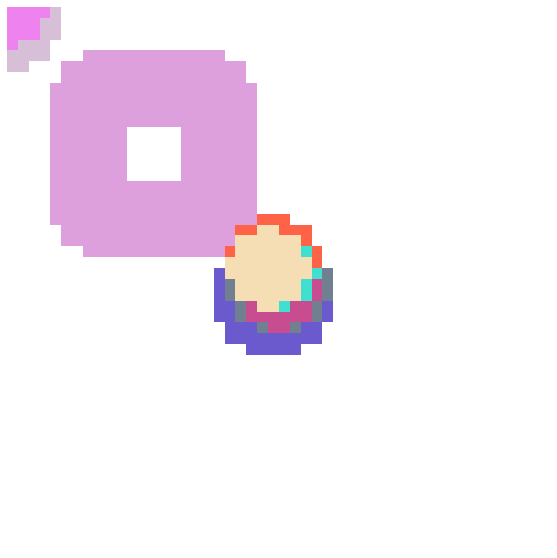

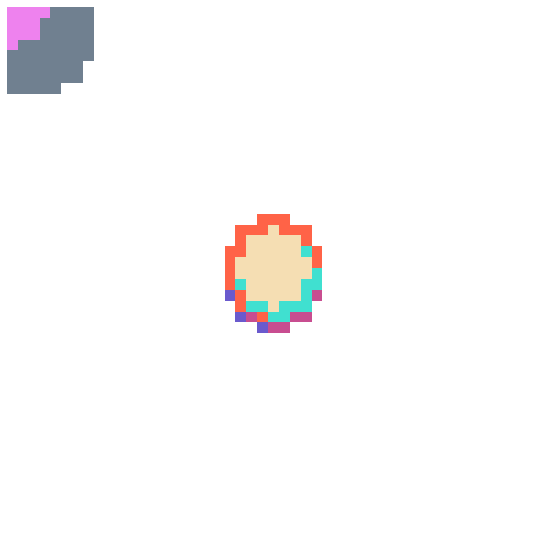

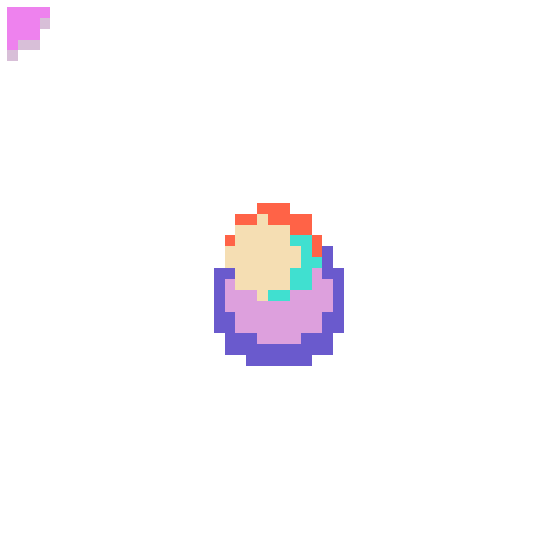

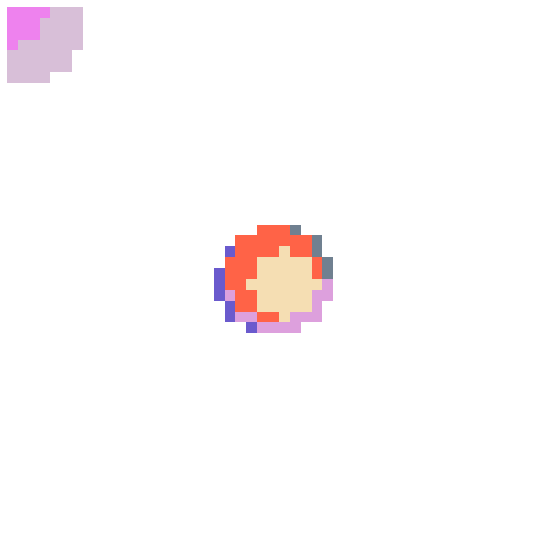

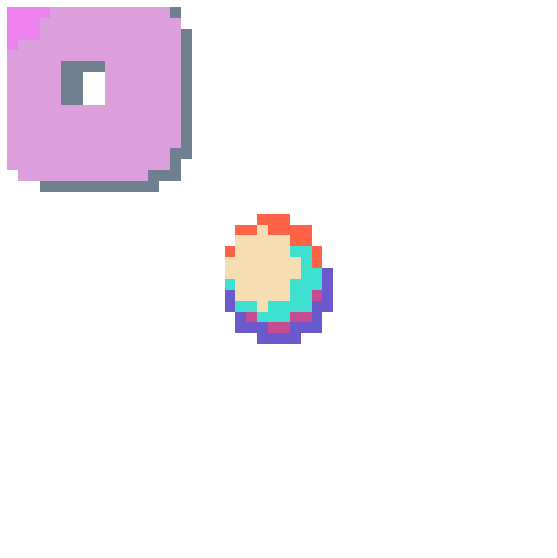

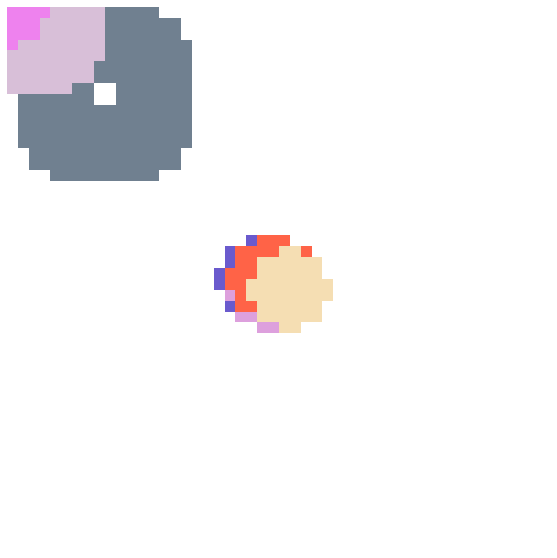

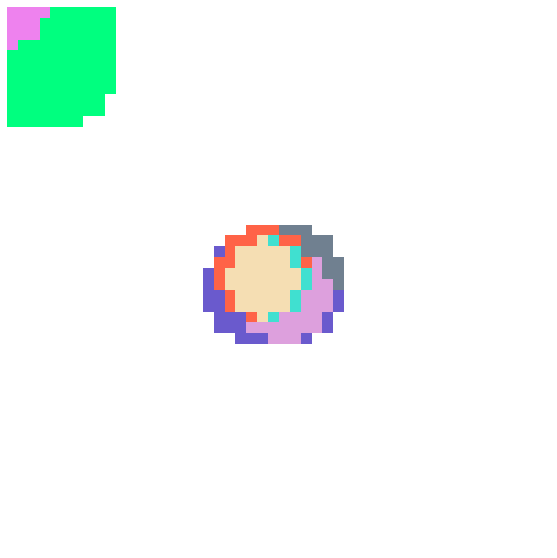

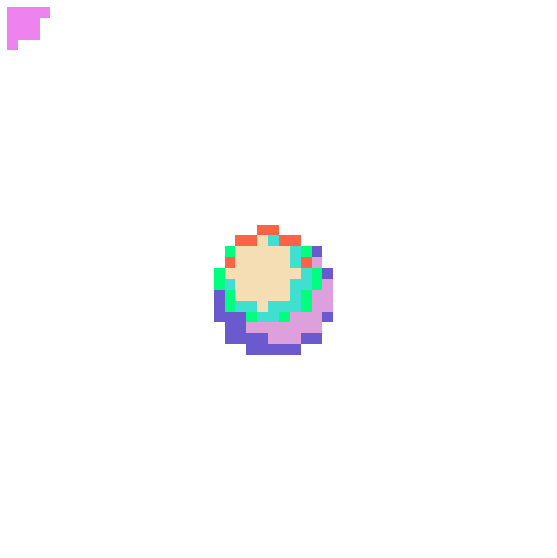

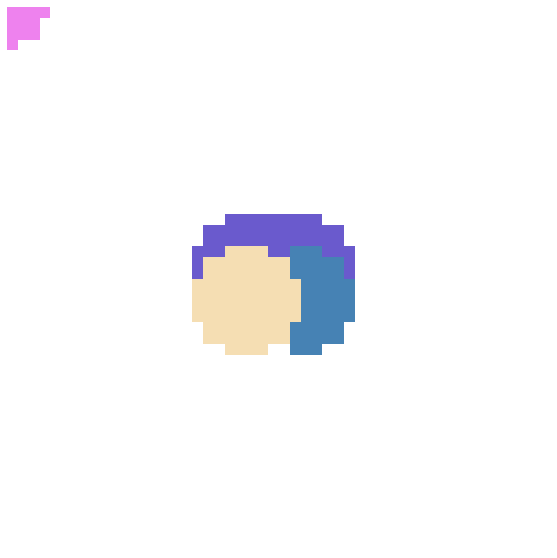

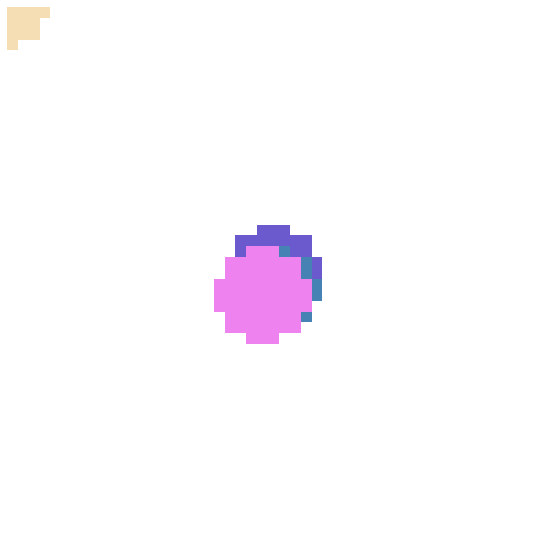

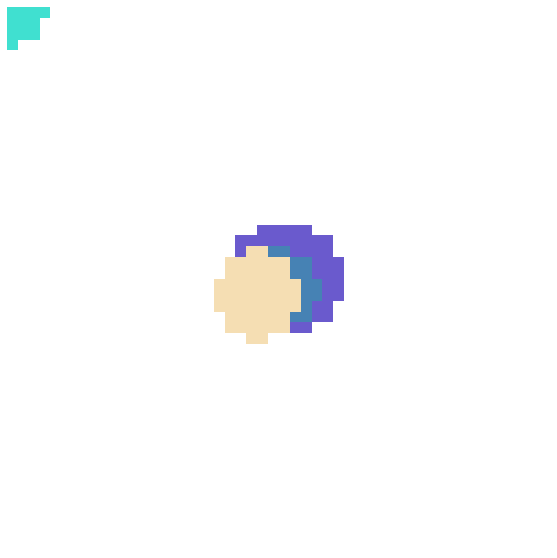

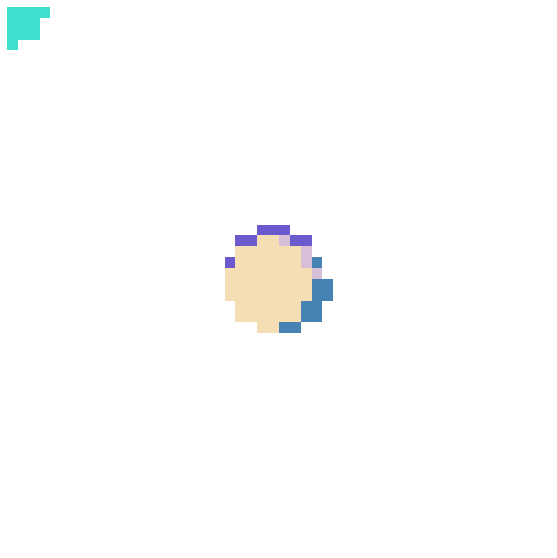

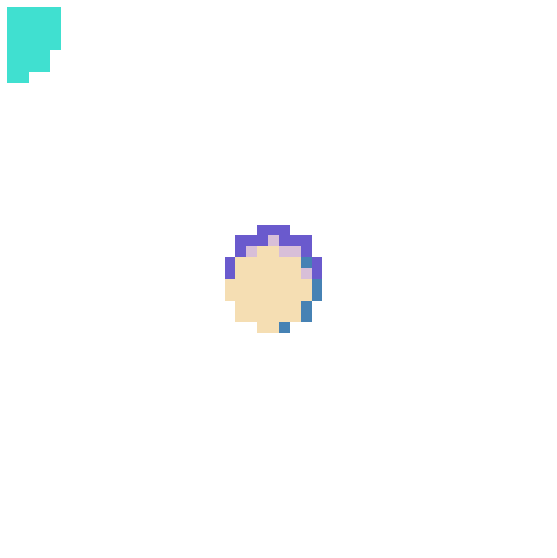

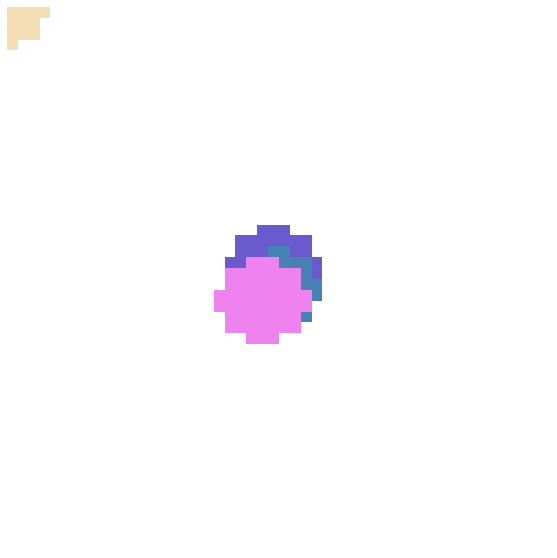

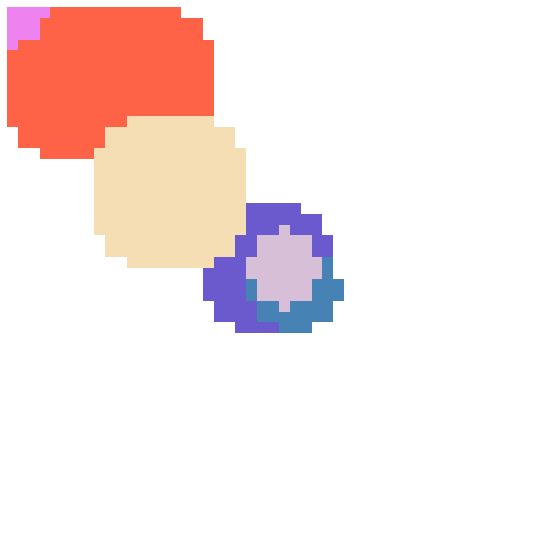

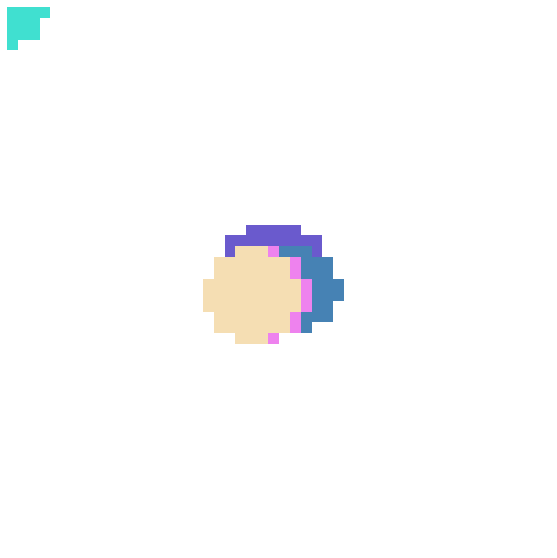

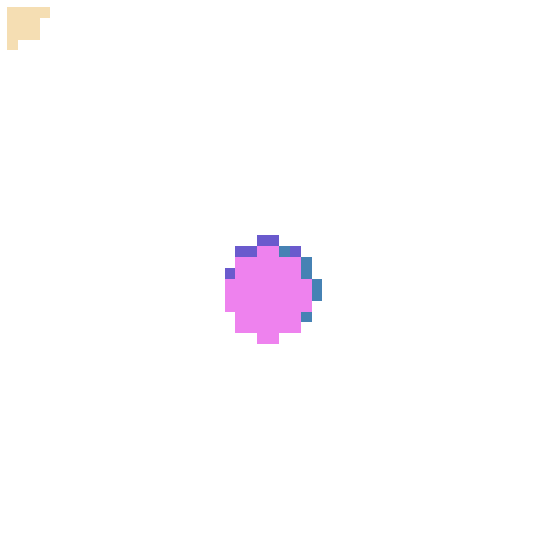

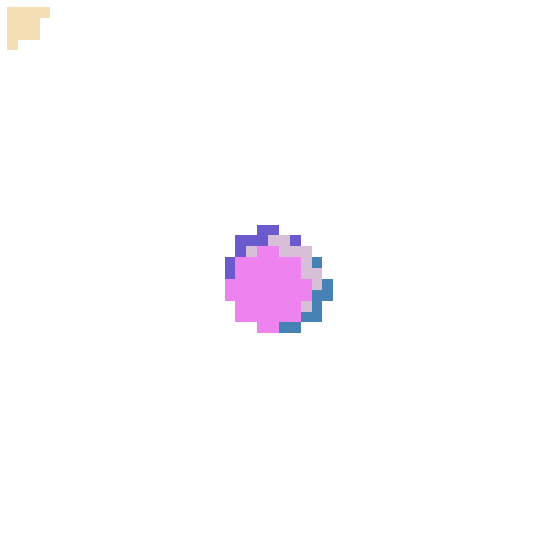

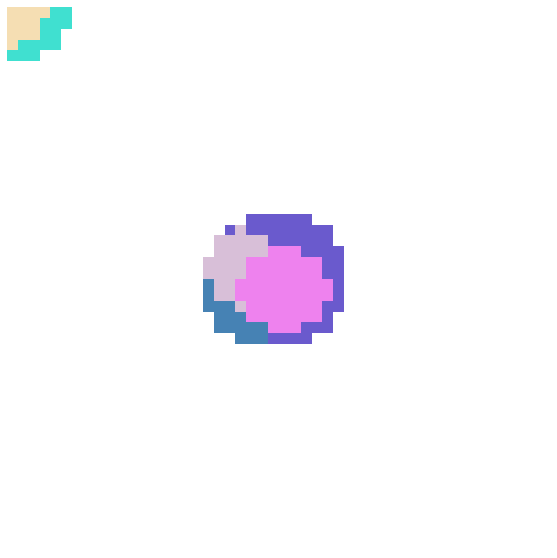

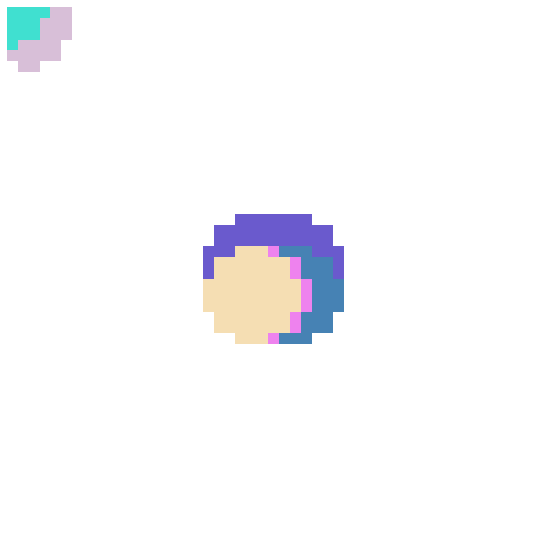

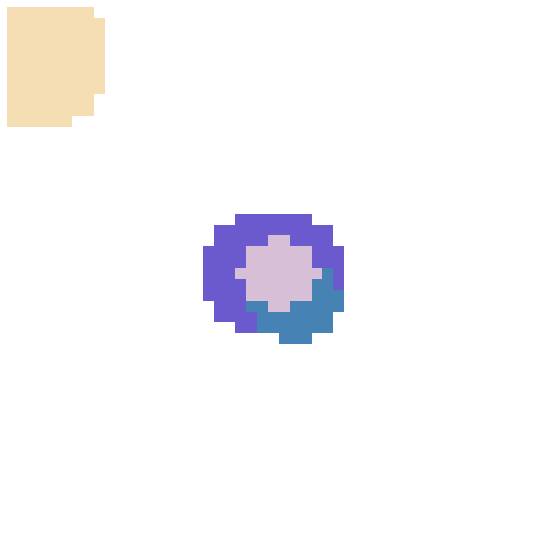

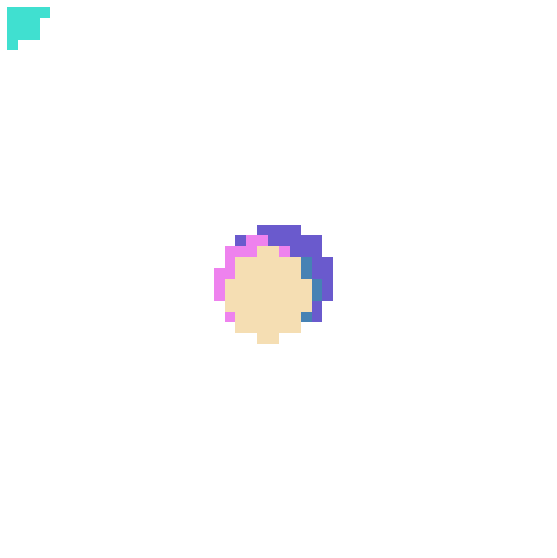

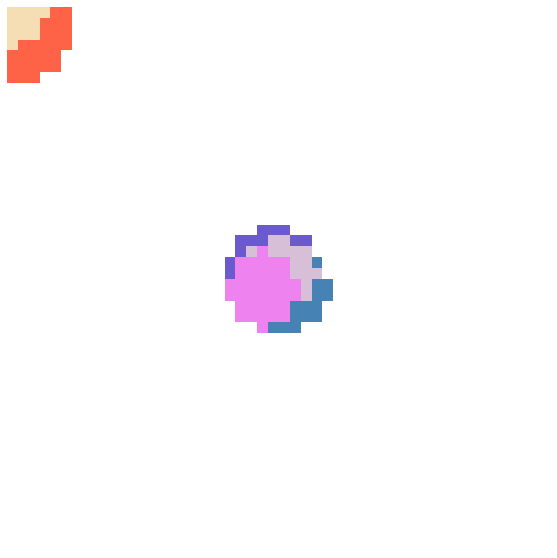

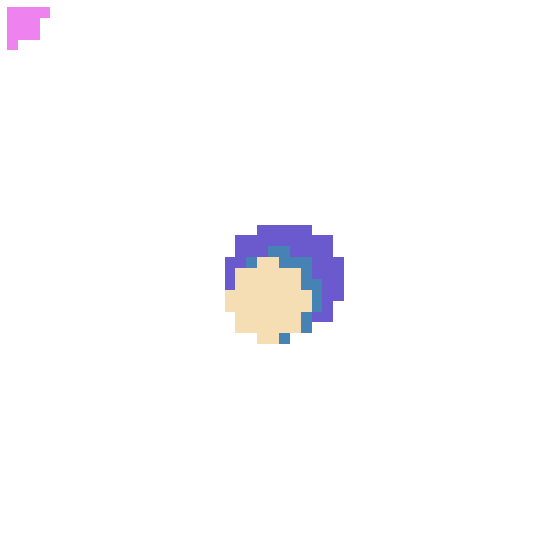

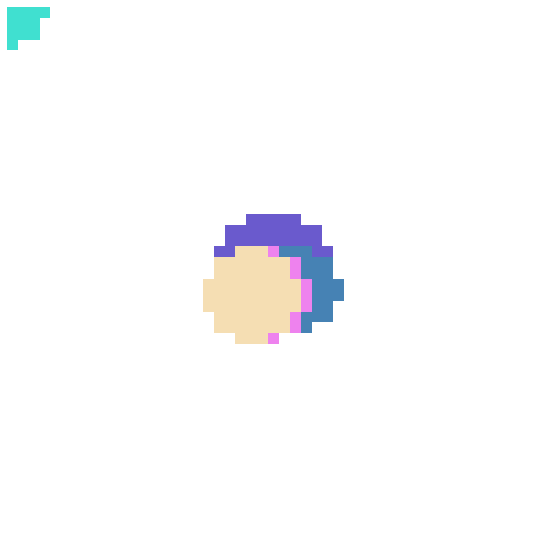

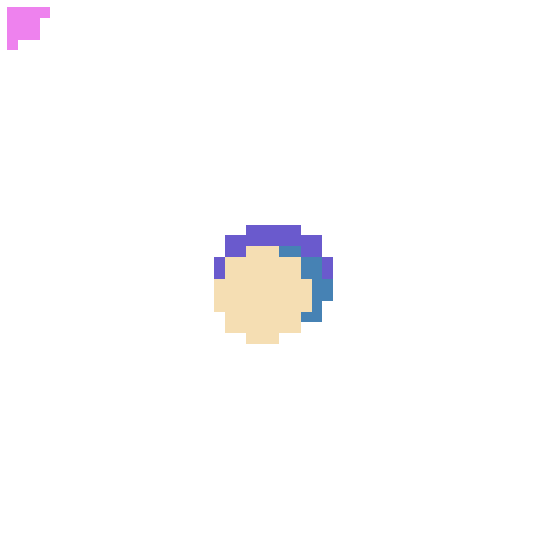

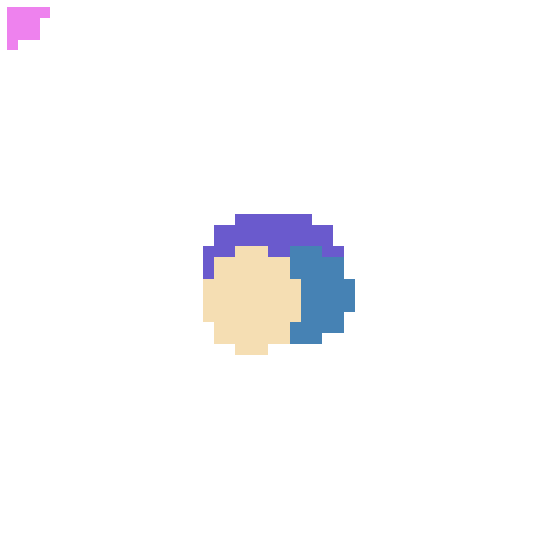

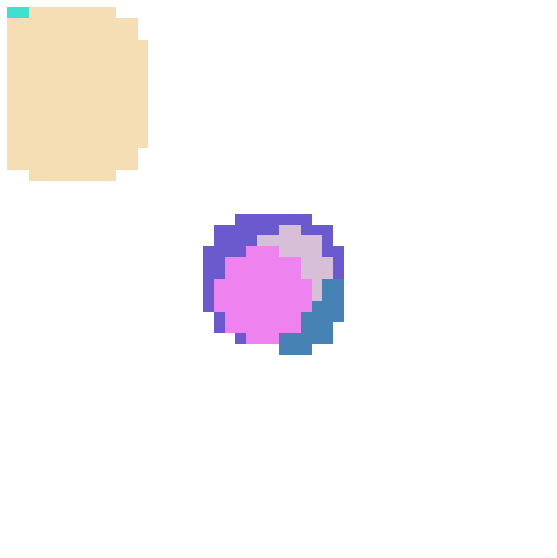

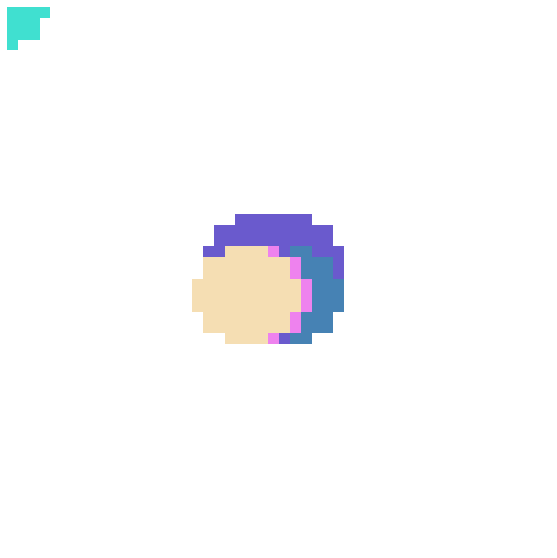

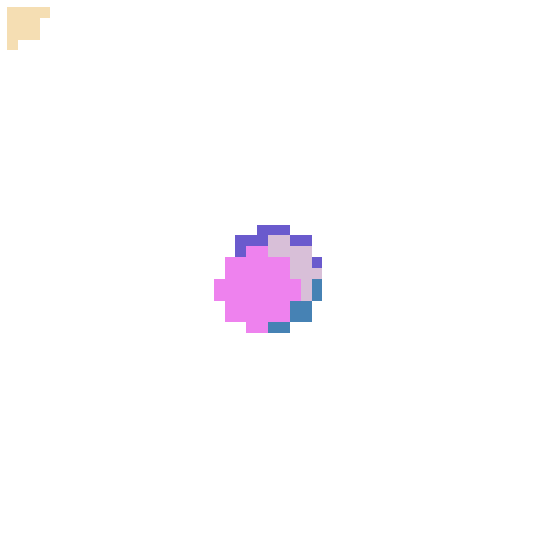

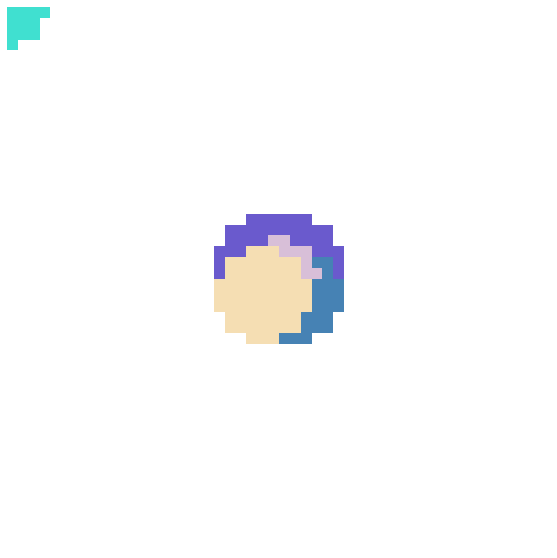

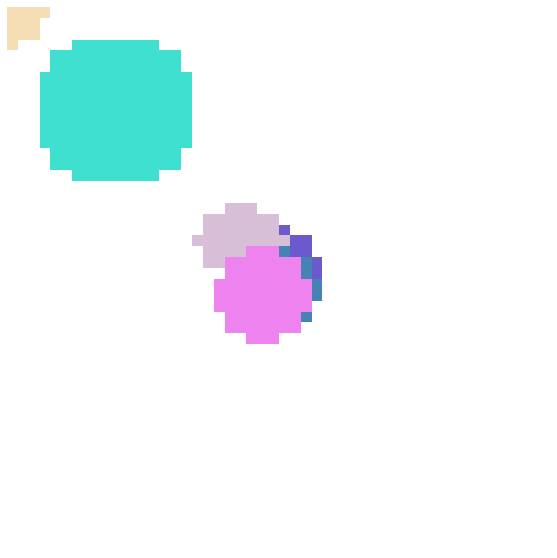

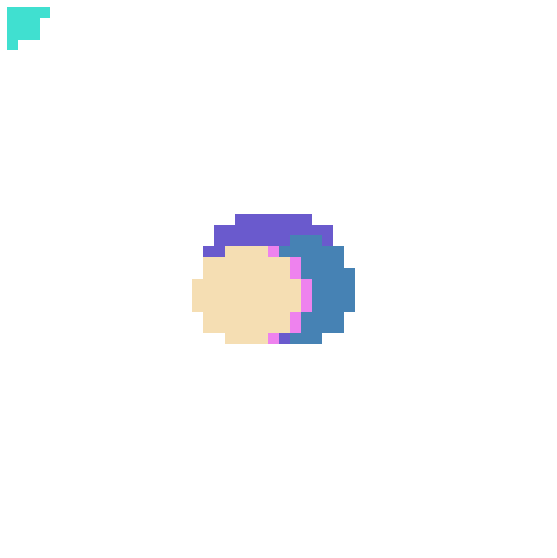

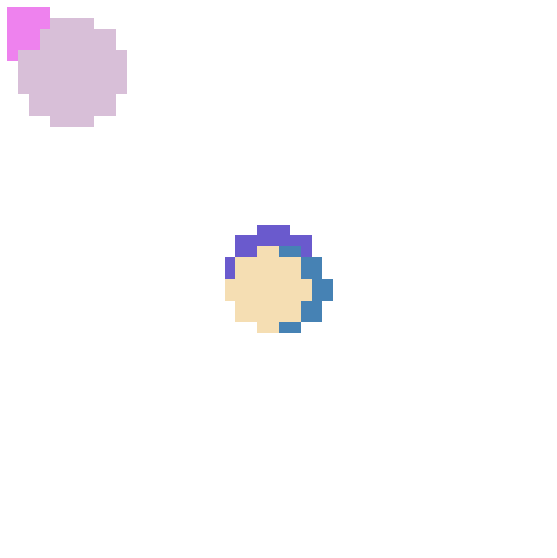

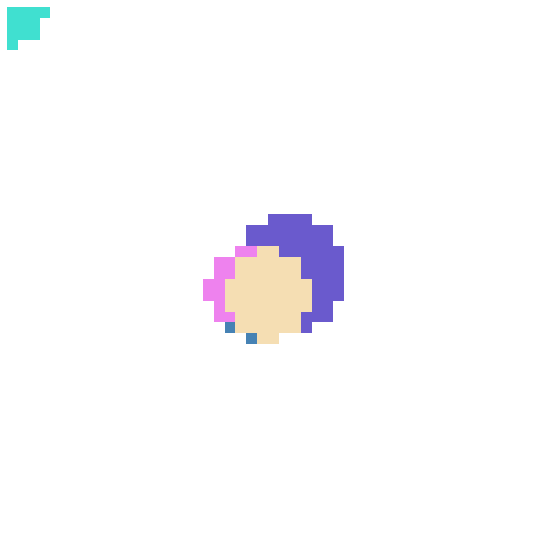

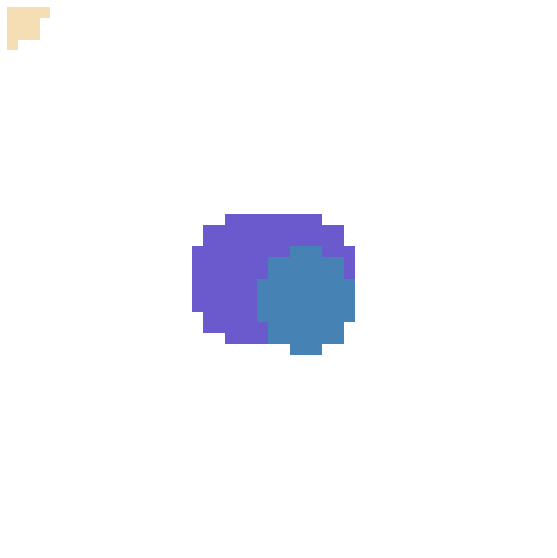

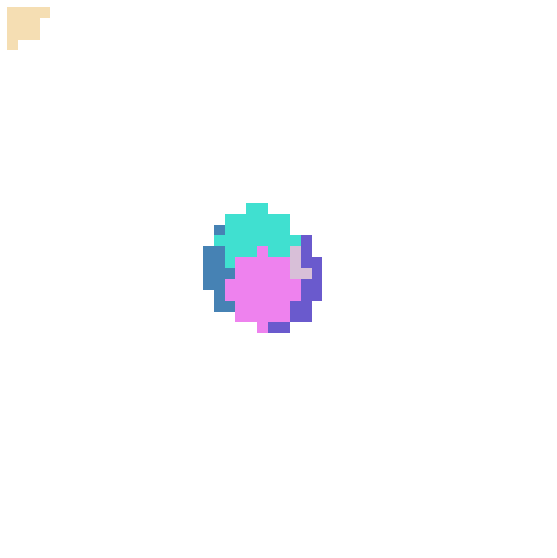

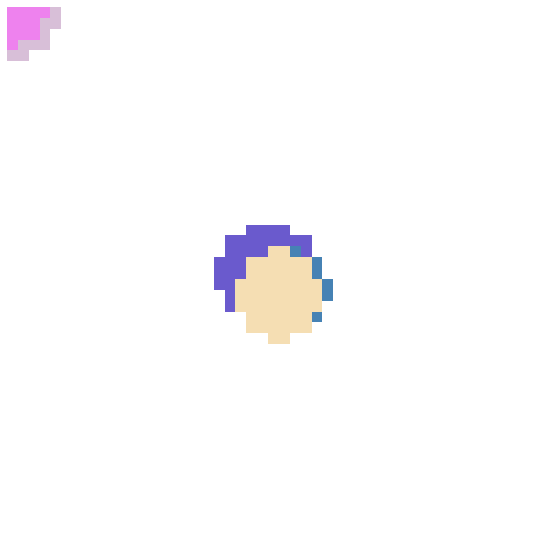

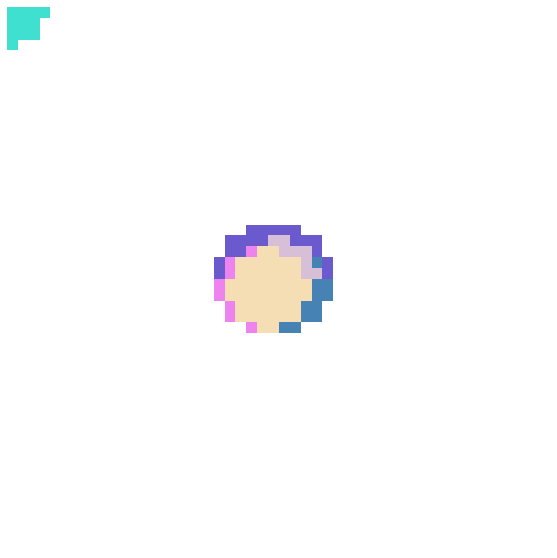

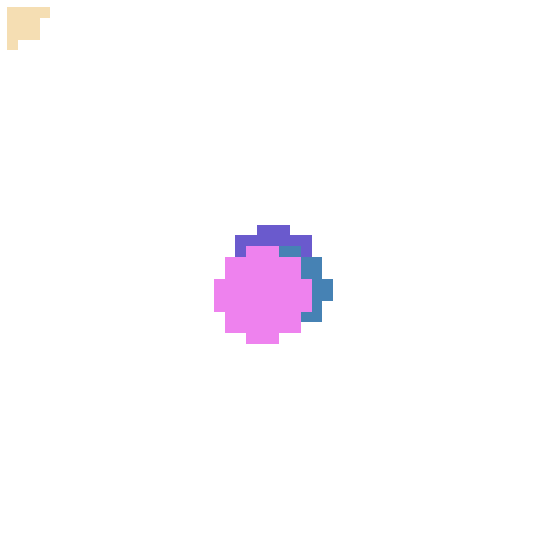

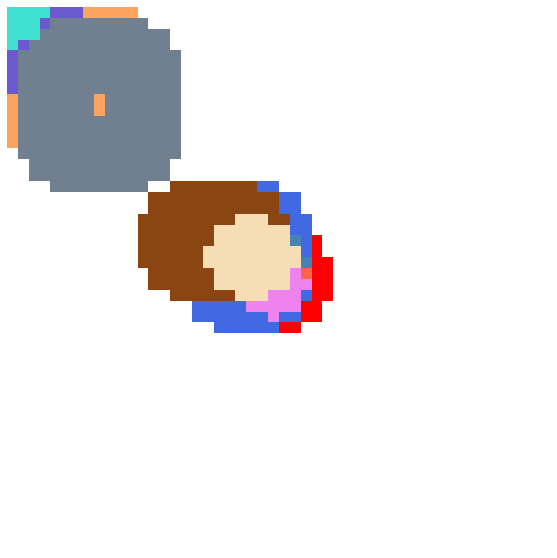

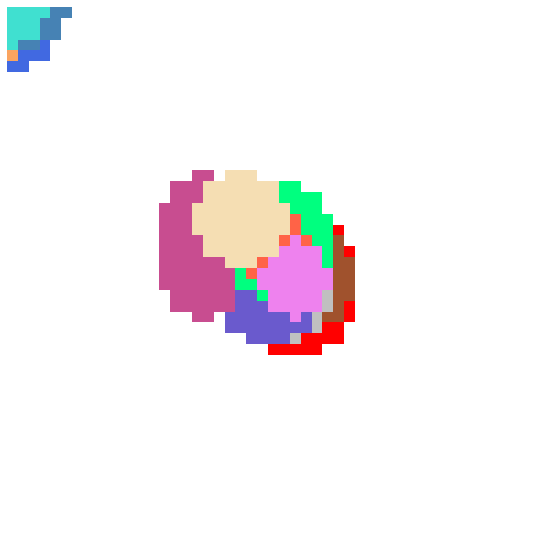

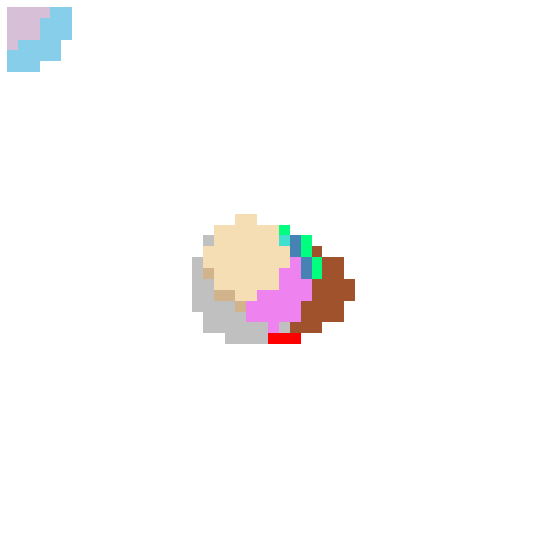

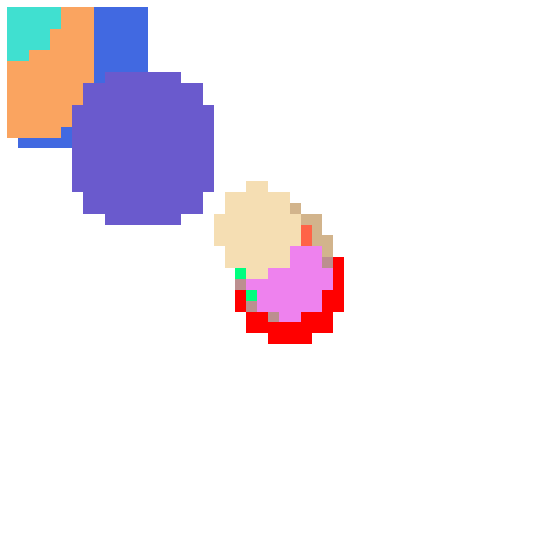

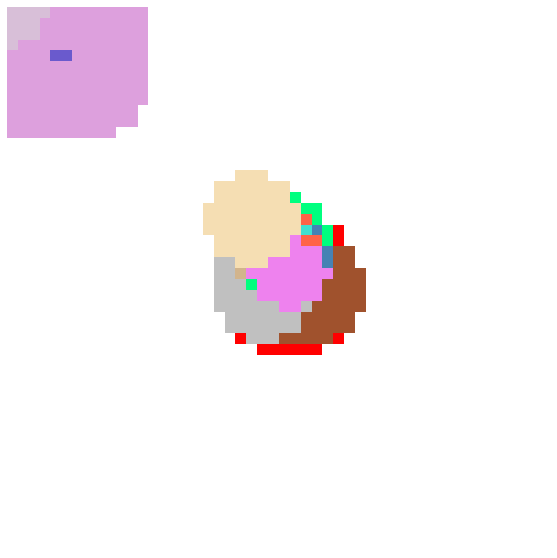

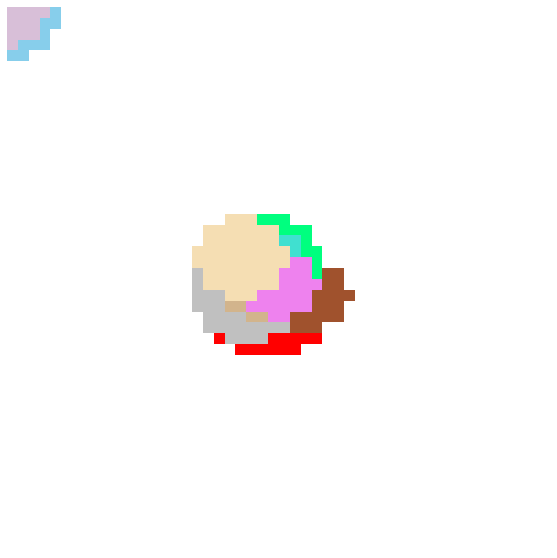

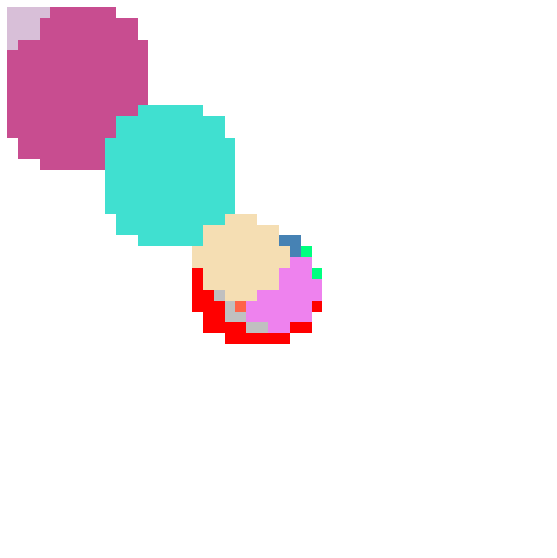

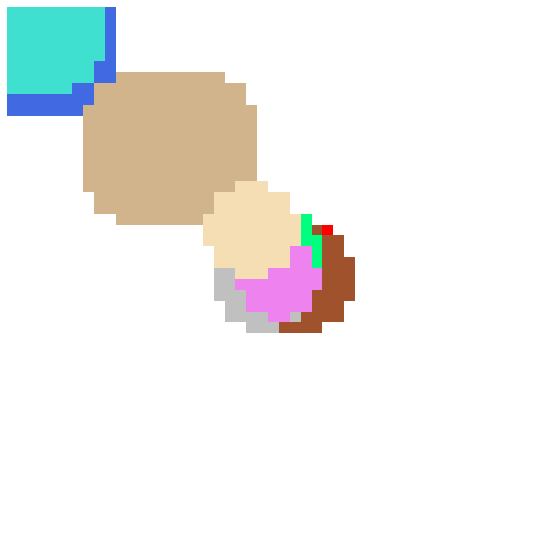

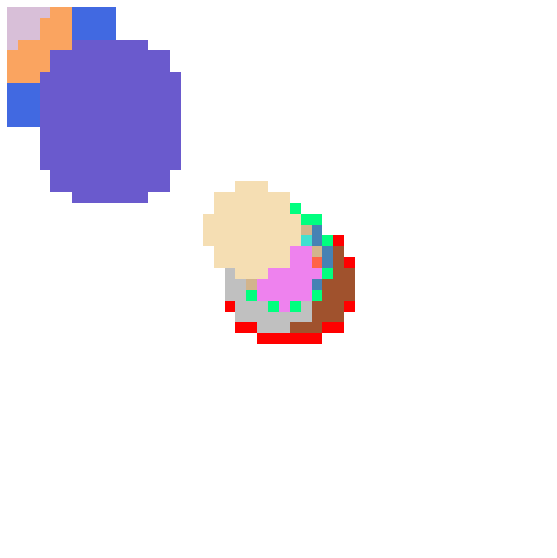

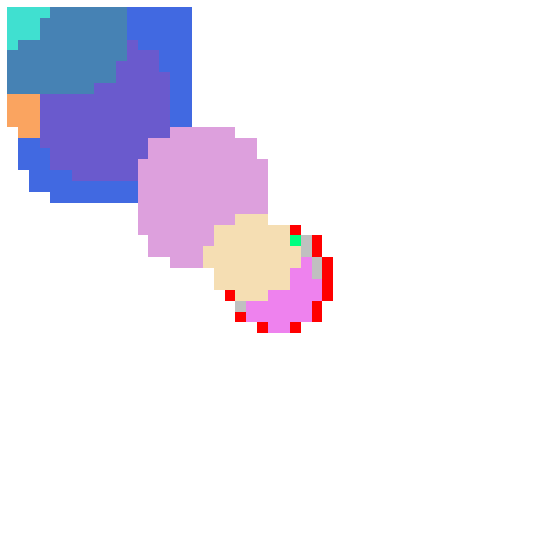

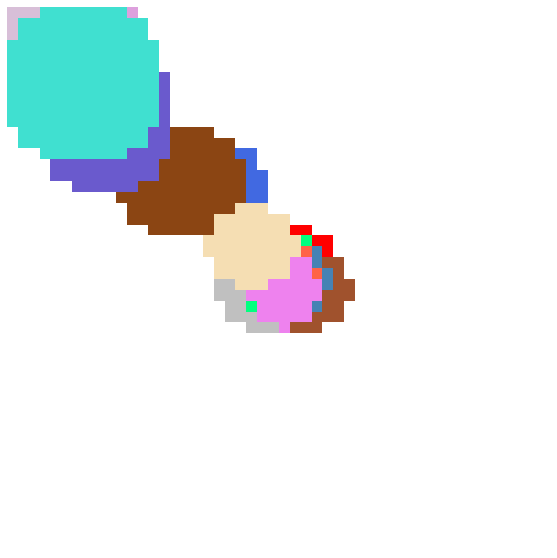

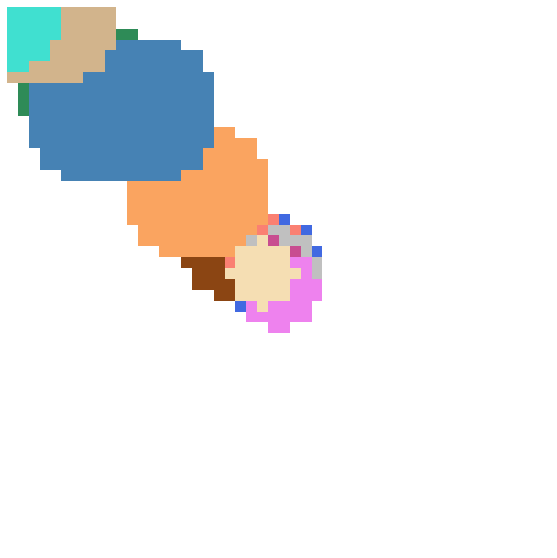

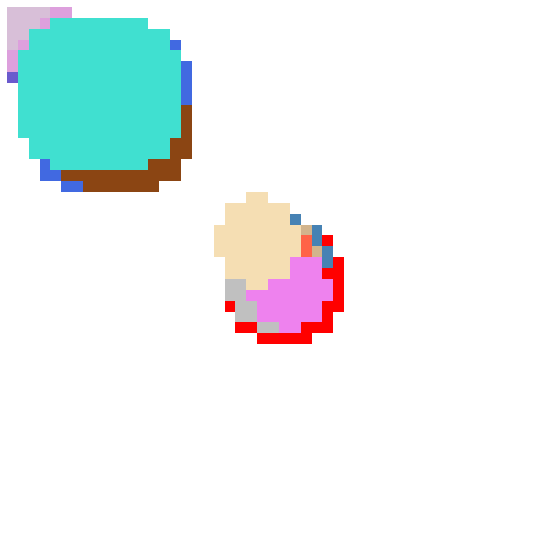

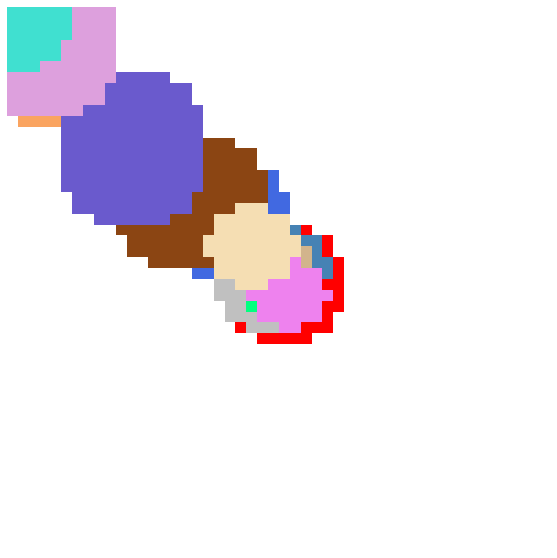

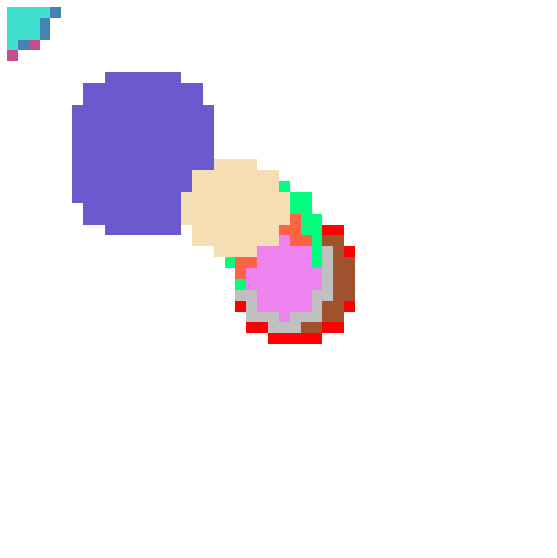

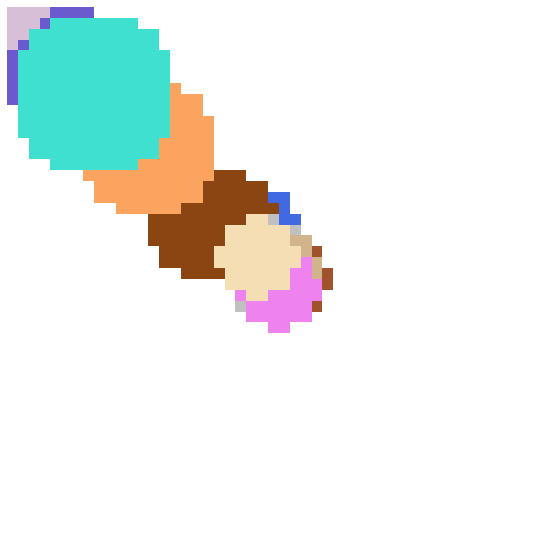

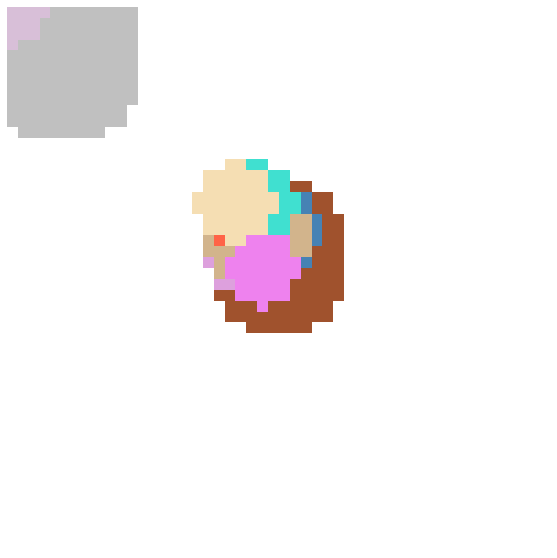

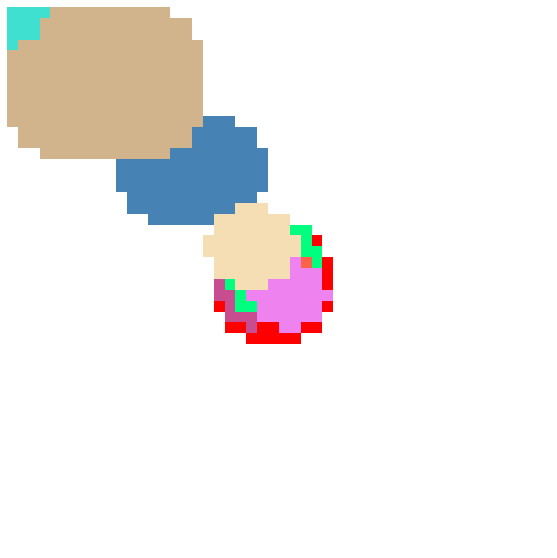

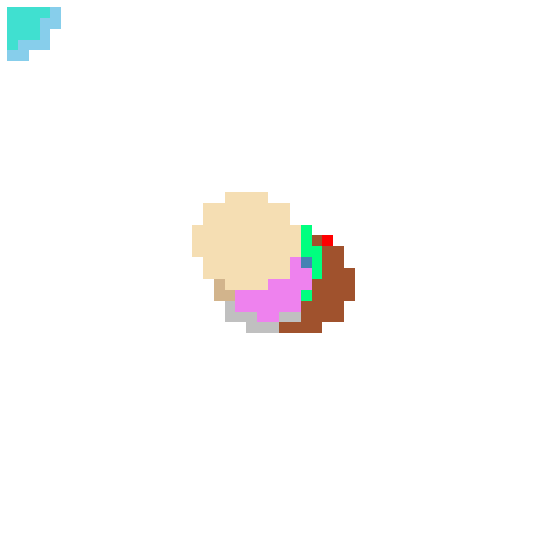

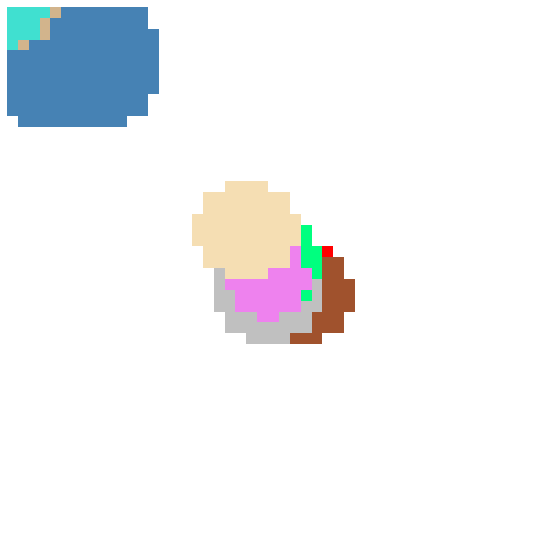

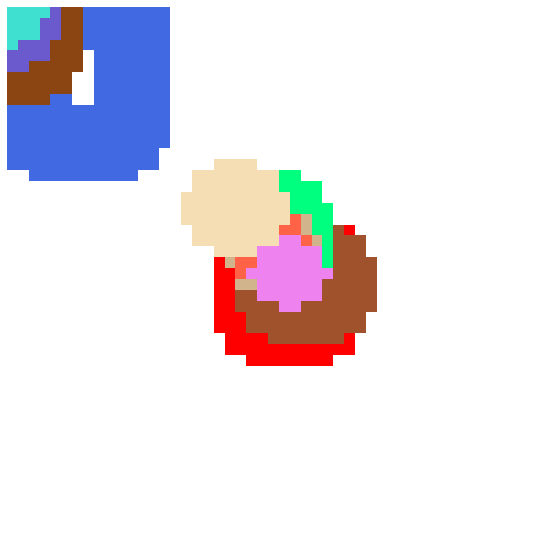

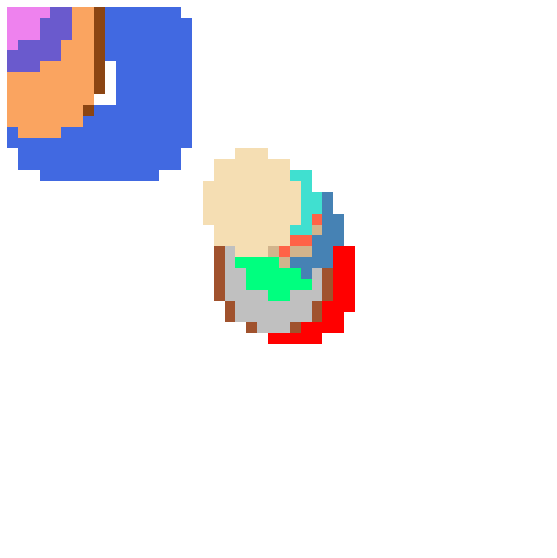

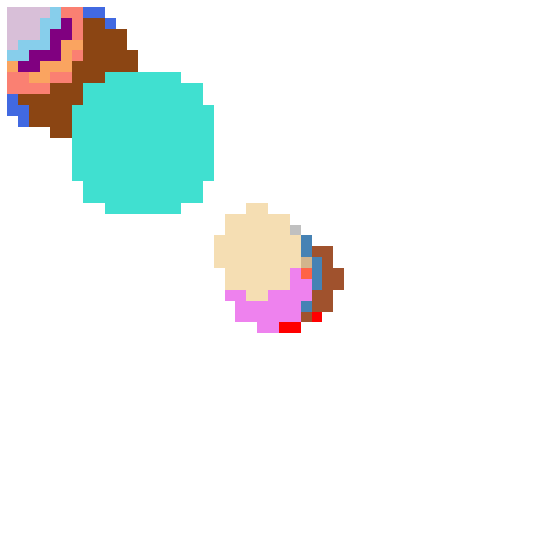

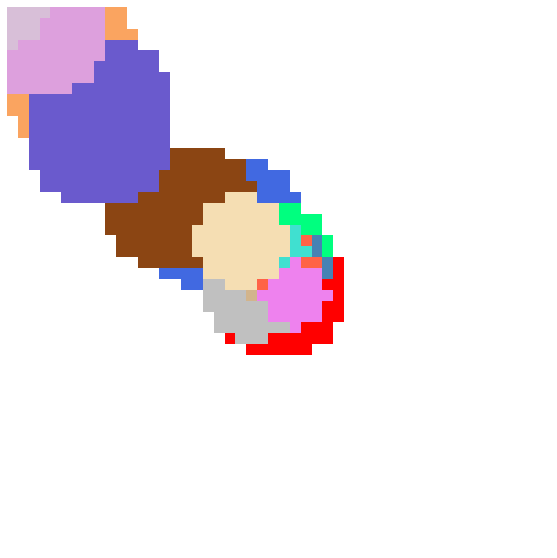

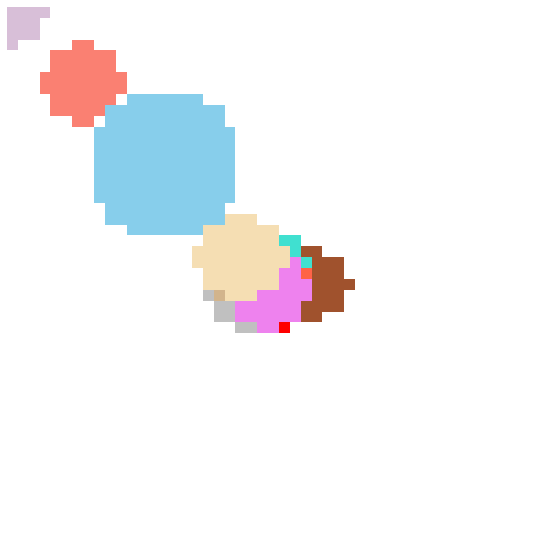

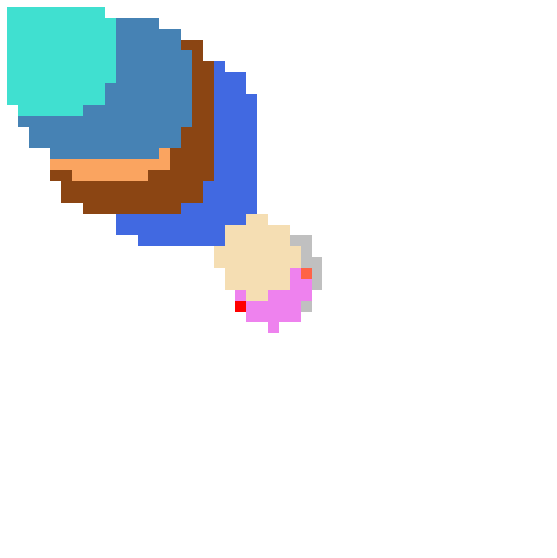

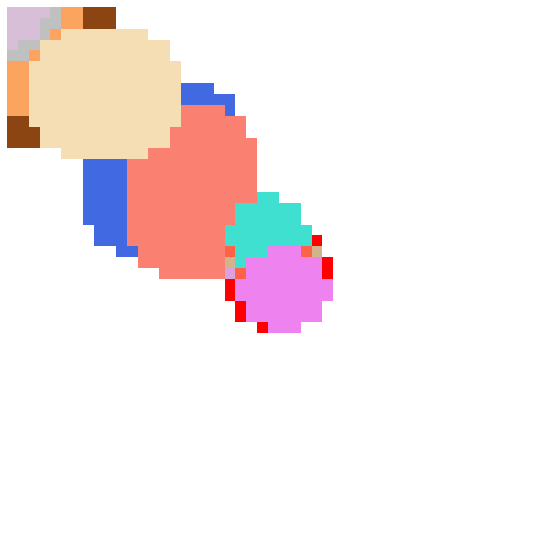

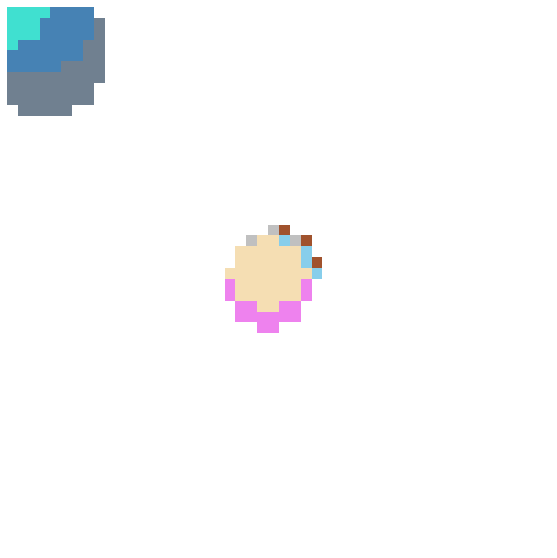

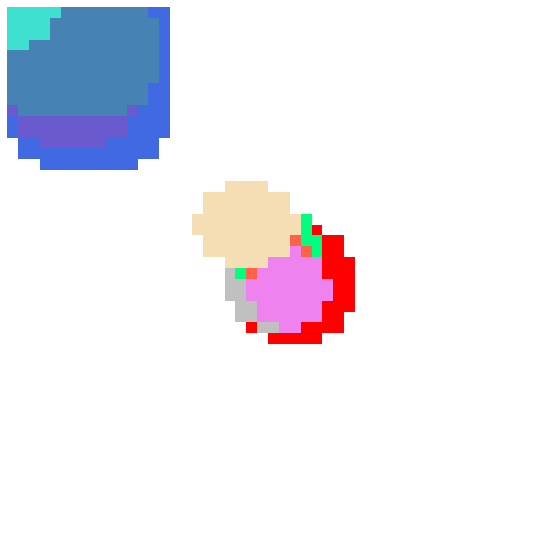

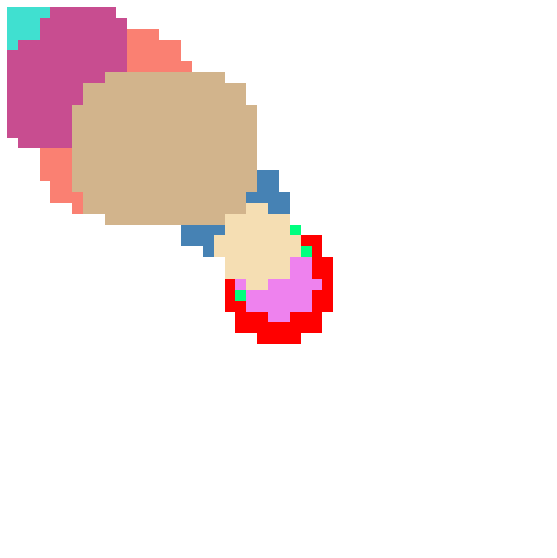

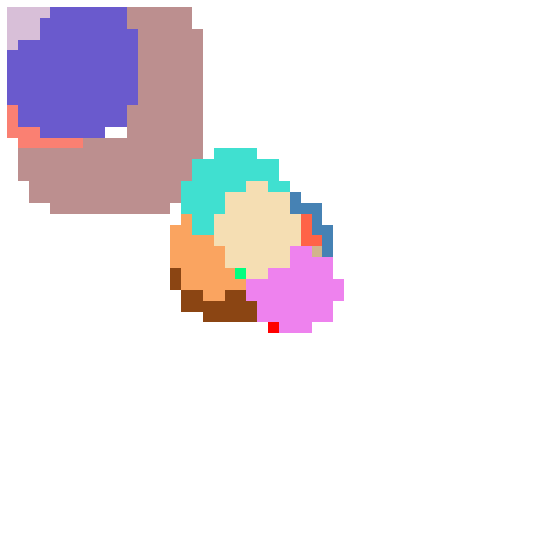

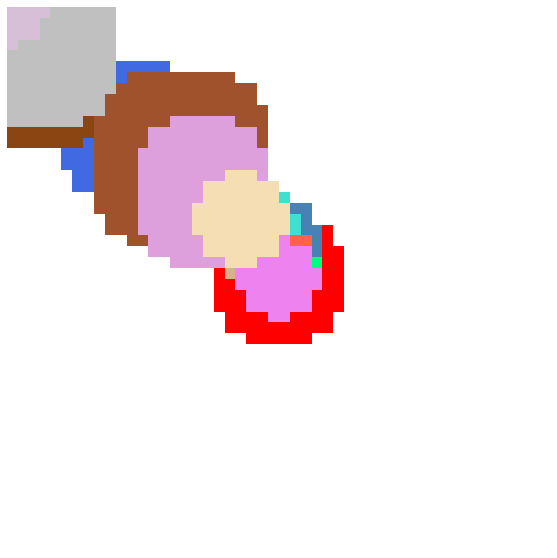

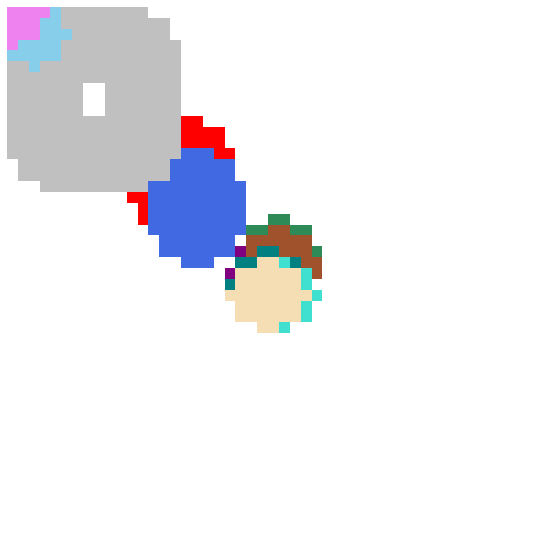

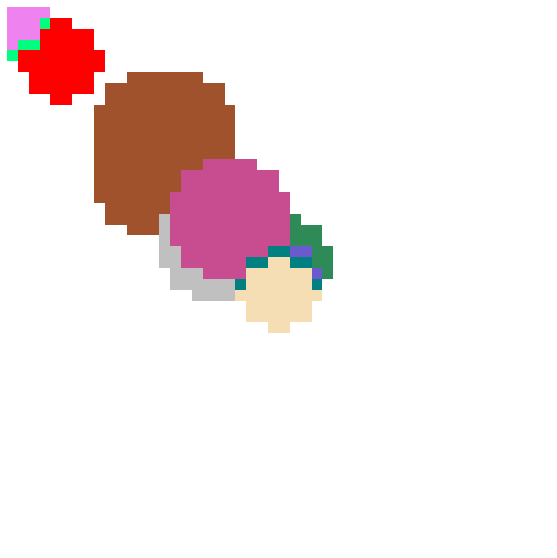

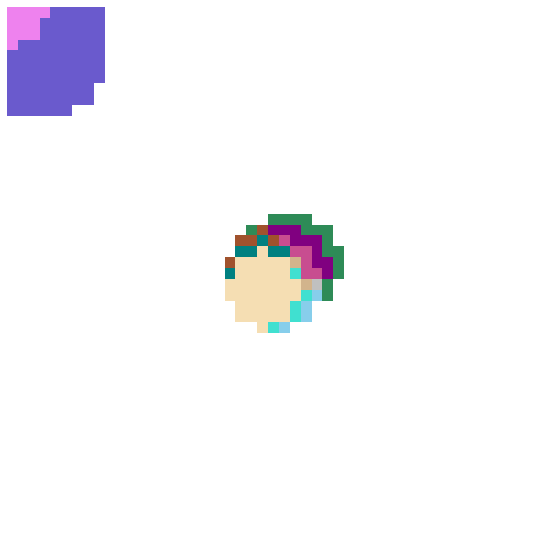

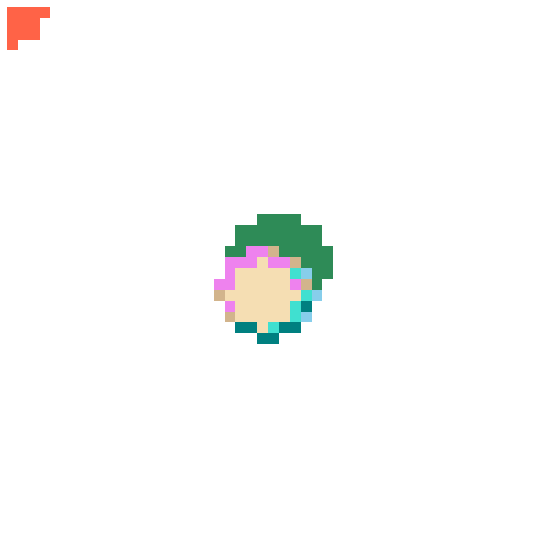

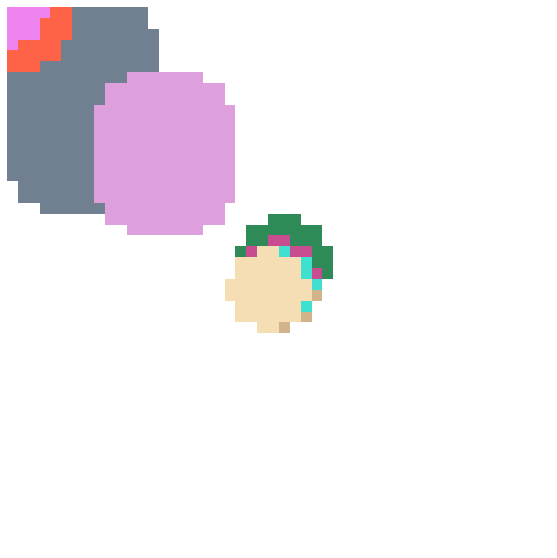

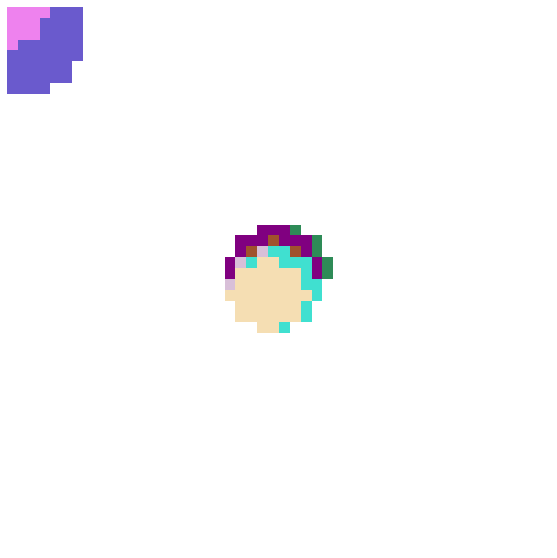

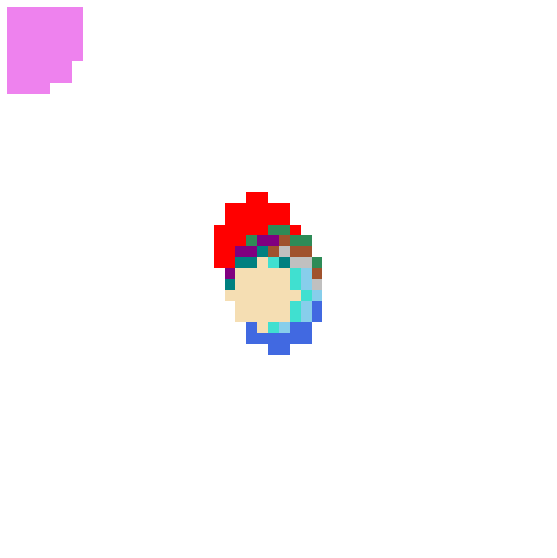

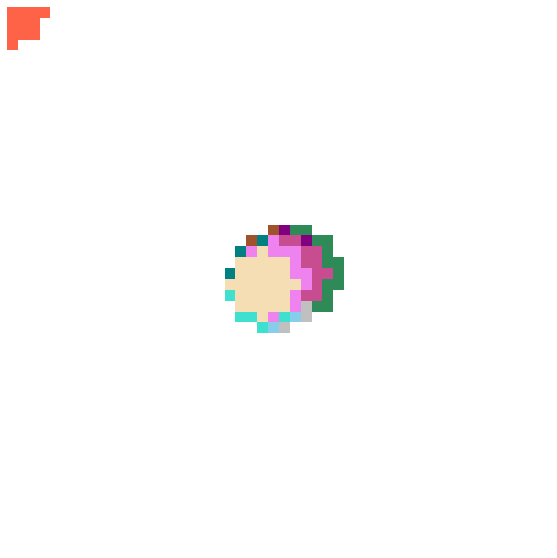

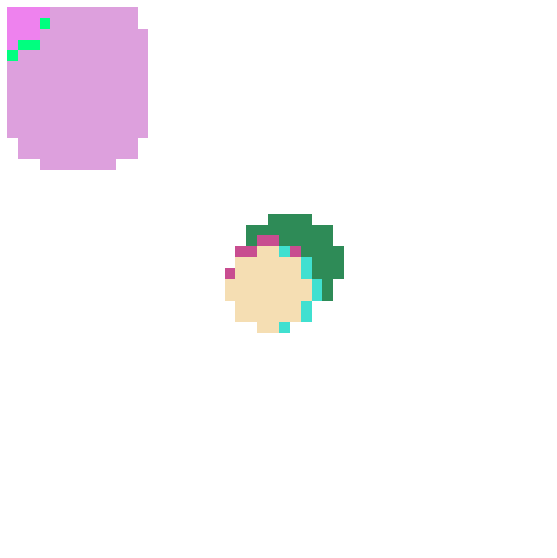

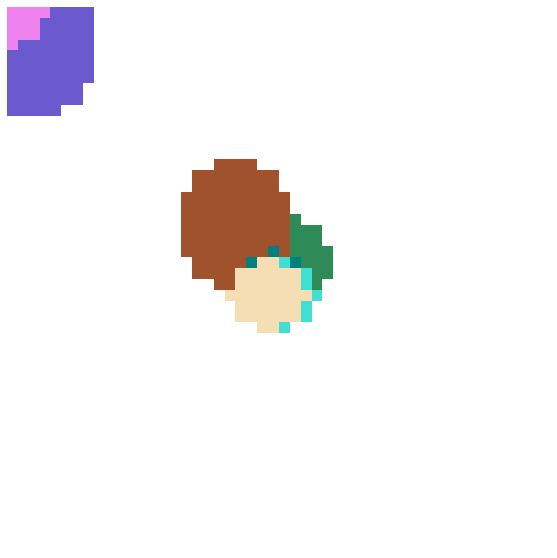

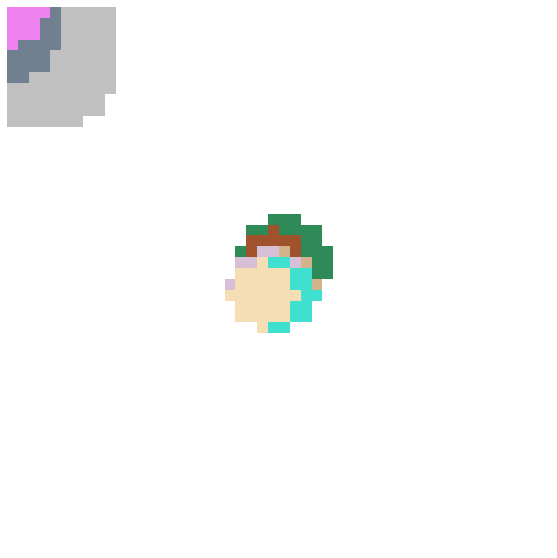

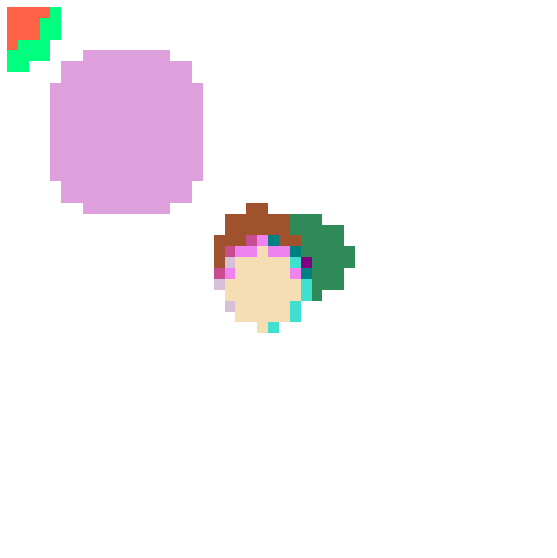

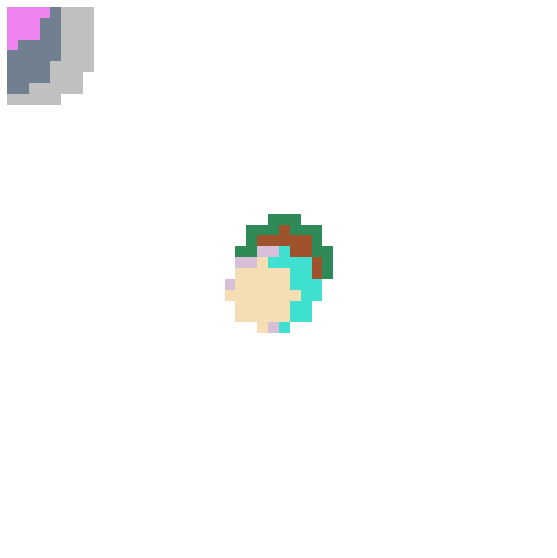

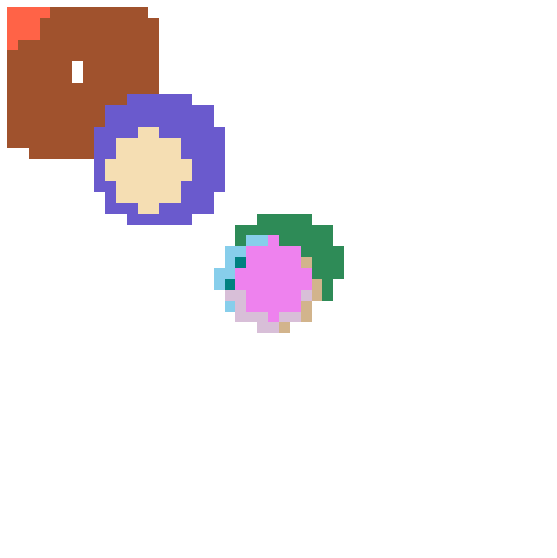

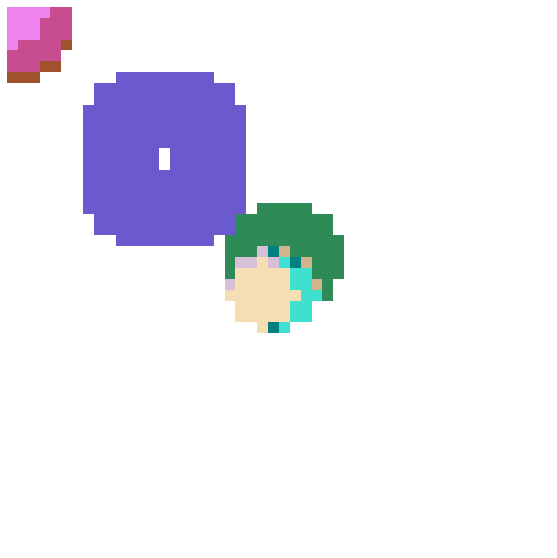

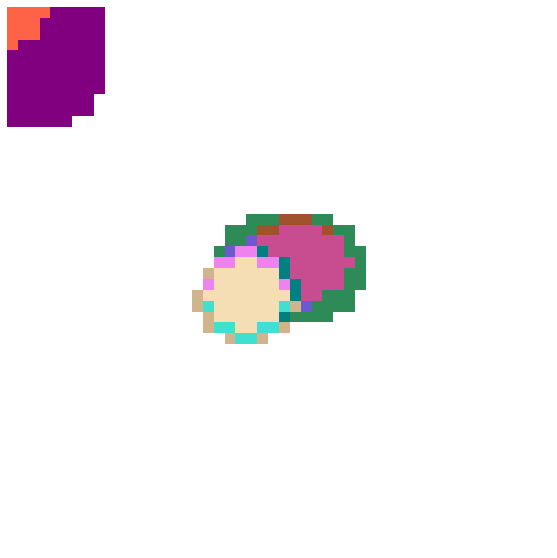

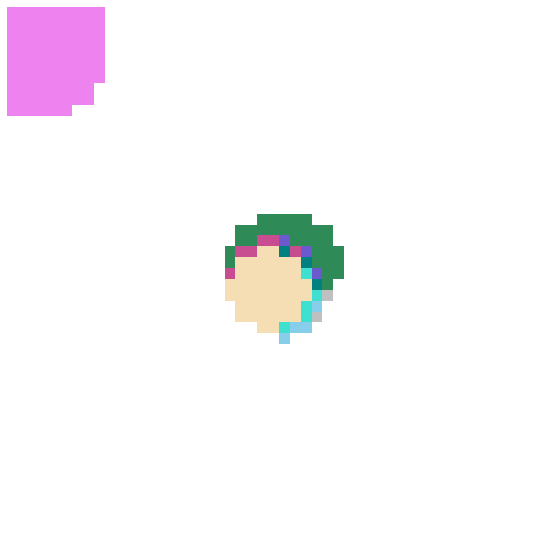

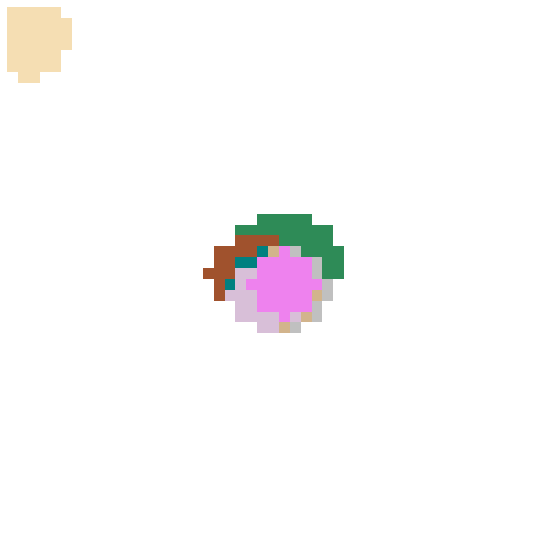

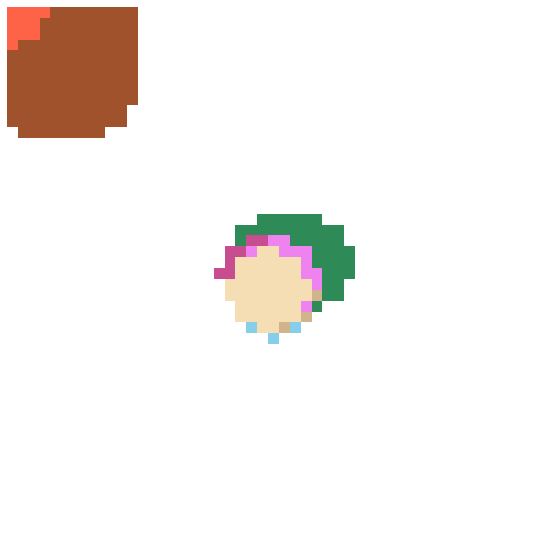

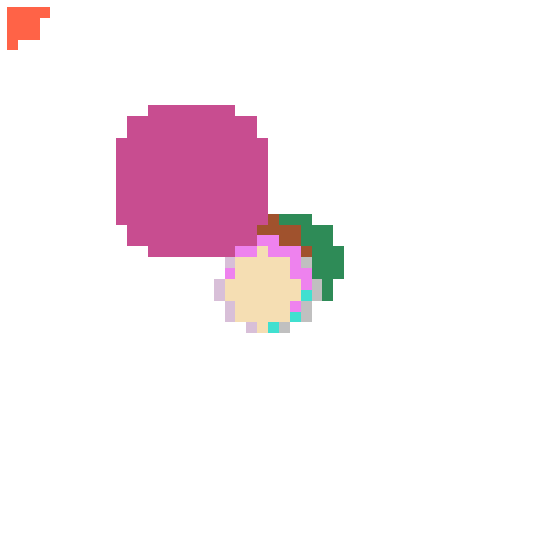

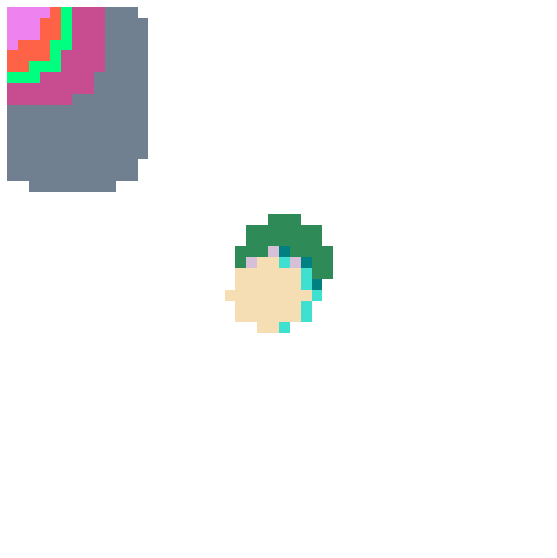

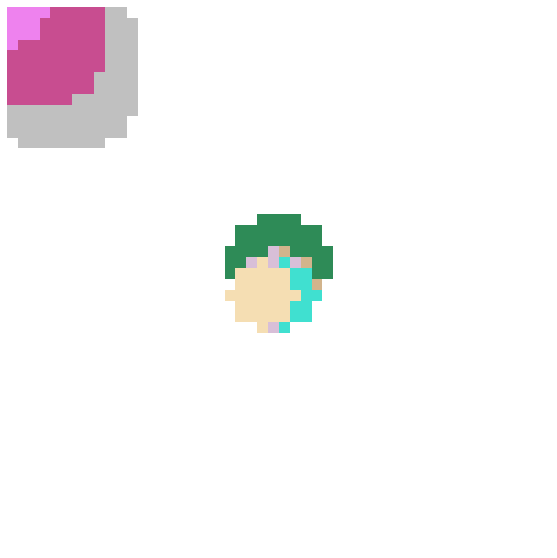

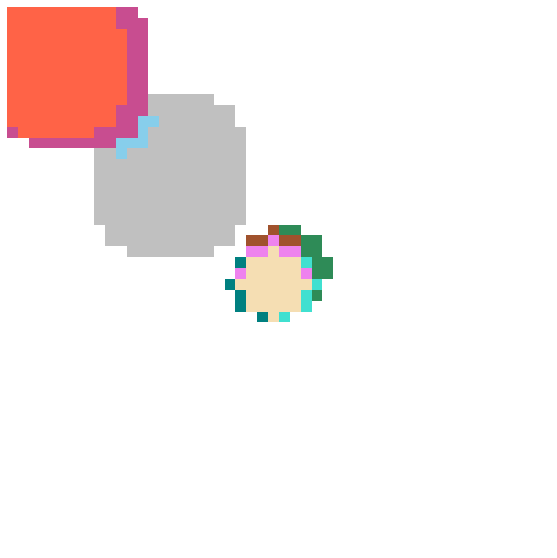

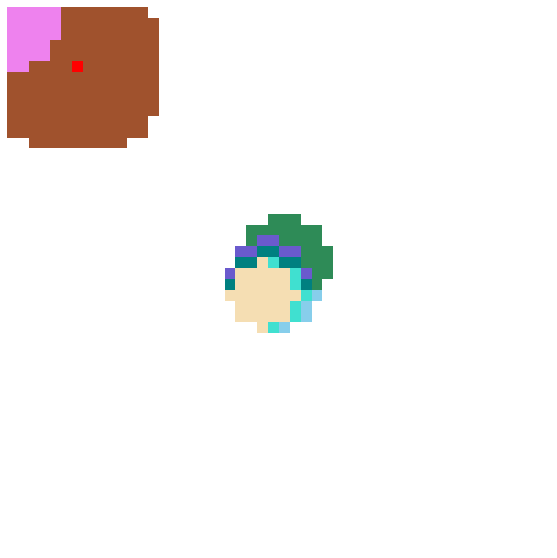

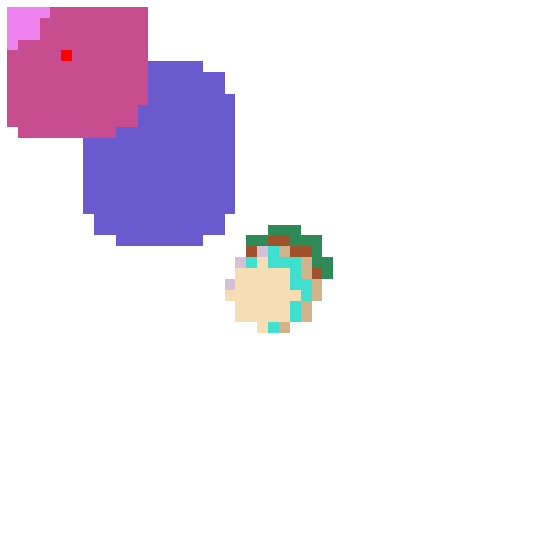

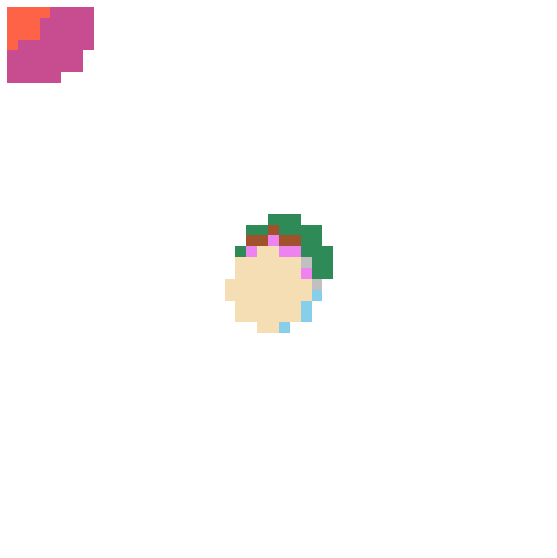

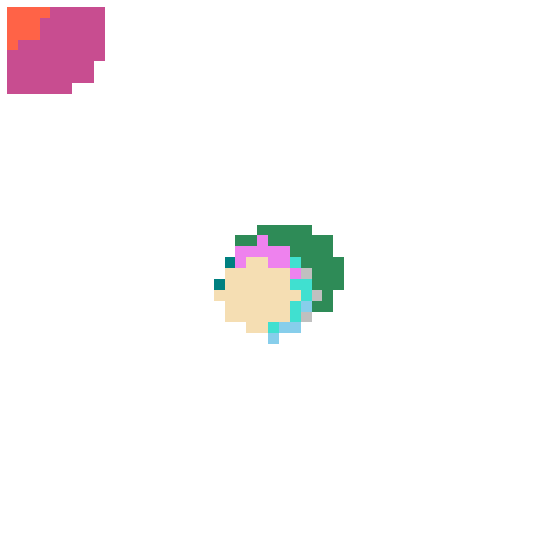

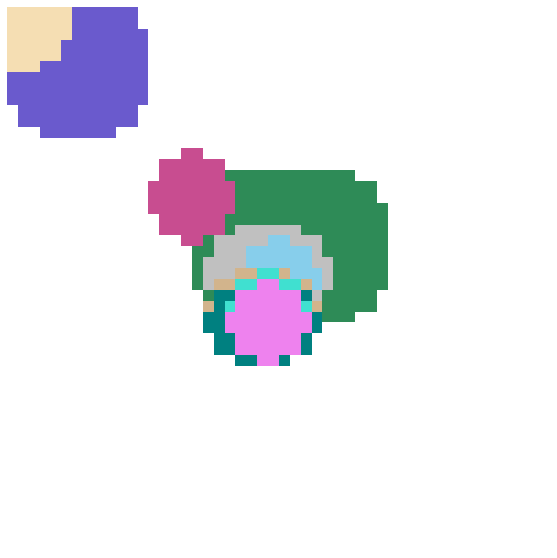

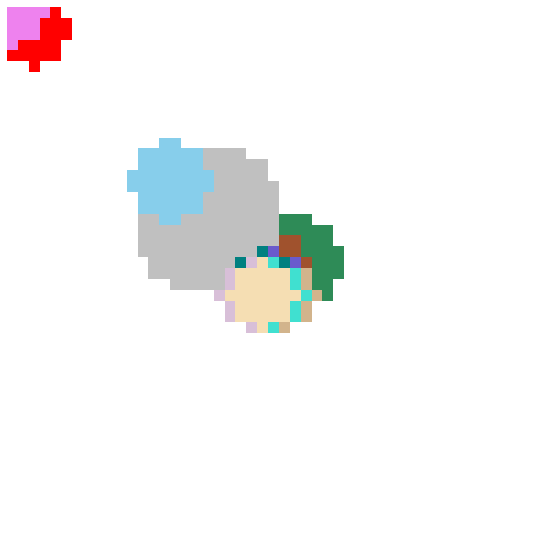

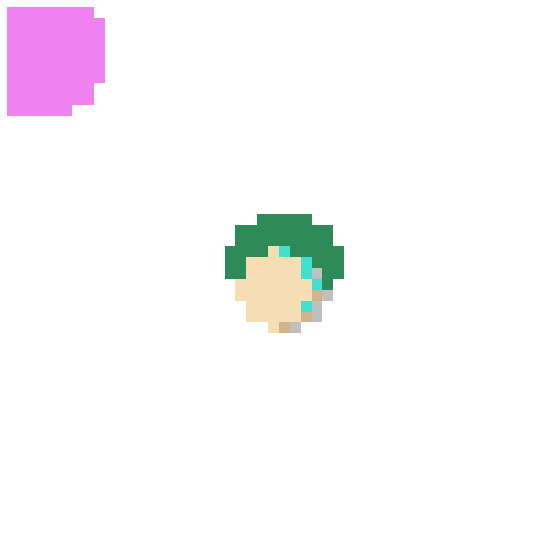

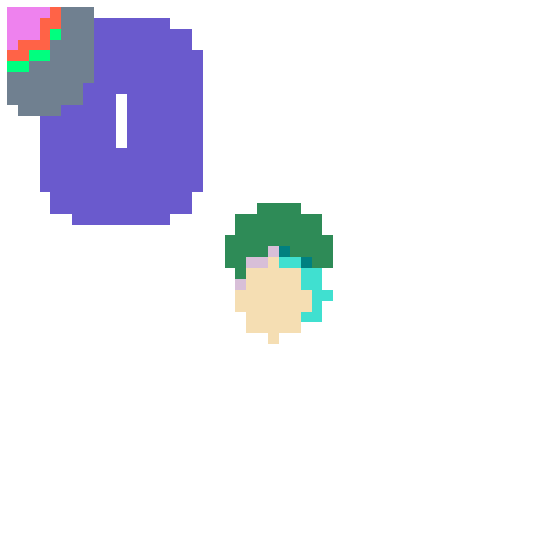

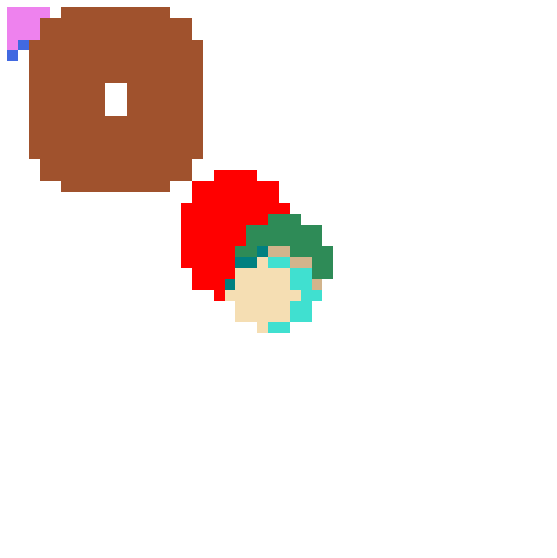

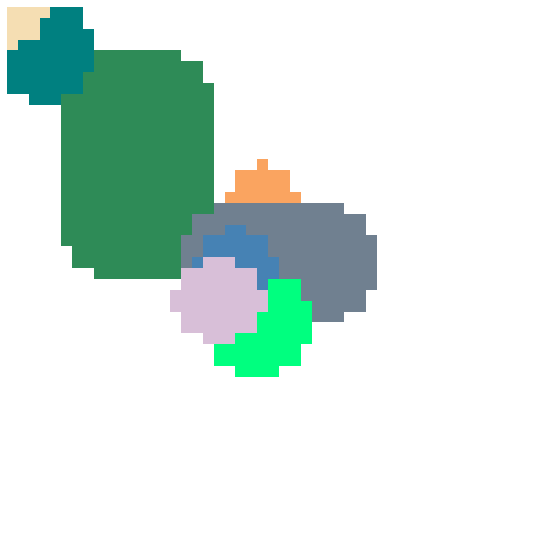

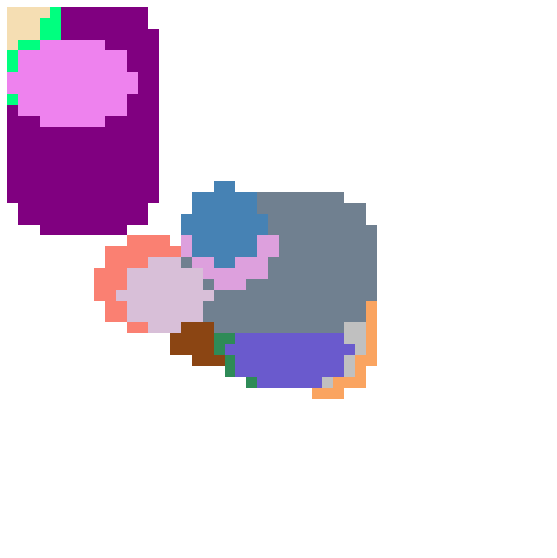

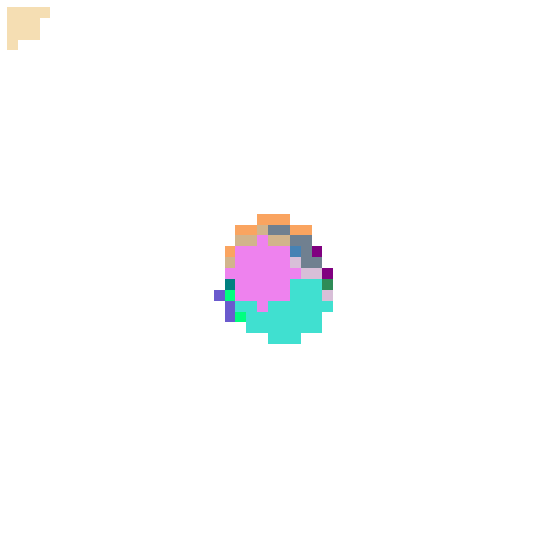

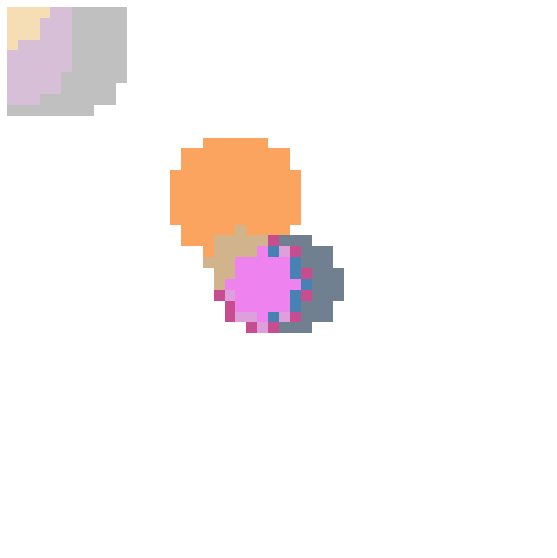

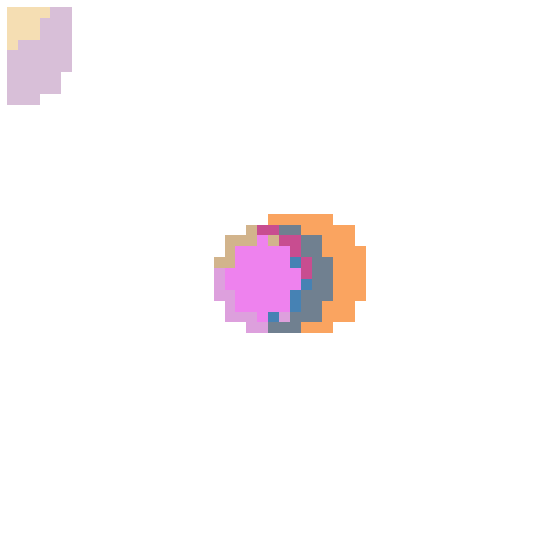

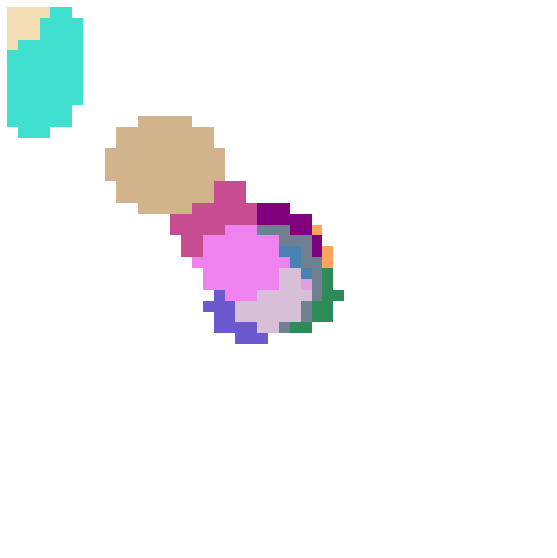

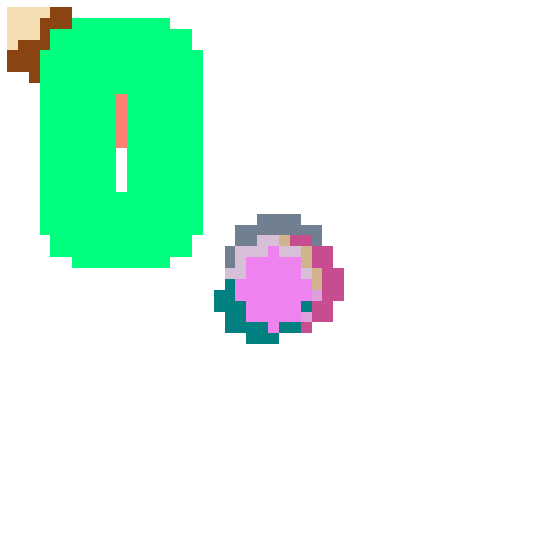

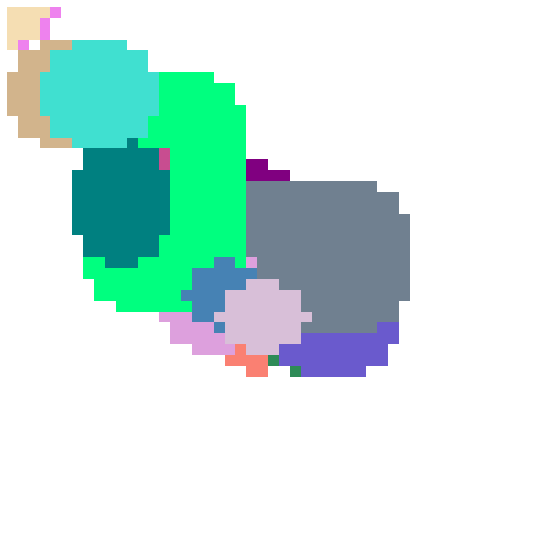

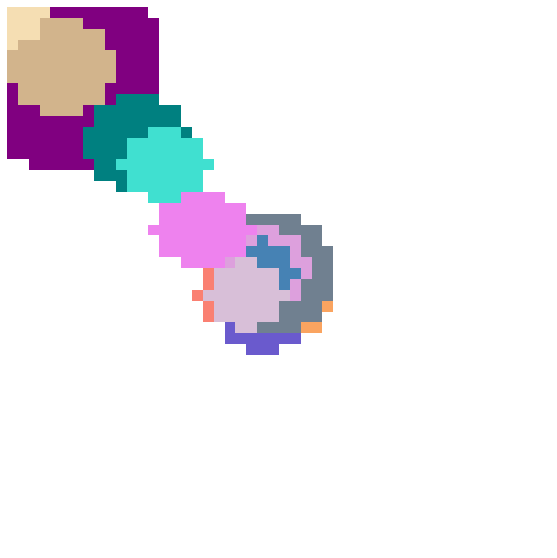

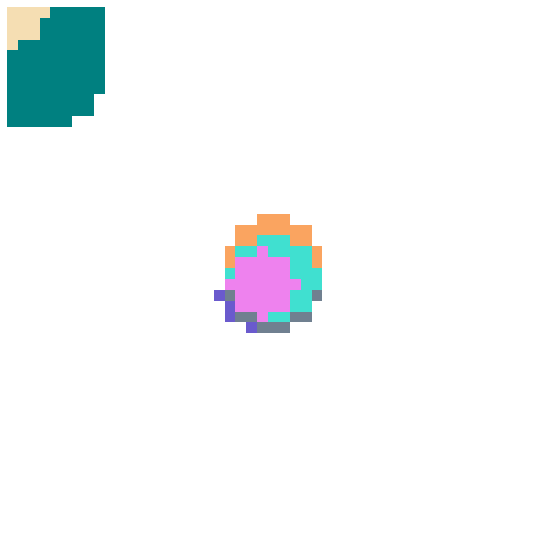

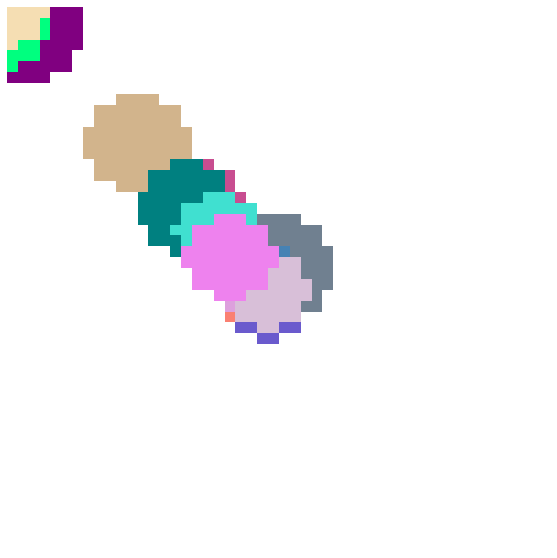

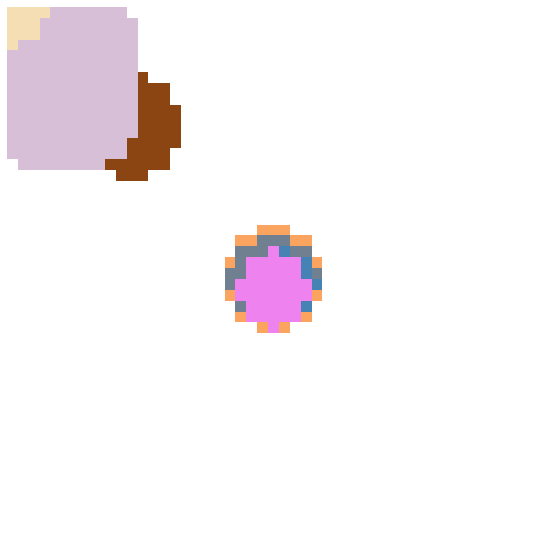

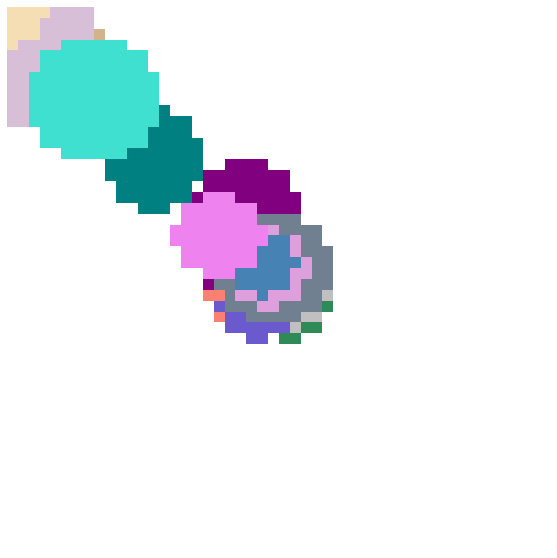

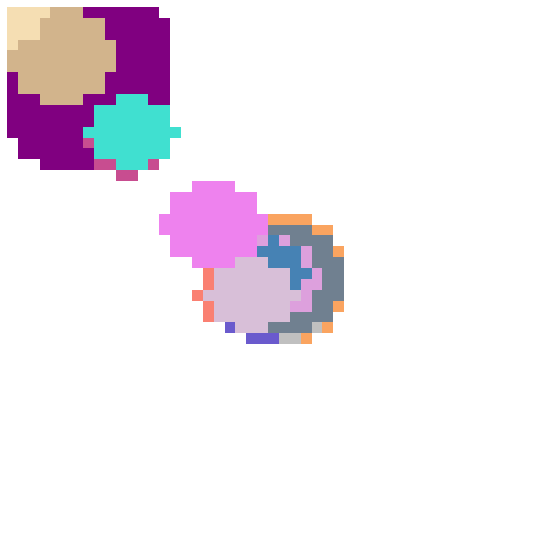

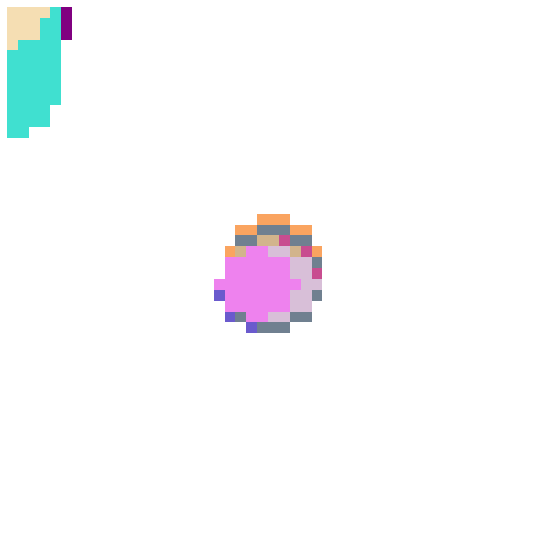

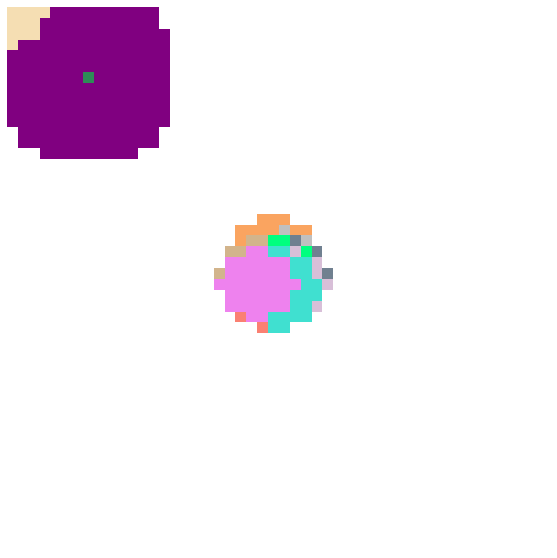

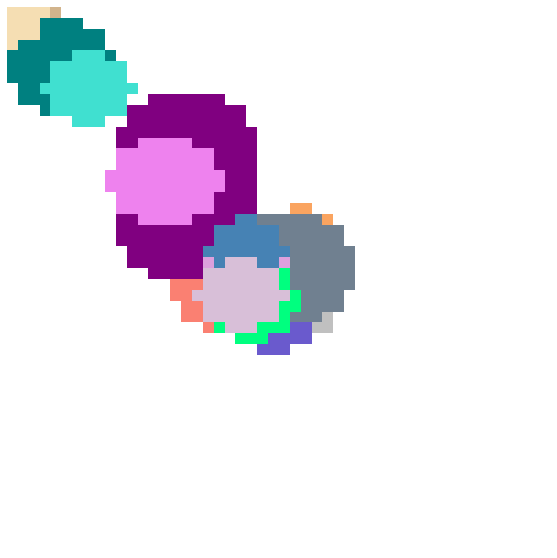

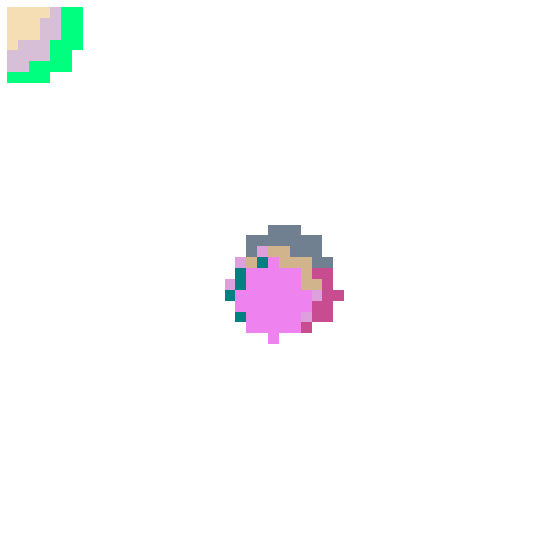

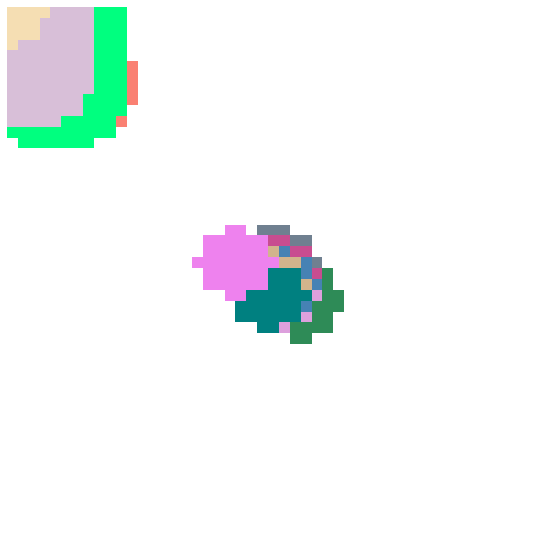

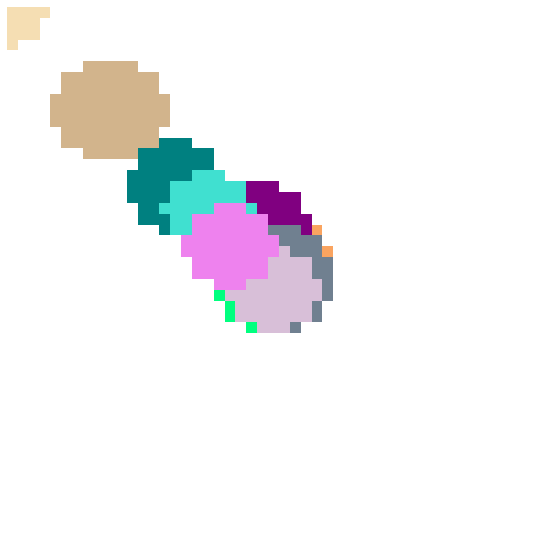

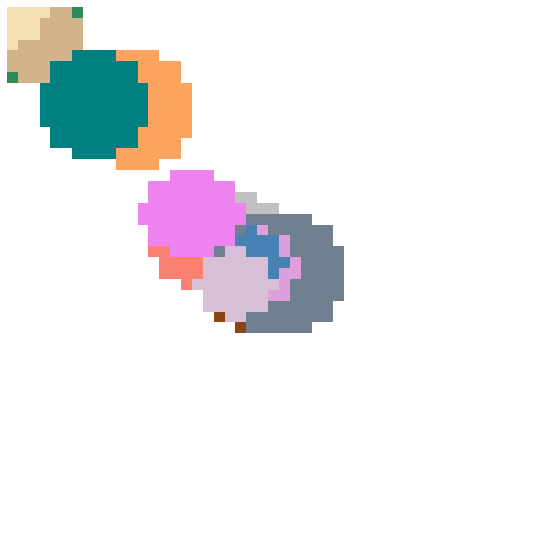

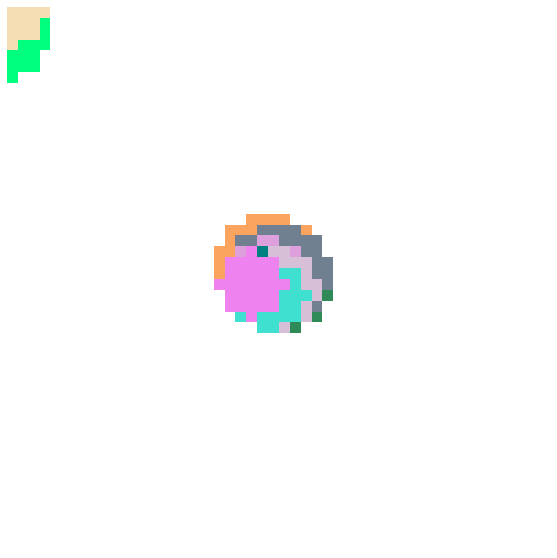

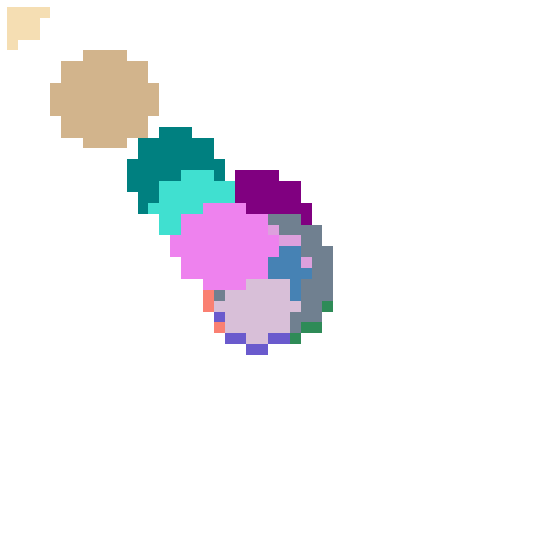

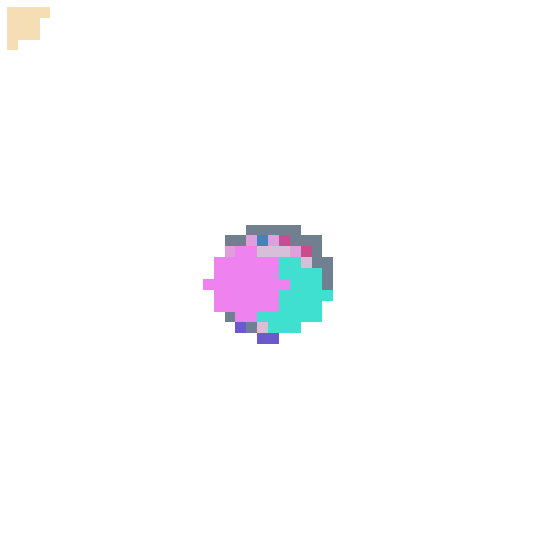

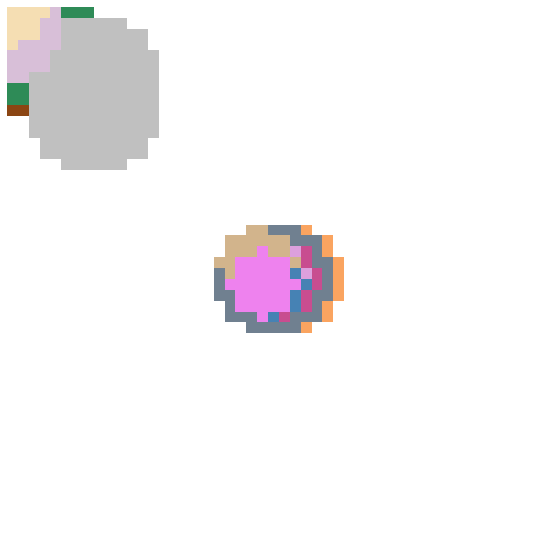

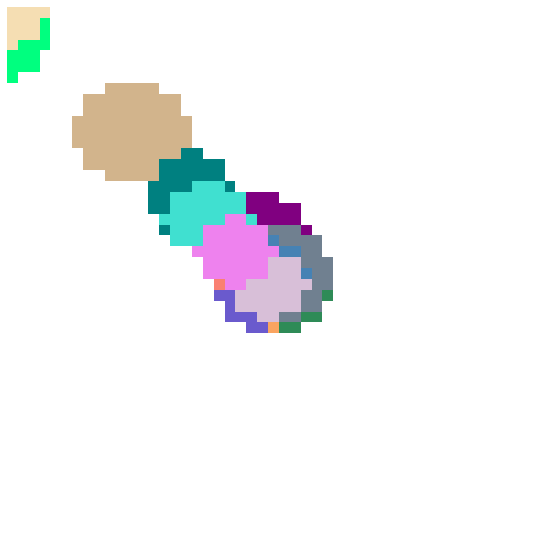

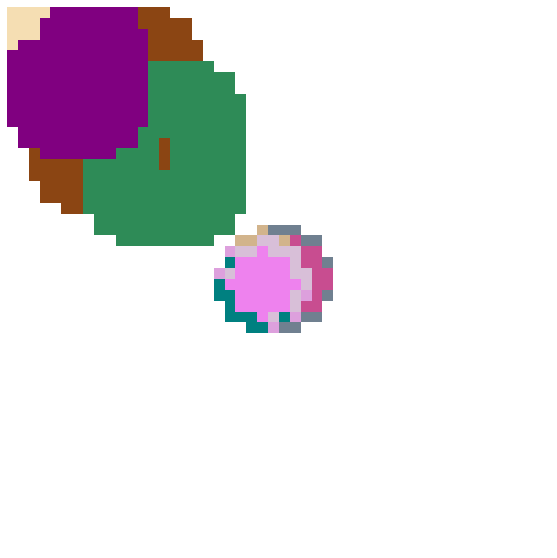

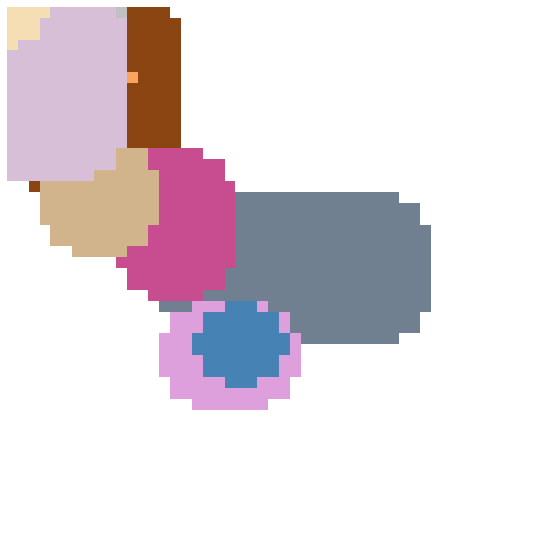

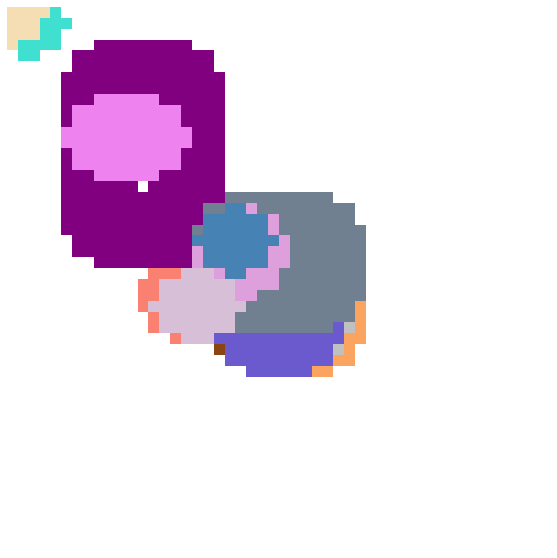

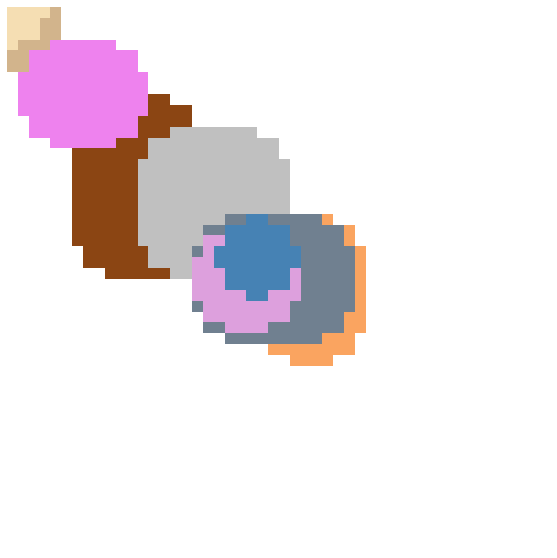

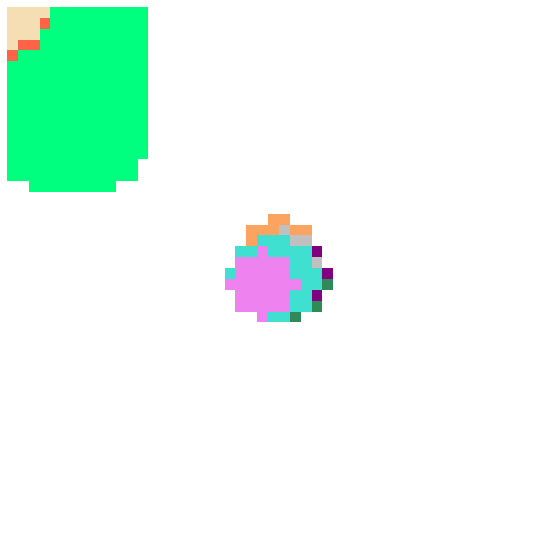

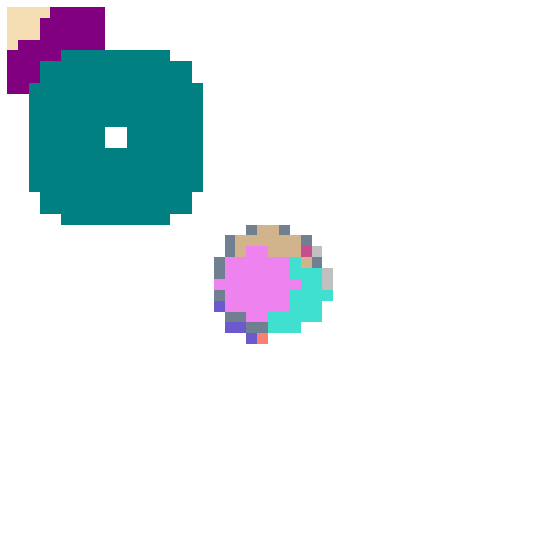

In [ ]:
import dgl
from dgl.nn.pytorch import GraphConv
import torch
import torch as th
import pickle
import dgl.function as fn
from torch import nn
import torch.nn.functional as F

class_vec_sketch = []
label_vec_sketch = []
bbx_gen_sketch = []
batch_size = 32
latent_dim = 64
canvas_size = 50
ls_path = '/content/drive/My Drive/IIITH/OPALNet/checkpoints/'
checkpoint_name = 'model_40.pth'




#load checkpoint
checkpoint = torch.load(ls_path+checkpoint_name)

#initialize model
cvae = CVAE(2*parameters['latent_size'],parameters['latent_size'],parameters['class_size'])
cvae = cvae.to(device)

cvae.load_state_dict(checkpoint['CVAE_state_dict'])
        
object_names = ['bicycle','sheep','bird','motorbike','person','dog','horse','cow','aeroplane','cat']

for object_name in object_names:
    
    ii = 0
    ind = 0
    start_idx = ind*batch_size
    end_idx = start_idx + batch_size

    #E_in =  adj_train[object_name][start_idx:end_idx]
    X_in =  X_train[object_name][start_idx:end_idx]
    print('X_in.shape',X_in.shape)
    clvec = class_v[object_name][start_idx:end_idx]

    for randome in range(1):
        np.random.seed( 11 )
        z =  np.random.normal(0,1,[batch_size, latent_dim])
        z = torch.from_numpy(z)
        z = z.type('torch.FloatTensor')
        clvec = torch.from_numpy(clvec)
        clvec = clvec.type('torch.FloatTensor')
        print('clvec.shape',clvec.shape)
        pp = X_in[:,:,:1]
        pp = torch.from_numpy(pp)
        pp = pp.type('torch.FloatTensor')
        pp = torch.squeeze(pp)
        print('pp.shape',pp.shape)
        try:
            cpp = torch.cat((clvec,pp),-1)
        except:
            continue
        bbox, _, _,_ = cvae.decode(z, cpp)
        bbox = bbox.detach().numpy()
        print('bbox.shape',bbox.shape)
        bbox = np.reshape(bbox,[batch_size,24,4])

        for bbx,pos,classix in zip(bbox, X_in[:, :, :1],clvec):
            pos = np.squeeze(pos)
            class_vec_sketch.append(classix)
            label_vec_sketch.append(pos)
            print('pos.shape',pos.shape)
            #bbx_gen_sketch.append(((bbx)*pos)*canvas_size)

            generated_image = plot_bbx(arrangement((bbx)*canvas_size, object_name))
            sza = 10
            plt.figure(num=None, figsize=(sza, sza))
            plt.axis('off')
            plt.imshow(generated_image)
            plt.savefig('./results/results_cvae/'+object_name+'/'+str(ii)+'_'+str(randome)+'.png')
            #plt.show()
            ii=ii+1